### This notebook includes the MP fits shown in Figure 1 (normalized) and Suppfigure1 (unnormalized)


In [1]:
# load pkgs
import os, errno
import itertools
import subprocess
from pathlib import Path
from functools import partial, singledispatch
from typing import Dict, Union, Optional, List, Any


import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from anndata import AnnData, read_h5ad
import scanpy as sc
from scipy import sparse
from scipy.io import mmwrite
from scipy.stats import zscore
import bipca
from bipca import BiPCA
from bipca.utils import issparse


from tqdm.contrib.concurrent import thread_map,process_map
import torch
from threadpoolctl import threadpool_limits
from sklearn.utils.extmath import cartesian

from collections import OrderedDict

from sklearn.metrics import balanced_accuracy_score
import bipca.experiments.datasets as bipca_datasets
from bipca.experiments.experiments import knn_classifier
# Note: the locations of these pkgs were changed
from bipca.experiments.experiments import libnorm
from bipca.experiments.normalizations import apply_normalizations
from bipca.experiments.normalizations import log1p
from bipca.experiments.experiments import new_svd

/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from bipca.experiments.figures.utils import npg_cmap

In [3]:
import bipca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import anndata as ad

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 8
from matplotlib.offsetbox import AnchoredText

plt.rcParams['text.usetex'] = True

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['text.usetex'] = True


cmap = npg_cmap(alpha=0.7)
pdf_color= list(cmap(7))
pdf_color[-1] = 1
hist_color = cmap(3)
linewidth = 1
anchored_text_prop = dict(size=8)


In [4]:
from bipca.plotting import MP_histograms_from_bipca,MP_histogram,unpack_bipcaobj

# Load 10x Visium data

In [4]:
from bipca.experiments.datasets.datasets import TenX2020HumanBreastCancer

In [5]:
adata = TenX2020HumanBreastCancer(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['full']


Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/TenX2020HumanBreastCancer/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/TenX2020HumanBreastCancer/unfiltered/full.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/TenX2020HumanBreastCancer/unfiltered/full.h5ad in 9.11 seconds.
  Calculated retrieving raw data in 9.11 seconds.
  Calculating filtering full...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 9.97 seconds.
  Calculated filtering full in 10.48 seconds.
Calculated retrieving filtered data in 20.05 seconds.


In [10]:
torch.set_num_threads(36)
with threadpool_limits(limits=36):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over 5 submatrices...
    Chebyshev approximation of KS reached 7.173670846295578e-10 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=0.9768659987300053, c=0.07177222118699439, KS=0.009794301364990265
    Chebyshev approximation of KS reached 3.117756667664617e-10 with 65 coefficients
    Estimated b=0.9747581848078924, c=0.07138499609319089, KS=0.010669309812203265
    Chebyshev approximation of KS reached 2.7972438076360063e-09 with 65 coefficients
    Estimated b=0.9632282801762689, c=0.09296402340953247, KS=0.010382718787393719
    Chebyshev approximation of KS reached 8.362728613688405e-10 with 65 coefficients
    Estimated b=0.9623645470128261, c=0.08886544201128542, KS=0.010143662009138521
    Chebyshev approximation of KS reached 9.656282606136634e-10 with 65 coefficients
    Estimated b=0.9550842659526487, c=0.09809339578228952, KS=0.010388995486982577
    Approximating the mean of all submatrices
    Approximation ratio is 2.054904066075876e-13 with 65 coefficients
    b=0.9751403507878385, c=0.07479593360441322
  Calculated variance fit over 5 submatrices in 1998.99 seconds.
  Calculating S

In [36]:
adata.write_h5ad("./adatas/TenX2020HumanBreastCancer.h5ad")

In [5]:
adata = sc.read_h5ad("./adatas/TenX2020HumanBreastCancer.h5ad")

[Text(0, 0, '0')]

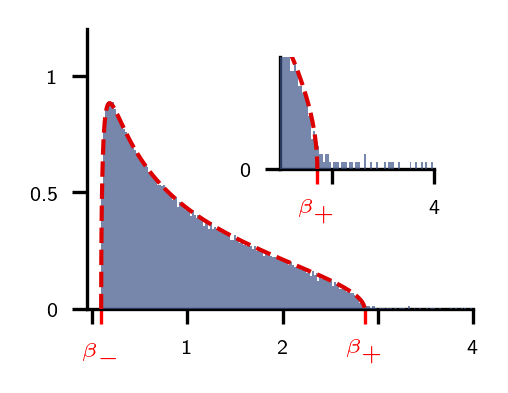

In [31]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False, subtitle=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,2,3,4])

ax.set_xlim([-0.05,4])
ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')

x1, x2, y1, y2 = 2.5, 4, 0, 0.1  # subregion of the original image
axins = ax.inset_axes(
    [0.5, 0.5, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
MP_histograms_from_bipca(adata,axes=axins,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False, subtitle=False)
fig.set_size_inches(1/.75,1)
bipca.plotting.add_colored_tick(axins,[MP.b], [r'$\beta_+$'],dim='x')

axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_xticks([3,4])

axins.set_xticklabels([None,4])
axins.set_title('')


axins.grid(False)
axins.artists[0].remove()
axins.set_xlabel('')
axins.set_ylabel('')
axins.set_ylim([0,0.1])
axins.set_yticks([0])
axins.set_yticklabels([0])

#ax.indicate_inset_zoom(axins, edgecolor="grey")



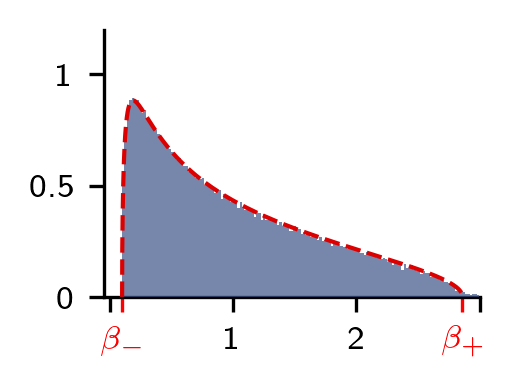

In [98]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False, subtitle=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,2,3,4])

ax.set_xlim([-0.05,3])
ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/visium_humanBreastCancer.svg')

In [7]:
from bipca.math import SVD
from bipca.experiments.experiments import new_svd


In [8]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv) #[sv < cutoff]
median_ratio = actual_median/theoretical_median

Calculating rank k=7785 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=7785 dense exact singular value decomposition using __compute_torch_svd. in 109.54 seconds.


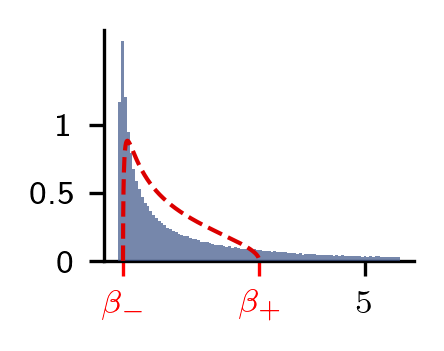

In [9]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histogram(svs=sv/median_ratio,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([5])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/visium_humanBreastCancer.svg')

# seqFISH+

In [76]:
from bipca.experiments.datasets.datasets import Eng2019

In [41]:
adata = Eng2019(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['olfactory_bulb']


Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Eng2019/filtered/subventricular_zone.h5ad...
    Unable to retrieve filtered data from disk.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Eng2019/unfiltered/subventricular_zone.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Eng2019/unfiltered/subventricular_zone.h5ad in 0.03 seconds.
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Eng2019/unfiltered/olfactory_bulb.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Eng2019/unfiltered/olfactory_bulb.h5ad in 0.03 seconds.
  Calculated retrieving raw data in 0.06 seconds.
  Calculating filtering subventricular_zone...
    Calculating filtering An

In [42]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over entire input...
    Chebyshev approximation of KS reached 1.475007779659965e-09 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=1.1443790144130015, c=0.6530957247764883, KS=0.026328890397884885
    Approximating the mean of all submatrices
    Approximation ratio is 1.475007779659965e-09 with 65 coefficients
    b=1.1443784322511232, c=0.6530953925374063
  Calculated variance fit over entire input in 128.91 seconds.
  Calculating Sinkhorn biscaling with dense torch backend...
    Sinkhorn converged early after 20 iterations.
  Calculated Sinkhorn biscaling with dense torch backend in 0.43 seconds.
  Calculating dense Biscaling transform...
  Calculated dense Biscaling transform in 0.03 seconds.
  Calculating rank k=2050 dense exact singular value decomposition using __compute_torch_svd....
  Calculated rank k=2050 dense exact singular value decomposition using __compute_torch_svd. in 3.15 seconds.
  Calculating Shrinker fit...
    Calculating MP Parameter estimate...
      Estimated noise variance computed from the 50th percentile is 1.000
      Scaled Marcenko-Pastur rank is 37
Calculated BiPCA

In [46]:
adata.write_h5ad("./adatas/Eng2019.h5ad")

In [10]:
adata = sc.read_h5ad("./adatas/Eng2019.h5ad")

In [11]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)#[sv < cutoff]
median_ratio = actual_median/theoretical_median

Calculating rank k=2050 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=2050 dense exact singular value decomposition using __compute_torch_svd. in 3.21 seconds.


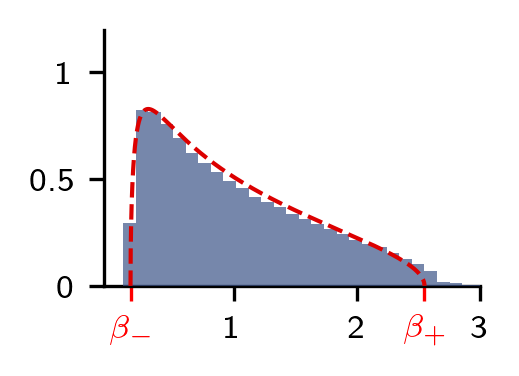

In [12]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=50,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels([1,2,3,4])
ax.set_xlim([-0.05,3])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')
ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/seqfish+.svg')

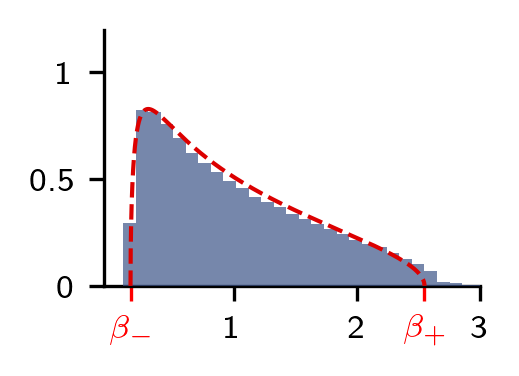

In [95]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=50,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels([1,2,3,4])
ax.set_xlim([-0.05,3])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')
ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/seqfish+_2.svg')

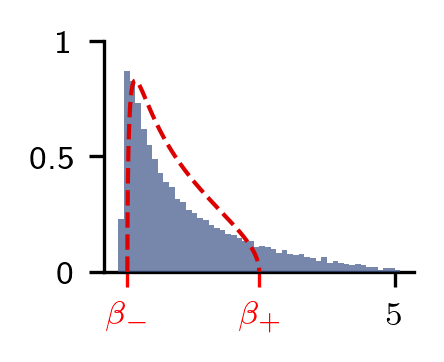

In [13]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=50,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([5])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/seqfish.svg')

# dBIT-seq


In [47]:
from bipca.experiments.datasets.datasets import Liu2020

In [48]:
adata = Liu2020(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['full']


Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Liu2020/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Liu2020/unfiltered/full.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Liu2020/unfiltered/full.h5ad in 1.20 seconds.
  Calculated retrieving raw data in 1.21 seconds.
  Calculating filtering full...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 1.31 seconds.
  Calculated filtering full in 1.38 seconds.
Calculated retrieving filtered data in 2.65 seconds.


In [49]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over entire input...
    Chebyshev approximation of KS reached 7.620171433800634e-10 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=1.1583603553607276, c=0.585069753872623, KS=0.014431819311149674
    Approximating the mean of all submatrices
    Approximation ratio is 7.62017143374788e-10 with 65 coefficients
    b=1.1583639554888019, c=0.5850715722411788
  Calculated variance fit over entire input in 300.81 seconds.
  Calculating Sinkhorn biscaling with dense torch backend...
    Sinkhorn converged early after 20 iterations.
  Calculated Sinkhorn biscaling with dense torch backend in 1.01 seconds.
  Calculating dense Biscaling transform...
  Calculated dense Biscaling transform in 0.06 seconds.
  Calculating rank k=2500 dense exact singular value decomposition using __compute_torch_svd....
  Calculated rank k=2500 dense exact singular value decomposition using __compute_torch_svd. in 3.00 seconds.
  Calculating Shrinker fit...
    Calculating MP Parameter estimate...
      Estimated noise variance computed from the 50th percentile is 1.000
      Scaled Marcenko-Pastur rank is 27
Calculated BiPCA f

In [51]:
adata.write_h5ad("./adatas/Liu2020.h5ad")

In [14]:
adata = sc.read_h5ad("./adatas/Liu2020.h5ad")

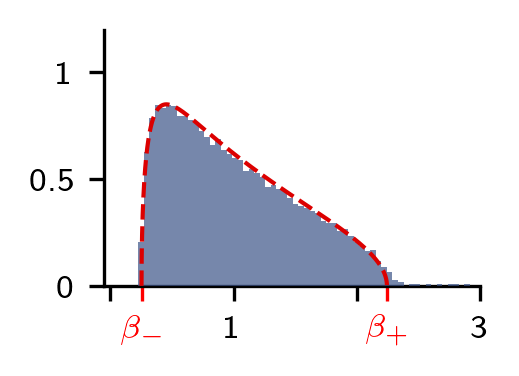

In [104]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([None,1,None,3,4])
ax.set_xlim([-0.05,3])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')
ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/dbit-seq.svg')

In [15]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)#[sv < cutoff]
median_ratio = actual_median/theoretical_median

Calculating rank k=2500 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=2500 dense exact singular value decomposition using __compute_torch_svd. in 9.71 seconds.


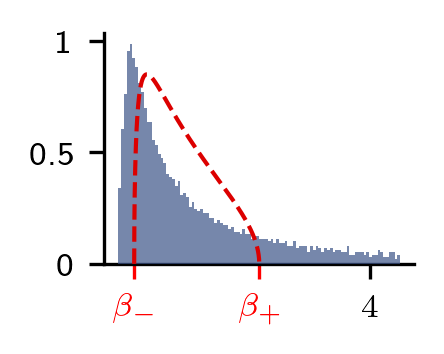

In [16]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([4])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/dbit-seq.svg')

# spatial transcriptomics

In [52]:
from bipca.experiments.datasets.datasets import Asp2019

In [54]:
adata = Asp2019(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['full']

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Asp2019/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Asp2019/unfiltered/full.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SpatialTranscriptomics/Asp2019/unfiltered/full.h5ad in 0.96 seconds.
  Calculated retrieving raw data in 0.96 seconds.
  Calculating filtering full...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 1.58 seconds.
  Calculated filtering full in 1.66 seconds.
Calculated retrieving filtered data in 2.70 seconds.


In [56]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over entire input...
    Chebyshev approximation of KS reached 1.3022106502047295e-09 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=1.1226142341080902, c=0.30757514947903625, KS=0.013524446827459347
    Approximating the mean of all submatrices
    Approximation ratio is 1.3022106502124648e-09 with 65 coefficients
    b=1.1226101688389771, c=0.3075740356718926
  Calculated variance fit over entire input in 239.84 seconds.
  Calculating Sinkhorn biscaling with dense torch backend...
    Sinkhorn converged early after 10 iterations.
  Calculated Sinkhorn biscaling with dense torch backend in 0.82 seconds.
  Calculating dense Biscaling transform...
  Calculated dense Biscaling transform in 0.07 seconds.
  Calculating rank k=3111 dense exact singular value decomposition using __compute_torch_svd....
  Calculated rank k=3111 dense exact singular value decomposition using __compute_torch_svd. in 2.70 seconds.
  Calculating Shrinker fit...
    Calculating MP Parameter estimate...
      Estimated noise variance computed from the 50th percentile is 1.000
      Scaled Marcenko-Pastur rank is 34
Calculated BiP

In [59]:
adata.write_h5ad("./adatas/Asp2019.h5ad")

In [17]:
adata = sc.read_h5ad("./adatas/Asp2019.h5ad")

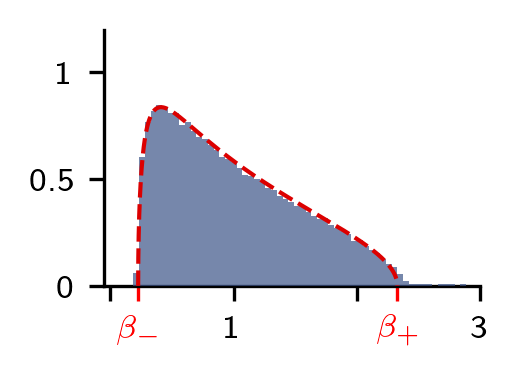

In [111]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([None,1,None,3,4])
ax.set_xlim([-0.05,3])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')
ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/ST_develHeart.svg')

In [18]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv) #[sv < cutoff]
median_ratio = actual_median/theoretical_median

Calculating rank k=3111 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=3111 dense exact singular value decomposition using __compute_torch_svd. in 13.22 seconds.


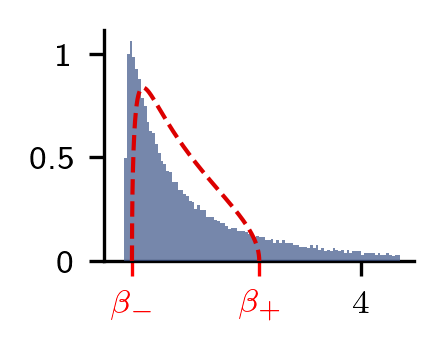

In [19]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([4])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/ST_develHeart.svg')

# multiome

In [21]:
from bipca.experiments.datasets.datasets import OpenChallengeMultiomeData

In [22]:
adata = OpenChallengeMultiomeData(base_data_directory = "/banach2/jyc/data/BiPCA/test/").get_filtered_data()['s1d1']

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/test/datasets/SingleCellRNASeq/OpenChallengeMultiomeData/filtered/s1d1.h5ad...
    Unable to retrieve filtered data from disk.
  Calculated reading filtered data from /banach2/jyc/data/BiPCA/test/datasets/SingleCellRNASeq/OpenChallengeMultiomeData/filtered/s1d1.h5ad in 0.01 seconds.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/test/datasets/SingleCellRNASeq/OpenChallengeMultiomeData/unfiltered/s1d1.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/test/datasets/SingleCellRNASeq/OpenChallengeMultiomeData/unfiltered/s1d1.h5ad in 0.59 seconds.
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/test/datasets/SingleCellRNASeq/OpenChallengeMultiomeData/unfiltered/s1d2.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/test/datasets/SingleCellRNASeq/OpenChalleng

In [23]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over 5 submatrices...
    Chebyshev approximation of KS reached 2.9859177351700454e-10 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=0.926823206593092, c=0.8810647241925217, KS=0.00888890456113356
    Chebyshev approximation of KS reached 1.061872434112973e-10 with 65 coefficients
    Estimated b=0.9185910893530786, c=0.9040830899395006, KS=0.008740315625619277
    Chebyshev approximation of KS reached 5.218918981183836e-09 with 65 coefficients
    Estimated b=0.9755461579569791, c=0.6730693531903036, KS=0.008932231119919143
    Chebyshev approximation of KS reached 3.016374863773521e-10 with 65 coefficients
    Estimated b=0.9168505256505719, c=0.9062024928414062, KS=0.009113422112094649
    Chebyshev approximation of KS reached 6.490701061578726e-10 with 65 coefficients
    Estimated b=0.9292322725548067, c=0.8602132438424993, KS=0.00872936936901303
    Approximating the mean of all submatrices
    Approximation ratio is 2.018397927156682e-10 with 65 coefficients
    b=0.9209204968521874, c=0.8931531672417566
  Calculated variance fit over 5 submatrices in 2038.61 seconds.
  Calculating Sinkhorn bi

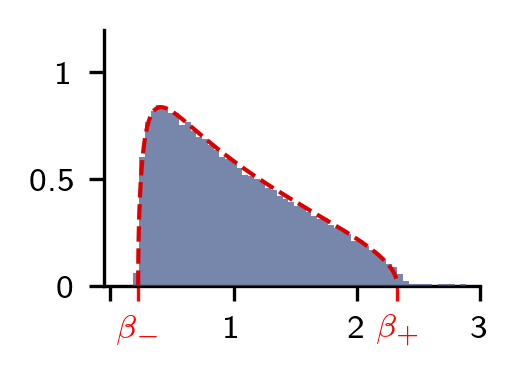

In [120]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels([None,1,2,3])
ax.set_xlim([-0.05,3])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/OpenChallengeMultiome.svg')

In [24]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)
median_ratio = actual_median/theoretical_median

Calculating rank k=6224 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=6224 dense exact singular value decomposition using __compute_torch_svd. in 35.79 seconds.


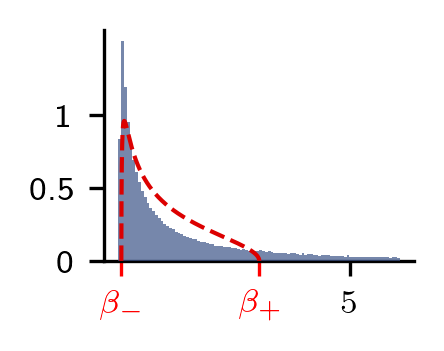

In [25]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([5])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/OpenChallengeMultiome.svg')

# 10x chromium

In [67]:
from bipca.experiments.datasets.datasets import TenX2017PBMC

In [68]:
adata = TenX2017PBMC(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['full']

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/TenX2017PBMC/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculated reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/TenX2017PBMC/filtered/full.h5ad in 0.02 seconds.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/TenX2017PBMC/unfiltered/full.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/TenX2017PBMC/unfiltered/full.h5ad in 1.26 seconds.
  Calculated retrieving raw data in 1.27 seconds.
  Calculating filtering full...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 2.73 seconds.
  Calculated filtering full in 2.84 seconds.
Calculated retrieving filtered data in 4.23 seconds.


In [69]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over 5 submatrices...
    Chebyshev approximation of KS reached 4.5270000184463494e-08 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=0.942868887003197, c=0.29579427206719, KS=0.00812318068363449
    Chebyshev approximation of KS reached 2.2701609248137952e-11 with 65 coefficients
    Estimated b=0.9221371296908968, c=0.4131911425609163, KS=0.007113255383674577
    Chebyshev approximation of KS reached 2.094221602806242e-07 with 65 coefficients
    Estimated b=0.9347298165796555, c=0.34615192082423507, KS=0.007480300609261414
    Estimated b=0.950800504222056, c=0.28121784668939764, KS=0.00797603799638924
    Chebyshev approximation of KS reached 4.28530727277961e-09 with 65 coefficients
    Estimated b=0.9140480903267889, c=0.42347808940055803, KS=0.007937441463000017
    Approximating the mean of all submatrices
    Approximation ratio is 2.398994065438695e-09 with 65 coefficients
    b=0.9306592752573867, c=0.359900317427968
  Calculated variance fit over 5 submatrices in 2273.89 seconds.
  Calculating Sinkhorn biscaling with dense torch backend...
    Sinkhorn converged early after 30 iterations.


In [71]:
adata.write_h5ad("./adatas/TenX2017PBMC.h5ad")

In [26]:
adata = sc.read_h5ad("./adatas/TenX2017PBMC.h5ad")

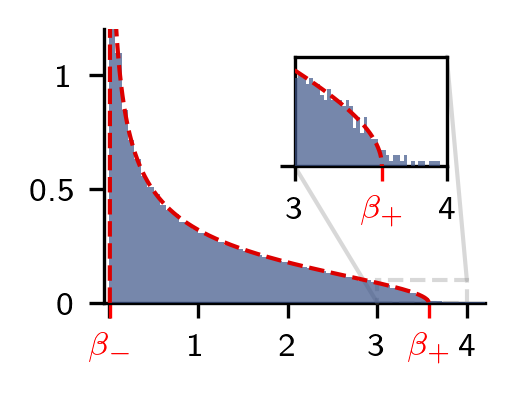

In [126]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([None,1,2,3,4])
ax.set_xlim([-0.05,4.2])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')

x1, x2, y1, y2 = 3, 4, 0, 0.1  # subregion of the original image
axins = ax.inset_axes(
    [0.5, 0.5, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
MP_histograms_from_bipca(adata,axes=axins,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False, subtitle=False)
fig.set_size_inches(1/.75,1)
bipca.plotting.add_colored_tick(axins,[MP.b], [r'$\beta_+$'],dim='x')
#axins.spines['top'].set_visible(False)
#axins.spines['right'].set_visible(False)
axins.set_xticks([3,4])

axins.set_xticklabels([3,4])
axins.set_title('')


axins.grid(False)
axins.artists[0].remove()
axins.set_xlabel('')
axins.set_ylabel('')
axins.set_ylim([0,0.1])
#axins.axvline(x=MP.b,ymin=0, ymax=6,c='r',linestyle = '--',lw=1)

axins.set_yticks([0])
axins.set_yticklabels([None])
ax.indicate_inset_zoom(axins, edgecolor="grey",linestyle = '--',alpha=0.3)

fig.savefig('MP_demos/TenX2017PBMC_zoomedin.svg')


In [27]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)
median_ratio = actual_median/theoretical_median

Calculating rank k=8380 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=8380 dense exact singular value decomposition using __compute_torch_svd. in 50.90 seconds.


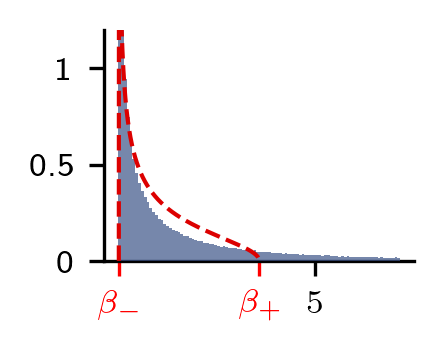

In [28]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([5])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/TenX2017PBMC.svg')

# CITE-seq

In [72]:
from bipca.experiments.datasets.datasets import Stoeckius2017

In [73]:
adata = Stoeckius2017(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['full']

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/Stoeckius2017/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/Stoeckius2017/unfiltered/full.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/Stoeckius2017/unfiltered/full.h5ad in 1.07 seconds.
  Calculated retrieving raw data in 1.07 seconds.
  Calculating filtering full...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 1.14 seconds.
  Calculated filtering full in 1.23 seconds.
Calculated retrieving filtered data in 2.39 seconds.


In [74]:
adata

AnnData object with n_obs × n_vars = 7634 × 8773
    obs: 'protein_annotations', 'rna_annotations', 'passQC', 'total_UMIs', 'total_MT_UMIs', 'pct_MT_UMIs', 'total_genes'
    var: 'isMouse', 'total_UMIs', 'total_cells', 'is_MT'

In [75]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over 5 submatrices...
    Chebyshev approximation of KS reached 7.342333251928494e-09 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=0.9273384715726687, c=0.4637435944018102, KS=0.006291179337142516
    Chebyshev approximation of KS reached 4.049201306658468e-08 with 65 coefficients
    Estimated b=0.9429776630239118, c=0.3651440285376165, KS=0.007150701424684214
    Chebyshev approximation of KS reached 3.7062805096242954e-10 with 65 coefficients
    Estimated b=0.9194639657280611, c=0.4920712992557855, KS=0.006891857394978662
    Chebyshev approximation of KS reached 3.5144214482036574e-09 with 65 coefficients
    Estimated b=0.9589257669508546, c=0.29493174459452265, KS=0.006636328667317892
    Chebyshev approximation of KS reached 1.7034982695320632e-07 with 65 coefficients
    Estimated b=0.9221392871707522, c=0.4778822414221944, KS=0.006547296247574108
    Approximating the mean of all submatrices
    Approximation ratio is 4.277852547881135e-09 with 65 coefficients
    b=0.9365218546138752, c=0.40561256832883075
  Calculated variance fit over 5 submatrices in 1874.98 seconds.
  Calculating Sin

In [77]:
adata.write_h5ad("./adatas/Stoeckius2017.h5ad")

In [29]:
adata = sc.read_h5ad("./adatas/Stoeckius2017.h5ad")

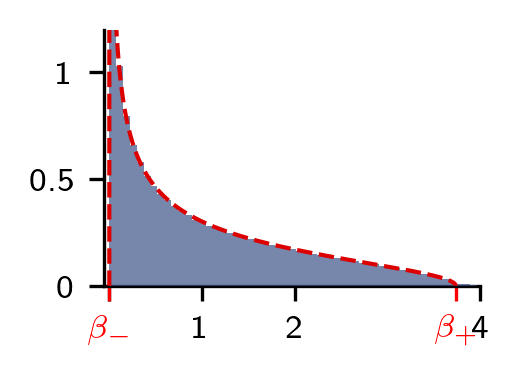

In [133]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,2,4])
ax.set_xticklabels([None,1,2,4])
ax.set_xlim([-0.05,4])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/Stoeckius2017.svg')

In [30]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)
median_ratio = actual_median/theoretical_median

Calculating rank k=7634 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=7634 dense exact singular value decomposition using __compute_torch_svd. in 41.31 seconds.


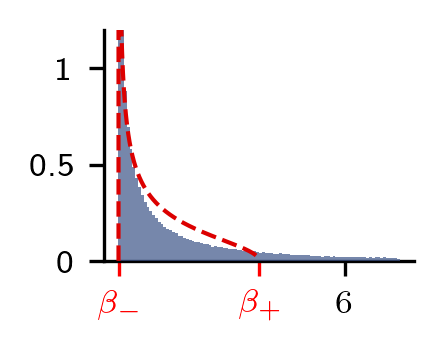

In [31]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([6])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/Stoeckius2017.svg')

# smart-seq v3xpress

In [78]:
from bipca.experiments.datasets.datasets import HagemannJensen2022

In [79]:
adata = HagemannJensen2022(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['full']

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/HagemannJensen2022/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/HagemannJensen2022/unfiltered/full.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellRNASeq/HagemannJensen2022/unfiltered/full.h5ad in 1.34 seconds.
  Calculated retrieving raw data in 1.34 seconds.
  Calculating filtering full...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 15.03 seconds.
  Calculated filtering full in 16.82 seconds.
Calculated retrieving filtered data in 19.67 seconds.


In [81]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over 5 submatrices...
    Chebyshev approximation of KS reached 3.7882767686909076e-08 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=1.47880021398341, c=0.7182033694261095, KS=0.006992456418058457
    Chebyshev approximation of KS reached 2.9806563276103184e-07 with 65 coefficients
    Estimated b=1.4778686127373575, c=0.7425388578063995, KS=0.007338557654913314
    Chebyshev approximation of KS reached 3.349311168482719e-08 with 65 coefficients
    Estimated b=1.476046236012155, c=0.7780798698677189, KS=0.006998444790046632
    Chebyshev approximation of KS reached 4.025574476980539e-09 with 65 coefficients
    Estimated b=1.4827621907275403, c=0.7387723765022148, KS=0.007137304249031917
    Chebyshev approximation of KS reached 3.0289688189559293e-13 with 65 coefficients
    Estimated b=1.4824599650114867, c=0.7194467114830896, KS=0.006914661935110256
    Approximating the mean of all submatrices
    Approximation ratio is 1.614328161852752e-08 with 65 coefficients
    b=1.480325976095898, c=0.7347008508777079
  Calculated variance fit over 5 submatrices in 2301.21 seconds.
  Calculating Sinkhorn b

In [84]:
adata.write_h5ad("adatas/HagemannJensen2022.h5ad")

In [32]:
adata = sc.read_h5ad("adatas/HagemannJensen2022.h5ad")

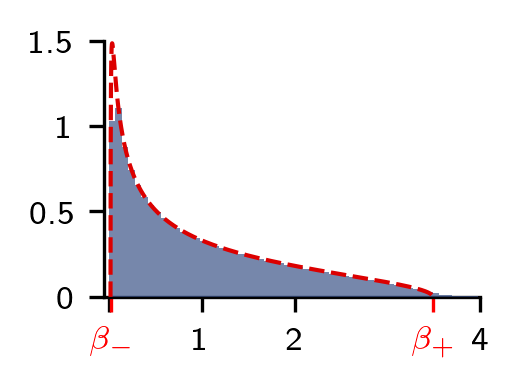

In [147]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,2,4])
ax.set_xticklabels([None,1,2,4])
ax.set_xlim([-0.05,4])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1,1.5])
ax.set_yticklabels([0,0.5,1,1.5])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/HagemannJensen2022.svg')

In [33]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)
median_ratio = actual_median/theoretical_median

Calculating rank k=26168 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=26168 dense exact singular value decomposition using __compute_torch_svd. in 1480.13 seconds.


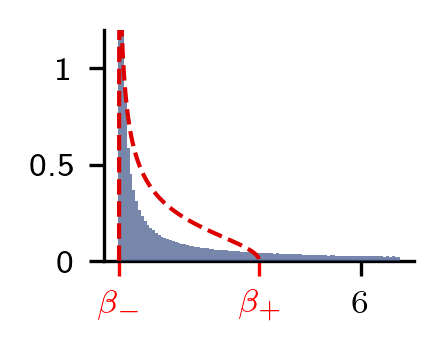

In [34]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([6])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/HagemannJensen2022.svg')

# chromium atac

In [85]:
from bipca.experiments.datasets.datasets import TenX2019PBMCATAC

In [86]:
adata = TenX2019PBMCATAC(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['full']

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/TenX2019PBMCATAC/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculated reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/TenX2019PBMCATAC/filtered/full.h5ad in 0.04 seconds.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/TenX2019PBMCATAC/unfiltered/full.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/TenX2019PBMCATAC/unfiltered/full.h5ad in 0.37 seconds.
  Calculated retrieving raw data in 0.37 seconds.
  Calculating filtering full...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 14.69 seconds.
  Calculated filtering full in 15.21 seconds.
Calculated retrieving filtered data in 16.84 seconds.


In [87]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over 5 submatrices...
    Chebyshev approximation of KS reached 1.204626424834139e-08 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=1.8693122002058522, c=0.6735871031537477, KS=0.00397853741776788
    Chebyshev approximation of KS reached 2.011534750003348e-10 with 65 coefficients
    Estimated b=1.8767106335328578, c=0.6954639165190002, KS=0.0038373467136250117
    Chebyshev approximation of KS reached 3.869147040730773e-10 with 65 coefficients
    Estimated b=2.001554863807187, c=0.3552265144308138, KS=0.0036699738953435146
    Chebyshev approximation of KS reached 1.3637367998133978e-08 with 65 coefficients
    Estimated b=1.782878787310962, c=0.9373599808760077, KS=0.003939001544295384
    Chebyshev approximation of KS reached 3.355479519371542e-08 with 65 coefficients
    Estimated b=1.9383244337788679, c=0.5216578567395814, KS=0.00381691567116782
    Approximating the mean of all submatrices
    Approximation ratio is 9.227528907018859e-10 with 65 coefficients
    b=1.9344712680675233, c=0.5287772559210268
  Calculated variance fit over 5 submatrices in 1953.81 seconds.
  Calculating Sinkhorn 

In [92]:
adata.write_h5ad("adatas/TenX2019PBMCATAC.h5ad")

In [35]:
adata = sc.read_h5ad("adatas/TenX2019PBMCATAC.h5ad")

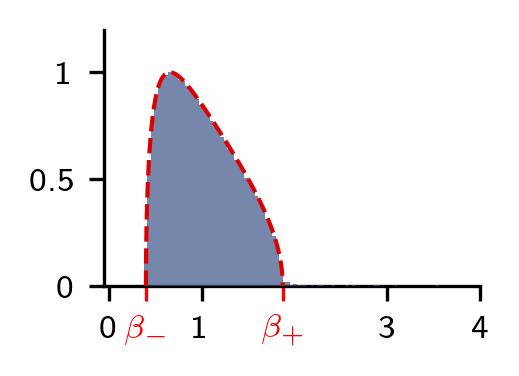

In [141]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,3,4])
ax.set_xticklabels([0,1,3,4])
ax.set_xlim([-0.05,4])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/TenX2019PBMCATAC.svg')

In [36]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)
median_ratio = actual_median/theoretical_median

Calculating rank k=8416 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=8416 dense exact singular value decomposition using __compute_torch_svd. in 458.65 seconds.


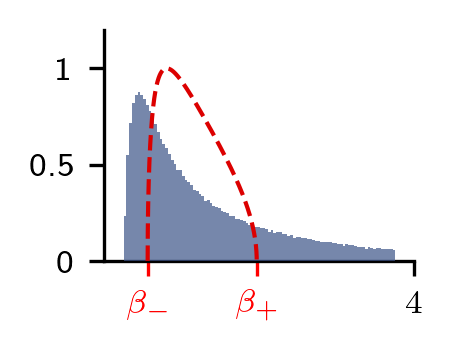

In [37]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([4])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/TenX2019PBMCATAC.svg')

# multiome atac

In [93]:
from bipca.experiments.datasets.datasets import OpenChallengeMultiomeData_ATAC

In [94]:
adata = OpenChallengeMultiomeData_ATAC(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['s1d1']

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/OpenChallengeMultiomeData_ATAC/filtered/s1d1.h5ad...
    Unable to retrieve filtered data from disk.
  Calculated reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/OpenChallengeMultiomeData_ATAC/filtered/s1d1.h5ad in 0.02 seconds.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/OpenChallengeMultiomeData_ATAC/unfiltered/s1d1.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/OpenChallengeMultiomeData_ATAC/unfiltered/s1d1.h5ad in 1.27 seconds.
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/OpenChallengeMultiomeData_ATAC/unfiltered/s1d2.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellATACSeq/OpenChallen

In [95]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over 5 submatrices...
    Chebyshev approximation of KS reached 1.369015175949397e-09 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=1.948897631668596, c=0.22964680565399195, KS=0.0018911536036982923
    Chebyshev approximation of KS reached 4.724619723621002e-11 with 65 coefficients
    Estimated b=1.2611980069229654, c=3.027772949409671, KS=0.002309953800924025
    Chebyshev approximation of KS reached 7.012127079907602e-11 with 65 coefficients
    Estimated b=1.8446057621255048, c=0.6534217022835864, KS=0.0021789851998288423
    Chebyshev approximation of KS reached 3.820591973067844e-10 with 65 coefficients
    Estimated b=1.9677752652847578, c=0.16301984455513024, KS=0.002079808549690254
    Chebyshev approximation of KS reached 1.395817637570063e-09 with 65 coefficients
    Estimated b=1.729248866300847, c=1.1193139039906834, KS=0.002099517111064486
    Approximating the mean of all submatrices
    Approximation ratio is 6.230754729317172e-11 with 65 coefficients
    b=1.8495631454982167, c=0.627728493168981
  Calculated variance fit over 5 submatrices in 2461.87 seconds.
  Calculating Sinkhorn

In [98]:
adata.write_h5ad("adatas/multiome_atac.h5ad")

In [38]:
adata = sc.read_h5ad("adatas/multiome_atac.h5ad")

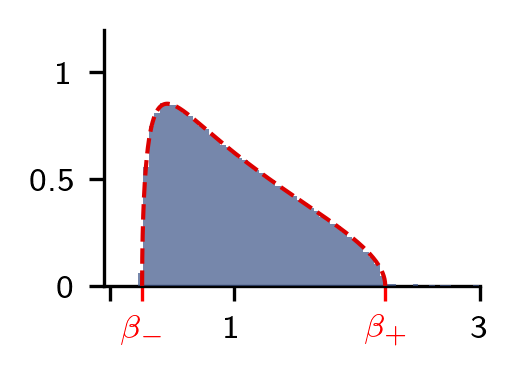

In [153]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,3])
ax.set_xticklabels([None,1,3])
ax.set_xlim([-0.05,3])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/multiome_atac.svg')

In [39]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata)
svd_result = SVD(backend='torch',n_components=-1).fit(adata.X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)
median_ratio = actual_median/theoretical_median

Calculating rank k=6224 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=6224 dense exact singular value decomposition using __compute_torch_svd. in 117.74 seconds.


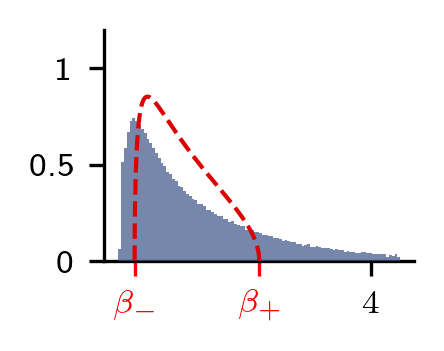

In [40]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([4])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/multiome_atac.svg')

# snp

In [156]:
from bipca.experiments.datasets.datasets import Byrska2022

In [157]:
adata = Byrska2022(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()['full']

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleNucleotidePolymorphism/Byrska2022/filtered/full.h5ad...
    Unable to retrieve filtered data from disk.
  Calculated reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleNucleotidePolymorphism/Byrska2022/filtered/full.h5ad in 0.01 seconds.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleNucleotidePolymorphism/Byrska2022/unfiltered/full.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleNucleotidePolymorphism/Byrska2022/unfiltered/full.h5ad in 1.91 seconds.
  Calculated retrieving raw data in 1.91 seconds.
  Calculating filtering full...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 3.21 seconds.
  Calculated filtering full in 3.49 seconds.
Calculated retrieving filtered data in 5.73 seconds.


In [158]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,variance_estimator="binomial",read_counts=2,seed=42)
    if issparse(adata.X):
        adata.X = adata.X.toarray()
    Z = op.fit_transform(adata.X)
    op.write_to_adata(adata)
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating Sinkhorn biscaling with dense torch backend...
    Sinkhorn converged early after 10 iterations.
  Calculated Sinkhorn biscaling with dense torch backend in 0.78 seconds.
  Calculating dense Biscaling transform...
  Calculated dense Biscaling transform in 0.09 seconds.
  Calculating rank k=2573 dense exact singular value decomposition using __compute_torch_svd....
  Calculated rank k=2573 dense exact singular value decomposition using __compute_torch_svd. in 2.78 seconds.
  Calculating Shrinker fit...
    Calculating MP Parameter estimate...
      Pre-computed noise variance is 1.000
      Scaled Marcenko-Pastur rank is 43
Calculated BiPCA fit in 3.94 seconds.
Calculating Shrinking singular values according to frobenius loss...
Calculating Writing bipca to anndata...
  Calculating Shrinking singular values according to frobenius loss...
Calculated Writing bipca to anndata in 0.33 seconds.
Calculating plotting spectra...
  Calculating spectrum of b

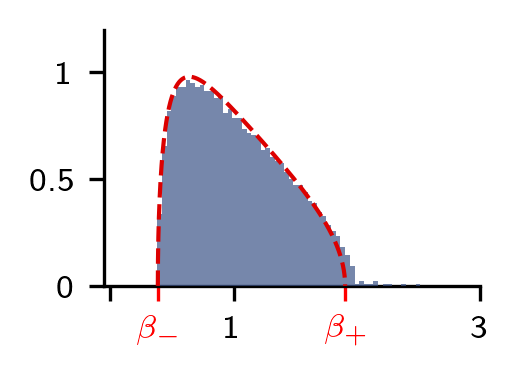

In [160]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata,bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,3])
ax.set_xticklabels([None,1,3])
ax.set_xlim([-0.05,3])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata.shape)/np.max(adata.shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/snp.svg')

# hi-c

In [41]:
from bipca.experiments.datasets.datasets import Johanson2018

In [ ]:
adata = Johanson2018(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/ChromatinConformationCapture/Johanson2018/filtered/CD4T1_1_2.h5ad...
    Unable to retrieve filtered data from disk.
  Calculated reading filtered data from /banach2/jyc/data/BiPCA/datasets/ChromatinConformationCapture/Johanson2018/filtered/CD4T1_1_2.h5ad in 0.01 seconds.
  Calculating retrieving raw data...
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/ChromatinConformationCapture/Johanson2018/unfiltered/CD4T1_1_2.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/ChromatinConformationCapture/Johanson2018/unfiltered/CD4T1_1_2.h5ad in 0.38 seconds.
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/ChromatinConformationCapture/Johanson2018/unfiltered/CD4T1_1_3.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/ChromatinConformationCapture/Johanson20

/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   9  15 ... 220 134   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   9  15 ... 220 134   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   9  15 ... 220 134   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering CD4T1_1_3 in 0.15 seconds.
  Calculating filtering CD4T1_1_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T1_1_4 in 0.12 seconds.
  Calculating filtering CD4T1_1_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  19  17 ... 208 120   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  10   9 ... 171 103   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  10   9 ... 171 103   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T1_1_5 in 0.12 seconds.
  Calculating filtering CD4T1_1_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T1_1_6 in 0.11 seconds.
  Calculating filtering CD4T1_1_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   9  12 ... 148 119   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   9  12 ... 148 119   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6   6  10 ... 193 132   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_1_7 in 0.10 seconds.
  Calculating filtering CD4T1_1_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_1_8 in 0.09 seconds.
  Calculating filtering CD4T1_1_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   9  55 ... 179 100   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   9  55 ... 179 100   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   6  12 ... 123  72   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_1_9 in 0.10 seconds.
  Calculating filtering CD4T1_1_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_1_10 in 0.08 seconds.
  Calculating filtering CD4T1_1_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_1_11 in 0.09 seconds.
  Calculating filtering CD4T1_1_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  11  16 ... 165 136   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  11  11 ... 163  89   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  11  11 ... 163  89   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_1_12 in 0.08 seconds.
  Calculating filtering CD4T1_1_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_1_13 in 0.06 seconds.
  Calculating filtering CD4T1_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_1_14 in 0.07 seconds.
  Calculating filtering CD4T1_1_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   9  18 ... 167 101   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   9  18 ... 167 101   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   9  18 ... 167 101   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_1_15 in 0.09 seconds.
  Calculating filtering CD4T1_1_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_1_16 in 0.11 seconds.
  Calculating filtering CD4T1_1_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  58   9 ... 122  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  58   9 ... 122  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  58   9 ... 122  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T1_1_17 in 0.10 seconds.
  Calculating filtering CD4T1_1_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_1_18 in 0.06 seconds.
  Calculating filtering CD4T1_1_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_1_19 in 0.07 seconds.
  Calculating filtering CD4T1_1_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   8  17 ... 154  83   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   8  17 ... 154  83   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   8  17 ... 154  83   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_1_20 in 0.08 seconds.
  Calculating filtering CD4T1_1_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_1_21 in 0.05 seconds.
  Calculating filtering CD4T1_1_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_1_22 in 0.07 seconds.
  Calculating filtering CD4T1_2_3...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  14  22 ... 114  67   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  14  22 ... 114  67   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  14  22 ... 114  67   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T1_2_3 in 0.12 seconds.
  Calculating filtering CD4T1_2_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T1_2_4 in 0.12 seconds.
  Calculating filtering CD4T1_2_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 171 189 ...   1  38   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 171 188 ...   1  38   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 171 188 ...   1  38   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T1_2_5 in 0.11 seconds.
  Calculating filtering CD4T1_2_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T1_2_6 in 0.11 seconds.
  Calculating filtering CD4T1_2_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 155 146 ...   0  27  13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[121 155 146 ...   0  27  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[121 155 146 ...   0  27  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_2_7 in 0.10 seconds.
  Calculating filtering CD4T1_2_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_2_8 in 0.09 seconds.
  Calculating filtering CD4T1_2_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[115 157 141 ...   0  37   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[115 157 141 ...   0  37   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[115 157 141 ...   0  37   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_2_9 in 0.08 seconds.
  Calculating filtering CD4T1_2_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_2_10 in 0.09 seconds.
  Calculating filtering CD4T1_2_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[121 147 133 ...   0  61  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[121 147 133 ...   0  61  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[121 147 133 ...   0  61  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_2_11 in 0.09 seconds.
  Calculating filtering CD4T1_2_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_2_12 in 0.10 seconds.
  Calculating filtering CD4T1_2_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_2_13 in 0.07 seconds.
  Calculating filtering CD4T1_2_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[148 139 157 ...   0  55  20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[113 110 159 ...   0  39   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[113 110 159 ...   0  39   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_2_14 in 0.07 seconds.
  Calculating filtering CD4T1_2_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_2_15 in 0.07 seconds.
  Calculating filtering CD4T1_2_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_2_16 in 0.06 seconds.
  Calculating filtering CD4T1_2_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 82  92 103 ...   0  20  10]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 81  92 103 ...   0  20  10]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 81  92 103 ...   0  20  10]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_2_17 in 0.08 seconds.
  Calculating filtering CD4T1_2_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_2_18 in 0.06 seconds.
  Calculating filtering CD4T1_2_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_2_19 in 0.06 seconds.
  Calculating filtering CD4T1_2_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[155 147 140 ...   0  88  21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[155 147 140 ...   0  88  21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[155 147 140 ...   0  88  21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_2_20 in 0.06 seconds.
  Calculating filtering CD4T1_2_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_2_21 in 0.06 seconds.
  Calculating filtering CD4T1_2_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_2_22 in 0.05 seconds.
  Calculating filtering CD4T1_3_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[83 99 82 ...  0 31  9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[83 99 82 ...  0 31  9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 53 70 ...  0 13  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T1_3_4 in 0.10 seconds.
  Calculating filtering CD4T1_3_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_3_5 in 0.09 seconds.
  Calculating filtering CD4T1_3_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[119 173 134 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[119 173 134 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[129 142 136 ...   3   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T1_3_6 in 0.11 seconds.
  Calculating filtering CD4T1_3_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_3_7 in 0.09 seconds.
  Calculating filtering CD4T1_3_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_3_8 in 0.10 seconds.
  Calculating filtering CD4T1_3_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[136 203 175 ...   0   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 142 152 ...   5   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 142 152 ...   5   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_3_9 in 0.09 seconds.
  Calculating filtering CD4T1_3_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_3_10 in 0.09 seconds.
  Calculating filtering CD4T1_3_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 90 137 120 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 89 137 120 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 89 137 120 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_3_11 in 0.09 seconds.
  Calculating filtering CD4T1_3_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_3_12 in 0.09 seconds.
  Calculating filtering CD4T1_3_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_3_13 in 0.07 seconds.
  Calculating filtering CD4T1_3_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[109 151 147 ...   0   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[109 151 147 ...   0   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 86 153 131 ...   3   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_3_14 in 0.07 seconds.
  Calculating filtering CD4T1_3_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_3_15 in 0.06 seconds.
  Calculating filtering CD4T1_3_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_3_16 in 0.06 seconds.
  Calculating filtering CD4T1_3_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[72 82 61 ...  0  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[72 82 61 ...  0  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[72 82 61 ...  0  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_3_17 in 0.07 seconds.
  Calculating filtering CD4T1_3_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_3_18 in 0.06 seconds.
  Calculating filtering CD4T1_3_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_3_19 in 0.05 seconds.
  Calculating filtering CD4T1_3_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_3_20 in 0.06 seconds.
  Calculating filtering CD4T1_3_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[62 86 71 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[62 86 71 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[62 86 71 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_3_21 in 0.05 seconds.
  Calculating filtering CD4T1_3_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_3_22 in 0.04 seconds.
  Calculating filtering CD4T1_4_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T1_4_5 in 0.11 seconds.
  Calculating filtering CD4T1_4_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[31 36 32 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[31 36 32 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[31 36 32 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_4_6 in 0.08 seconds.
  Calculating filtering CD4T1_4_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_4_7 in 0.08 seconds.
  Calculating filtering CD4T1_4_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 105 113 ...  94  20   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 104 113 ...  94  20   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 104 113 ...  94  20   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_4_8 in 0.10 seconds.
  Calculating filtering CD4T1_4_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_4_9 in 0.08 seconds.
  Calculating filtering CD4T1_4_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_4_10 in 0.08 seconds.
  Calculating filtering CD4T1_4_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 77 131 149 ... 148  32   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 77 131 149 ... 148  32   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[104 155 204 ... 164  28   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_4_11 in 0.06 seconds.
  Calculating filtering CD4T1_4_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_4_12 in 0.06 seconds.
  Calculating filtering CD4T1_4_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_4_13 in 0.09 seconds.
  Calculating filtering CD4T1_4_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 86 111 178 ... 110  20   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 86 111 178 ... 109  19   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 86 111 178 ... 109  19   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_4_14 in 0.08 seconds.
  Calculating filtering CD4T1_4_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_4_15 in 0.05 seconds.
  Calculating filtering CD4T1_4_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_4_16 in 0.05 seconds.
  Calculating filtering CD4T1_4_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 131 180 ... 196  33   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 131 180 ... 196  33   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 131 180 ... 196  33   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_4_17 in 0.05 seconds.
  Calculating filtering CD4T1_4_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_4_18 in 0.06 seconds.
  Calculating filtering CD4T1_4_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_4_19 in 0.04 seconds.
  Calculating filtering CD4T1_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_4_20 in 0.05 seconds.
  Calculating filtering CD4T1_4_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 65 103 167 ...  96   7   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122  93  76 ... 186  36   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122  93  76 ... 186  36   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_4_21 in 0.05 seconds.
  Calculating filtering CD4T1_4_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_4_22 in 0.04 seconds.
  Calculating filtering CD4T1_5_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_5_6 in 0.09 seconds.
  Calculating filtering CD4T1_5_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[50 72 68 ... 82 16  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 68  77 107 ...  91  19   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 68  77 107 ...  90  19   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering CD4T1_5_7 in 0.13 seconds.
  Calculating filtering CD4T1_5_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_5_8 in 0.09 seconds.
  Calculating filtering CD4T1_5_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 168 173 ...   3   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 168 173 ...   3   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[113 185 159 ...   0   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD4T1_5_9 in 0.08 seconds.
  Calculating filtering CD4T1_5_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_5_10 in 0.08 seconds.
  Calculating filtering CD4T1_5_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_5_11 in 0.08 seconds.
  Calculating filtering CD4T1_5_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[133 192 205 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[133 192 204 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[133 192 204 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_5_12 in 0.08 seconds.
  Calculating filtering CD4T1_5_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_5_13 in 0.06 seconds.
  Calculating filtering CD4T1_5_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_5_14 in 0.07 seconds.
  Calculating filtering CD4T1_5_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[118 195 145 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[59 80 86 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[59 80 85 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

  Calculated filtering CD4T1_5_15 in 0.06 seconds.
  Calculating filtering CD4T1_5_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_5_16 in 0.07 seconds.
  Calculating filtering CD4T1_5_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_5_17 in 0.06 seconds.
  Calculating filtering CD4T1_5_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_5_18 in 0.07 seconds.
  Calculating filtering CD4T1_5_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[156 230 210 ...   2   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[155 230 210 ...   2   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[155 230 210 ...   2   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_5_19 in 0.05 seconds.
  Calculating filtering CD4T1_5_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_5_20 in 0.05 seconds.
  Calculating filtering CD4T1_5_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_5_21 in 0.04 seconds.
  Calculating filtering CD4T1_5_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_5_22 in 0.04 seconds.
  Calculating filtering CD4T1_6_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[137 152 150 ...   3   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[157 217 192 ...   3   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[157 216 192 ...   3   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_6_7 in 0.08 seconds.
  Calculating filtering CD4T1_6_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_6_8 in 0.08 seconds.
  Calculating filtering CD4T1_6_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_6_9 in 0.07 seconds.
  Calculating filtering CD4T1_6_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 11 ...  1 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 11 ...  1 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 14 ...  4 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_6_10 in 0.09 seconds.
  Calculating filtering CD4T1_6_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_6_11 in 0.07 seconds.
  Calculating filtering CD4T1_6_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 18 ...  2 30  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 18 ...  2 30  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 18 ...  2 30  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD4T1_6_12 in 0.08 seconds.
  Calculating filtering CD4T1_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_6_13 in 0.06 seconds.
  Calculating filtering CD4T1_6_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_6_14 in 0.06 seconds.
  Calculating filtering CD4T1_6_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_6_15 in 0.06 seconds.
  Calculating filtering CD4T1_6_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  1 ...  2 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  1 ...  2 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  1 ...  2 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_6_16 in 0.05 seconds.
  Calculating filtering CD4T1_6_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_6_17 in 0.06 seconds.
  Calculating filtering CD4T1_6_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_6_18 in 0.06 seconds.
  Calculating filtering CD4T1_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_6_19 in 0.04 seconds.
  Calculating filtering CD4T1_6_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  9 ...  3 15  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  7 ...  2 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  7 ...  2 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_6_20 in 0.05 seconds.
  Calculating filtering CD4T1_6_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_6_21 in 0.05 seconds.
  Calculating filtering CD4T1_6_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_6_22 in 0.04 seconds.
  Calculating filtering CD4T1_7_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_7_8 in 0.08 seconds.
  Calculating filtering CD4T1_7_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  9 ...  0 16  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  9 ...  0 16  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  6 ...  2 14  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_7_9 in 0.07 seconds.
  Calculating filtering CD4T1_7_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_7_10 in 0.08 seconds.
  Calculating filtering CD4T1_7_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6   1   1 ... 178 148 113]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6   1   1 ... 178 148 113]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6   1   1 ... 178 148 113]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD4T1_7_11 in 0.08 seconds.
  Calculating filtering CD4T1_7_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_7_12 in 0.08 seconds.
  Calculating filtering CD4T1_7_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_7_13 in 0.05 seconds.
  Calculating filtering CD4T1_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_7_14 in 0.06 seconds.
  Calculating filtering CD4T1_7_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 218 185 141]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 218 185 141]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 218 185 141]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_7_15 in 0.06 seconds.
  Calculating filtering CD4T1_7_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_7_16 in 0.06 seconds.
  Calculating filtering CD4T1_7_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_7_17 in 0.07 seconds.
  Calculating filtering CD4T1_7_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  0  0 ... 99 93 62]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  0  0 ... 99 93 62]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6   1   0 ... 164 137 105]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

  Calculated filtering CD4T1_7_18 in 0.06 seconds.
  Calculating filtering CD4T1_7_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_7_19 in 0.05 seconds.
  Calculating filtering CD4T1_7_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_7_20 in 0.06 seconds.
  Calculating filtering CD4T1_7_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_7_21 in 0.04 seconds.
  Calculating filtering CD4T1_7_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_7_22 in 0.04 seconds.
  Calculating filtering CD4T1_8_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   1   1 ... 111  89  94]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   1   1 ... 111  89  94]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   1   1 ... 111  89  94]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_8_9 in 0.07 seconds.
  Calculating filtering CD4T1_8_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_8_10 in 0.07 seconds.
  Calculating filtering CD4T1_8_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_8_11 in 0.07 seconds.
  Calculating filtering CD4T1_8_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   7 ... 197 115   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   7 ... 197 115   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   7 ... 197 115   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_8_12 in 0.07 seconds.
  Calculating filtering CD4T1_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_8_13 in 0.08 seconds.
  Calculating filtering CD4T1_8_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_8_14 in 0.07 seconds.
  Calculating filtering CD4T1_8_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   6 ... 170  91   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   6 ... 169  90   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   6 ... 169  90   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_8_15 in 0.05 seconds.
  Calculating filtering CD4T1_8_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_8_16 in 0.05 seconds.
  Calculating filtering CD4T1_8_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_8_17 in 0.05 seconds.
  Calculating filtering CD4T1_8_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   2 ... 123  60   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   2 ... 123  60   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   2 ... 123  60   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_8_18 in 0.07 seconds.
  Calculating filtering CD4T1_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_8_19 in 0.04 seconds.
  Calculating filtering CD4T1_8_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_8_20 in 0.05 seconds.
  Calculating filtering CD4T1_8_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_8_21 in 0.05 seconds.
  Calculating filtering CD4T1_8_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_8_22 in 0.04 seconds.
  Calculating filtering CD4T1_9_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  11 ... 329 195   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  11 ... 329 194   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  11 ... 329 194   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_9_10 in 0.07 seconds.
  Calculating filtering CD4T1_9_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_9_11 in 0.07 seconds.
  Calculating filtering CD4T1_9_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_9_12 in 0.06 seconds.
  Calculating filtering CD4T1_9_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 82 90 ...  2  4  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 82 90 ...  2  4  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 82 90 ...  2  4  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_9_13 in 0.07 seconds.
  Calculating filtering CD4T1_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_9_14 in 0.07 seconds.
  Calculating filtering CD4T1_9_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_9_15 in 0.06 seconds.
  Calculating filtering CD4T1_9_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[37 83 96 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[37 83 96 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[37 83 96 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_9_16 in 0.08 seconds.
  Calculating filtering CD4T1_9_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_9_17 in 0.06 seconds.
  Calculating filtering CD4T1_9_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_9_18 in 0.06 seconds.
  Calculating filtering CD4T1_9_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 96 89 ...  6  2  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 96 89 ...  6  2  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 96 89 ...  6  2  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_9_19 in 0.04 seconds.
  Calculating filtering CD4T1_9_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_9_20 in 0.07 seconds.
  Calculating filtering CD4T1_9_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_9_21 in 0.05 seconds.
  Calculating filtering CD4T1_9_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_9_22 in 0.05 seconds.
  Calculating filtering CD4T1_10_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 41 38 ...  5  6  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 86 74 ...  0  3  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 86 74 ...  0  3  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_10_11 in 0.08 seconds.
  Calculating filtering CD4T1_10_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T1_10_12 in 0.09 seconds.
  Calculating filtering CD4T1_10_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 25 182 176 ...  27   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 25 182 176 ...  27   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 25 182 176 ...  27   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_10_13 in 0.06 seconds.
  Calculating filtering CD4T1_10_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T1_10_14 in 0.12 seconds.
  Calculating filtering CD4T1_10_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_10_15 in 0.07 seconds.
  Calculating filtering CD4T1_10_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  94 114 ...  45   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  94 114 ...  44   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  94 114 ...  44   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_10_16 in 0.07 seconds.
  Calculating filtering CD4T1_10_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_10_17 in 0.08 seconds.
  Calculating filtering CD4T1_10_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_10_18 in 0.06 seconds.
  Calculating filtering CD4T1_10_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 14 156 127 ...  36   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 14 156 127 ...  36   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 24 238 239 ...  22   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_10_19 in 0.05 seconds.
  Calculating filtering CD4T1_10_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_10_20 in 0.06 seconds.
  Calculating filtering CD4T1_10_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_10_21 in 0.05 seconds.
  Calculating filtering CD4T1_10_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_10_22 in 0.05 seconds.
  Calculating filtering CD4T1_11_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10 149 114 ...   9   0   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 12 158 141 ...  37   0   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 12 158 141 ...  36   0   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T1_11_12 in 0.09 seconds.
  Calculating filtering CD4T1_11_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_11_13 in 0.05 seconds.
  Calculating filtering CD4T1_11_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_11_14 in 0.06 seconds.
  Calculating filtering CD4T1_11_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1  10 ... 132 183 127]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1  10 ... 132 183 127]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1  10 ... 132 183 127]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_11_15 in 0.06 seconds.
  Calculating filtering CD4T1_11_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_11_16 in 0.08 seconds.
  Calculating filtering CD4T1_11_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_11_17 in 0.07 seconds.
  Calculating filtering CD4T1_11_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   4 ...  59 100  56]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   4 ...  58 100  56]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   4 ...  58 100  56]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_11_18 in 0.06 seconds.
  Calculating filtering CD4T1_11_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_11_19 in 0.06 seconds.
  Calculating filtering CD4T1_11_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T1_11_20 in 0.07 seconds.
  Calculating filtering CD4T1_11_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   3 ...  83 125  79]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   3 ...  83 125  79]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   3 ...  83 125  79]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_11_21 in 0.05 seconds.
  Calculating filtering CD4T1_11_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_11_22 in 0.05 seconds.
  Calculating filtering CD4T1_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_12_13 in 0.05 seconds.
  Calculating filtering CD4T1_12_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_12_14 in 0.06 seconds.
  Calculating filtering CD4T1_12_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 18 30 21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 13 ... 50 66 27]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 13 ... 50 66 27]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_12_15 in 0.06 seconds.
  Calculating filtering CD4T1_12_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_12_16 in 0.07 seconds.
  Calculating filtering CD4T1_12_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_12_17 in 0.06 seconds.
  Calculating filtering CD4T1_12_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_12_18 in 0.05 seconds.
  Calculating filtering CD4T1_12_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 24  0 ... 99 78 19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 24  0 ... 99 78 19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 16  37   0 ... 166 158  53]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_12_19 in 0.06 seconds.
  Calculating filtering CD4T1_12_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_12_20 in 0.05 seconds.
  Calculating filtering CD4T1_12_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T1_12_21 in 0.04 seconds.
  Calculating filtering CD4T1_12_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T1_12_22 in 0.04 seconds.
  Calculating filtering CD4T1_13_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 23  70   1 ... 443 456 182]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 23  70   1 ... 443 455 181]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 23  70   1 ... 443 455 181]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_13_14 in 0.06 seconds.
  Calculating filtering CD4T1_13_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_13_15 in 0.05 seconds.
  Calculating filtering CD4T1_13_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_13_16 in 0.05 seconds.
  Calculating filtering CD4T1_13_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T1_13_17 in 0.04 seconds.
  Calculating filtering CD4T1_13_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 195 175   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 195 175   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 195 175   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_13_18 in 0.07 seconds.
  Calculating filtering CD4T1_13_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T1_13_19 in 0.03 seconds.
  Calculating filtering CD4T1_13_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_13_20 in 0.04 seconds.
  Calculating filtering CD4T1_13_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_13_21 in 0.05 seconds.
  Calculating filtering CD4T1_13_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T1_13_22 in 0.04 seconds.
  Calculating filtering CD4T1_14_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 126 116   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 126 116   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 126 116   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_14_15 in 0.06 seconds.
  Calculating filtering CD4T1_14_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_14_16 in 0.04 seconds.
  Calculating filtering CD4T1_14_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_14_17 in 0.04 seconds.
  Calculating filtering CD4T1_14_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_14_18 in 0.06 seconds.
  Calculating filtering CD4T1_14_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 15  4 ...  0 93  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 15  4 ...  0 92  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 15  4 ...  0 92  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T1_14_19 in 0.04 seconds.
  Calculating filtering CD4T1_14_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_14_20 in 0.05 seconds.
  Calculating filtering CD4T1_14_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_14_21 in 0.05 seconds.
  Calculating filtering CD4T1_14_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_14_22 in 0.05 seconds.
  Calculating filtering CD4T1_15_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  1 ...  0 60  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  1 ...  0 60  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  1 ...  0 60  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_15_16 in 0.06 seconds.
  Calculating filtering CD4T1_15_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_15_17 in 0.06 seconds.
  Calculating filtering CD4T1_15_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_15_18 in 0.05 seconds.
  Calculating filtering CD4T1_15_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_15_19 in 0.04 seconds.
  Calculating filtering CD4T1_15_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 81 90 ... 79 67 27]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 81 90 ... 79 67 27]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 31 48 ... 72 78 35]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_15_20 in 0.06 seconds.
  Calculating filtering CD4T1_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_15_21 in 0.05 seconds.
  Calculating filtering CD4T1_15_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_15_22 in 0.06 seconds.
  Calculating filtering CD4T1_16_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_16_17 in 0.06 seconds.
  Calculating filtering CD4T1_16_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  80 134 ... 104  67  35]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  80 134 ... 104  67  35]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  80 134 ... 104  67  35]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_16_18 in 0.06 seconds.
  Calculating filtering CD4T1_16_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_16_19 in 0.05 seconds.
  Calculating filtering CD4T1_16_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T1_16_20 in 0.07 seconds.
  Calculating filtering CD4T1_16_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[25 49 43 ...  8 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[25 48 43 ...  8 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[25 48 43 ...  8 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD4T1_16_21 in 0.04 seconds.
  Calculating filtering CD4T1_16_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_16_22 in 0.05 seconds.
  Calculating filtering CD4T1_17_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_17_18 in 0.04 seconds.
  Calculating filtering CD4T1_17_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_17_19 in 0.05 seconds.
  Calculating filtering CD4T1_17_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_17_20 in 0.05 seconds.
  Calculating filtering CD4T1_17_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96 174 178 ...  44  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96 174 178 ...  44  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96 174 178 ...  44  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_17_21 in 0.04 seconds.
  Calculating filtering CD4T1_17_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_17_22 in 0.05 seconds.
  Calculating filtering CD4T1_18_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_18_19 in 0.05 seconds.
  Calculating filtering CD4T1_18_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T1_18_20 in 0.05 seconds.
  Calculating filtering CD4T1_18_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 54 23  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 54 23  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 54 23  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_18_21 in 0.05 seconds.
  Calculating filtering CD4T1_18_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T1_18_22 in 0.04 seconds.
  Calculating filtering CD4T1_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_19_20 in 0.05 seconds.
  Calculating filtering CD4T1_19_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T1_19_21 in 0.04 seconds.
  Calculating filtering CD4T1_19_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_19_22 in 0.04 seconds.
  Calculating filtering CD4T1_20_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 65 98 ... 88 20  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 65 98 ... 88 20  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3 58 70 ... 77 20  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_20_21 in 0.04 seconds.
  Calculating filtering CD4T1_20_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_20_22 in 0.05 seconds.
  Calculating filtering CD4T1_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T1_21_22 in 0.04 seconds.
  Calculating filtering CD4T2_1_2...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 59 61 ... 26 28  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 59 61 ... 26 28  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 59 61 ... 26 28  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering CD4T2_1_2 in 0.13 seconds.
  Calculating filtering CD4T2_1_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_1_3 in 0.12 seconds.
  Calculating filtering CD4T2_1_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  25  23 ... 248 163   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  25  23 ... 248 163   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  18  20 ... 200 119   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_1_4 in 0.08 seconds.
  Calculating filtering CD4T2_1_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_1_5 in 0.09 seconds.
  Calculating filtering CD4T2_1_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  24  22 ... 111  66   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  24  22 ... 111  66   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6  25  29 ... 140 105   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_1_6 in 0.11 seconds.
  Calculating filtering CD4T2_1_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_1_7 in 0.09 seconds.
  Calculating filtering CD4T2_1_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_1_8 in 0.07 seconds.
  Calculating filtering CD4T2_1_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  17  13 ... 216 138   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  30  88 ... 190 105   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  30  88 ... 190 105   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_1_9 in 0.11 seconds.
  Calculating filtering CD4T2_1_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  37  44 ... 192 117   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  37  44 ... 192 116   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  37  44 ... 192 116   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD4T2_1_10 in 0.14 seconds.
  Calculating filtering CD4T2_1_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_1_11 in 0.10 seconds.
  Calculating filtering CD4T2_1_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_1_12 in 0.11 seconds.
  Calculating filtering CD4T2_1_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  28  32 ... 175 111   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  28  32 ... 175 111   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  28  32 ... 175 111   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_1_13 in 0.07 seconds.
  Calculating filtering CD4T2_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_1_14 in 0.07 seconds.
  Calculating filtering CD4T2_1_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_1_15 in 0.10 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 12 14 ... 97 64  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 12 14 ... 97 64  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 12 14 ... 97 64  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculating filtering CD4T2_1_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_1_16 in 0.09 seconds.
  Calculating filtering CD4T2_1_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_1_17 in 0.10 seconds.
  Calculating filtering CD4T2_1_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 140  86 ... 157  97   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 140  86 ... 157  97   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 140  86 ... 157  97   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_1_18 in 0.06 seconds.
  Calculating filtering CD4T2_1_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_1_19 in 0.08 seconds.
  Calculating filtering CD4T2_1_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_1_20 in 0.08 seconds.
  Calculating filtering CD4T2_1_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 11 ... 81 53  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13  62  38 ... 182 121   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13  62  38 ... 182 120   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_1_21 in 0.05 seconds.
  Calculating filtering CD4T2_1_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_1_22 in 0.07 seconds.
  Calculating filtering CD4T2_2_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  8  5 ... 52 36  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 39 35 ... 97 59  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 39 35 ... 97 59  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD4T2_2_3 in 0.13 seconds.
  Calculating filtering CD4T2_2_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_2_4 in 0.12 seconds.
  Calculating filtering CD4T2_2_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_2_5 in 0.11 seconds.
  Calculating filtering CD4T2_2_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[134 144 147 ...   0  18   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[134 144 147 ...   0  18   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[134 144 147 ...   0  18   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering CD4T2_2_6 in 0.13 seconds.
  Calculating filtering CD4T2_2_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[193 221 216 ...   0  21   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[192 221 216 ...   0  21   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[192 221 216 ...   0  21   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_2_7 in 0.12 seconds.
  Calculating filtering CD4T2_2_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_2_8 in 0.11 seconds.
  Calculating filtering CD4T2_2_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_2_9 in 0.10 seconds.
  Calculating filtering CD4T2_2_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 172 149 ...   0  16   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 172 148 ...   0  16   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 172 148 ...   0  16   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_2_10 in 0.10 seconds.
  Calculating filtering CD4T2_2_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_2_11 in 0.10 seconds.
  Calculating filtering CD4T2_2_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 178 185 ...   0  22   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 178 185 ...   0  22   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 178 185 ...   0  22   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_2_12 in 0.10 seconds.
  Calculating filtering CD4T2_2_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_2_13 in 0.07 seconds.
  Calculating filtering CD4T2_2_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_2_14 in 0.08 seconds.
  Calculating filtering CD4T2_2_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[139 149 154 ...   0  27   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[139 149 154 ...   0  27   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[139 149 154 ...   0  27   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_2_15 in 0.07 seconds.
  Calculating filtering CD4T2_2_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_2_16 in 0.07 seconds.
  Calculating filtering CD4T2_2_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[102 115 130 ...   0  18   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[102 115 130 ...   0  17   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[102 115 130 ...   0  17   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD4T2_2_17 in 0.09 seconds.
  Calculating filtering CD4T2_2_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 100  81 ...   0   7   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])


    Calculated filtering AnnData in 0.39 seconds.
  Calculated filtering CD4T2_2_18 in 0.40 seconds.
  Calculating filtering CD4T2_2_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_2_19 in 0.06 seconds.
  Calculating filtering CD4T2_2_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_2_20 in 0.06 seconds.
  Calculating filtering CD4T2_2_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 100  81 ...   0   7   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 100  81 ...   0   7   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 100  81 ...   0   7   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_2_21 in 0.06 seconds.
  Calculating filtering CD4T2_2_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_2_22 in 0.05 seconds.
  Calculating filtering CD4T2_3_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_3_4 in 0.11 seconds.
  Calculating filtering CD4T2_3_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[80 67 60 ...  0 15  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88 108  88 ...   1  17   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88 108  87 ...   1  17   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_3_5 in 0.12 seconds.
  Calculating filtering CD4T2_3_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_3_6 in 0.12 seconds.
  Calculating filtering CD4T2_3_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[136 211 182 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[136 211 182 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[136 211 182 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_3_7 in 0.10 seconds.
  Calculating filtering CD4T2_3_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_3_8 in 0.12 seconds.
  Calculating filtering CD4T2_3_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[103 214 171 ...   5   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[103 214 171 ...   5   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[103 214 171 ...   5   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_3_9 in 0.11 seconds.
  Calculating filtering CD4T2_3_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_3_10 in 0.09 seconds.
  Calculating filtering CD4T2_3_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[110 171 170 ...   5   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[110 171 170 ...   5   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[110 171 170 ...   5   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_3_11 in 0.08 seconds.
  Calculating filtering CD4T2_3_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_3_12 in 0.08 seconds.
  Calculating filtering CD4T2_3_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_3_13 in 0.06 seconds.
  Calculating filtering CD4T2_3_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 184 171 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 184 171 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 184 171 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_3_14 in 0.08 seconds.
  Calculating filtering CD4T2_3_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_3_15 in 0.07 seconds.
  Calculating filtering CD4T2_3_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_3_16 in 0.06 seconds.
  Calculating filtering CD4T2_3_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51 77 61 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51 77 61 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51 77 61 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_3_17 in 0.08 seconds.
  Calculating filtering CD4T2_3_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_3_18 in 0.07 seconds.
  Calculating filtering CD4T2_3_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_3_19 in 0.05 seconds.
  Calculating filtering CD4T2_3_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[53 86 66 ...  7  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[53 86 66 ...  7  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[53 86 66 ...  7  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_3_20 in 0.06 seconds.
  Calculating filtering CD4T2_3_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_3_21 in 0.06 seconds.
  Calculating filtering CD4T2_3_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_3_22 in 0.05 seconds.
  Calculating filtering CD4T2_4_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 115  83 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 115  83 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 115  83 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering CD4T2_4_5 in 0.14 seconds.
  Calculating filtering CD4T2_4_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[123 180 226 ... 124  41   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[123 179 226 ... 124  41   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[123 179 226 ... 124  41   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD4T2_4_6 in 0.11 seconds.
  Calculating filtering CD4T2_4_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_4_7 in 0.08 seconds.
  Calculating filtering CD4T2_4_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD4T2_4_8 in 0.12 seconds.
  Calculating filtering CD4T2_4_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 93 160 167 ... 113  18   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 93 160 167 ... 113  18   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 93 160 167 ... 113  18   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_4_9 in 0.09 seconds.
  Calculating filtering CD4T2_4_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_4_10 in 0.07 seconds.
  Calculating filtering CD4T2_4_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[147 199 201 ... 177  39   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[147 198 200 ... 177  39   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[147 198 200 ... 177  39   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD4T2_4_11 in 0.07 seconds.
  Calculating filtering CD4T2_4_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_4_12 in 0.07 seconds.
  Calculating filtering CD4T2_4_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_4_13 in 0.11 seconds.
  Calculating filtering CD4T2_4_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 76 120 145 ...  95   8   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 76 120 145 ...  95   8   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 76 120 145 ...  95   8   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_4_14 in 0.09 seconds.
  Calculating filtering CD4T2_4_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_4_15 in 0.05 seconds.
  Calculating filtering CD4T2_4_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_4_16 in 0.05 seconds.
  Calculating filtering CD4T2_4_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_4_17 in 0.05 seconds.
  Calculating filtering CD4T2_4_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[153 155 159 ... 204  21   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[153 155 159 ... 204  21   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[153 155 159 ... 204  21   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_4_18 in 0.09 seconds.
  Calculating filtering CD4T2_4_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_4_19 in 0.04 seconds.
  Calculating filtering CD4T2_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_4_20 in 0.05 seconds.
  Calculating filtering CD4T2_4_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_4_21 in 0.05 seconds.
  Calculating filtering CD4T2_4_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[145 104  89 ... 230  39   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[145 103  89 ... 230  39   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[145 103  89 ... 230  39   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_4_22 in 0.04 seconds.
  Calculating filtering CD4T2_5_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_5_6 in 0.10 seconds.
  Calculating filtering CD4T2_5_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94 133 123 ... 149  27   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94 133 121 ... 149  26   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94 133 121 ... 149  26   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_5_7 in 0.09 seconds.
  Calculating filtering CD4T2_5_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_5_8 in 0.11 seconds.
  Calculating filtering CD4T2_5_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[143 241 229 ...   0   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[165 206 216 ...   1   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[165 206 216 ...   1   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_5_9 in 0.09 seconds.
  Calculating filtering CD4T2_5_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_5_10 in 0.08 seconds.
  Calculating filtering CD4T2_5_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_5_11 in 0.08 seconds.
  Calculating filtering CD4T2_5_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[138 216 186 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[138 216 186 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[138 216 186 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_5_12 in 0.09 seconds.
  Calculating filtering CD4T2_5_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_5_13 in 0.07 seconds.
  Calculating filtering CD4T2_5_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_5_14 in 0.07 seconds.
  Calculating filtering CD4T2_5_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[113 179 180 ...   0   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 83 100 115 ...   1   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 82 100 115 ...   1   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_5_15 in 0.06 seconds.
  Calculating filtering CD4T2_5_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_5_16 in 0.06 seconds.
  Calculating filtering CD4T2_5_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_5_17 in 0.06 seconds.
  Calculating filtering CD4T2_5_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_5_18 in 0.07 seconds.
  Calculating filtering CD4T2_5_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 99 161 155 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[134 243 241 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[134 243 241 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_5_19 in 0.05 seconds.
  Calculating filtering CD4T2_5_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_5_20 in 0.06 seconds.
  Calculating filtering CD4T2_5_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_5_21 in 0.05 seconds.
  Calculating filtering CD4T2_5_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_5_22 in 0.04 seconds.
  Calculating filtering CD4T2_6_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 150 154 ...   4   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 150 154 ...   4   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 150 154 ...   4   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_6_7 in 0.09 seconds.
  Calculating filtering CD4T2_6_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_6_8 in 0.10 seconds.
  Calculating filtering CD4T2_6_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 16 ...  1 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 16 ...  1 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 16 ...  1 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_6_9 in 0.08 seconds.
  Calculating filtering CD4T2_6_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_6_10 in 0.09 seconds.
  Calculating filtering CD4T2_6_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 10 ...  2  8  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 10 ...  2  8  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 10 ...  2  8  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD4T2_6_11 in 0.08 seconds.
  Calculating filtering CD4T2_6_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_6_12 in 0.09 seconds.
  Calculating filtering CD4T2_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_6_13 in 0.06 seconds.
  Calculating filtering CD4T2_6_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_6_14 in 0.07 seconds.
  Calculating filtering CD4T2_6_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 17 ...  1 14  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 17 ...  1 14  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 17 ...  1 14  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_6_15 in 0.07 seconds.
  Calculating filtering CD4T2_6_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_6_16 in 0.06 seconds.
  Calculating filtering CD4T2_6_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_6_17 in 0.06 seconds.
  Calculating filtering CD4T2_6_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 20 ...  1 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 20 ...  1 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 20 ...  1 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_6_18 in 0.06 seconds.
  Calculating filtering CD4T2_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_6_19 in 0.05 seconds.
  Calculating filtering CD4T2_6_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_6_20 in 0.05 seconds.
  Calculating filtering CD4T2_6_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_6_21 in 0.05 seconds.
  Calculating filtering CD4T2_6_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 10 ...  1 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 10 ...  1 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5  7 ...  0 18  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_6_22 in 0.04 seconds.
  Calculating filtering CD4T2_7_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_7_8 in 0.09 seconds.
  Calculating filtering CD4T2_7_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_7_9 in 0.09 seconds.
  Calculating filtering CD4T2_7_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  4 ...  0 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 169 166 117]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 169 165 117]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_7_10 in 0.08 seconds.
  Calculating filtering CD4T2_7_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_7_11 in 0.08 seconds.
  Calculating filtering CD4T2_7_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   0   1 ... 239 206 152]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   0   1 ... 239 206 152]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   0   1 ... 239 206 152]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_7_12 in 0.08 seconds.
  Calculating filtering CD4T2_7_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_7_13 in 0.06 seconds.
  Calculating filtering CD4T2_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_7_14 in 0.06 seconds.
  Calculating filtering CD4T2_7_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_7_15 in 0.05 seconds.
  Calculating filtering CD4T2_7_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 199 183 124]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  1  0 ... 90 77 62]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  1  0 ... 90 77 62]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_7_16 in 0.06 seconds.
  Calculating filtering CD4T2_7_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_7_17 in 0.06 seconds.
  Calculating filtering CD4T2_7_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_7_18 in 0.06 seconds.
  Calculating filtering CD4T2_7_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 187 143 109]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 186 143 109]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 186 143 109]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_7_19 in 0.05 seconds.
  Calculating filtering CD4T2_7_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_7_20 in 0.05 seconds.
  Calculating filtering CD4T2_7_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_7_21 in 0.05 seconds.
  Calculating filtering CD4T2_7_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_7_22 in 0.04 seconds.
  Calculating filtering CD4T2_8_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 119 106  94]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   0   0 ... 156 151  90]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   0   0 ... 156 151  90]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_8_9 in 0.08 seconds.
  Calculating filtering CD4T2_8_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_8_10 in 0.11 seconds.
  Calculating filtering CD4T2_8_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   5 ... 205 130   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   5 ... 205 130   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   7 ... 138  80   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_8_11 in 0.08 seconds.
  Calculating filtering CD4T2_8_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_8_12 in 0.07 seconds.
  Calculating filtering CD4T2_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD4T2_8_13 in 0.10 seconds.
  Calculating filtering CD4T2_8_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   5   7 ... 196 126   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   5   7 ... 196 125   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   5   7 ... 196 125   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_8_14 in 0.09 seconds.
  Calculating filtering CD4T2_8_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_8_15 in 0.06 seconds.
  Calculating filtering CD4T2_8_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_8_16 in 0.06 seconds.
  Calculating filtering CD4T2_8_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_8_17 in 0.05 seconds.
  Calculating filtering CD4T2_8_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   5 ... 118  64   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   5 ... 118  64   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   6 ... 117  57   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_8_18 in 0.08 seconds.
  Calculating filtering CD4T2_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_8_19 in 0.04 seconds.
  Calculating filtering CD4T2_8_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_8_20 in 0.05 seconds.
  Calculating filtering CD4T2_8_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_8_21 in 0.05 seconds.
  Calculating filtering CD4T2_8_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5  4 ... 67 49  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5  4 ... 67 49  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5  4 ... 67 49  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_8_22 in 0.04 seconds.
  Calculating filtering CD4T2_9_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_9_10 in 0.07 seconds.
  Calculating filtering CD4T2_9_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_9_11 in 0.08 seconds.
  Calculating filtering CD4T2_9_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   6 ... 167  92   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   6 ... 167  92   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   6 ... 167  92   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_9_12 in 0.07 seconds.
  Calculating filtering CD4T2_9_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_9_13 in 0.07 seconds.
  Calculating filtering CD4T2_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_9_14 in 0.07 seconds.
  Calculating filtering CD4T2_9_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[68 94 77 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[68 94 77 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[68 94 77 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_9_15 in 0.07 seconds.
  Calculating filtering CD4T2_9_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_9_16 in 0.07 seconds.
  Calculating filtering CD4T2_9_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_9_17 in 0.06 seconds.
  Calculating filtering CD4T2_9_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[40 77 64 ...  2  1  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[40 77 64 ...  2  1  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[40 77 64 ...  2  1  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_9_18 in 0.07 seconds.
  Calculating filtering CD4T2_9_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_9_19 in 0.04 seconds.
  Calculating filtering CD4T2_9_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_9_20 in 0.06 seconds.
  Calculating filtering CD4T2_9_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_9_21 in 0.05 seconds.
  Calculating filtering CD4T2_9_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[61 90 91 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[61 90 91 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[61 90 91 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_9_22 in 0.05 seconds.
  Calculating filtering CD4T2_10_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_10_11 in 0.09 seconds.
  Calculating filtering CD4T2_10_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[35 50 45 ...  0  0  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[35 50 45 ...  0  0  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[35 50 45 ...  0  0  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD4T2_10_12 in 0.09 seconds.
  Calculating filtering CD4T2_10_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_10_13 in 0.05 seconds.
  Calculating filtering CD4T2_10_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_10_14 in 0.06 seconds.
  Calculating filtering CD4T2_10_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_10_15 in 0.06 seconds.
  Calculating filtering CD4T2_10_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 84 88 ... 51  0  7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 84 88 ... 50  0  7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 84 88 ... 50  0  7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_10_16 in 0.06 seconds.
  Calculating filtering CD4T2_10_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_10_17 in 0.07 seconds.
  Calculating filtering CD4T2_10_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_10_18 in 0.05 seconds.
  Calculating filtering CD4T2_10_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_10_19 in 0.05 seconds.
  Calculating filtering CD4T2_10_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 14 139 140 ...  68   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 14 139 140 ...  68   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 22 232 273 ...  57   0  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_10_20 in 0.06 seconds.
  Calculating filtering CD4T2_10_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_10_21 in 0.05 seconds.
  Calculating filtering CD4T2_10_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_10_22 in 0.04 seconds.
  Calculating filtering CD4T2_11_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10 161 149 ...  70   0  19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10 161 149 ...  70   0  19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10 161 149 ...  70   0  19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_11_12 in 0.09 seconds.
  Calculating filtering CD4T2_11_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_11_13 in 0.05 seconds.
  Calculating filtering CD4T2_11_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_11_14 in 0.06 seconds.
  Calculating filtering CD4T2_11_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_11_15 in 0.07 seconds.
  Calculating filtering CD4T2_11_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0  11 ... 139 200 136]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 45 62 40]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 45 62 40]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_11_16 in 0.09 seconds.
  Calculating filtering CD4T2_11_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_11_17 in 0.07 seconds.
  Calculating filtering CD4T2_11_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_11_18 in 0.06 seconds.
  Calculating filtering CD4T2_11_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  18 ... 162 255 156]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  18 ... 162 255 156]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  18 ... 162 255 156]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_11_19 in 0.06 seconds.
  Calculating filtering CD4T2_11_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_11_20 in 0.08 seconds.
  Calculating filtering CD4T2_11_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_11_21 in 0.05 seconds.
  Calculating filtering CD4T2_11_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 12 ... 54 95 60]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 12 ... 54 95 60]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 12 ... 54 95 60]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_11_22 in 0.06 seconds.
  Calculating filtering CD4T2_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_12_13 in 0.06 seconds.
  Calculating filtering CD4T2_12_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_12_14 in 0.06 seconds.
  Calculating filtering CD4T2_12_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 69 90 43]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 69 90 43]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 15  1 ... 61 55 20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD4T2_12_15 in 0.07 seconds.
  Calculating filtering CD4T2_12_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_12_16 in 0.08 seconds.
  Calculating filtering CD4T2_12_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_12_17 in 0.08 seconds.
  Calculating filtering CD4T2_12_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_12_18 in 0.05 seconds.
  Calculating filtering CD4T2_12_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 12  36   0 ... 184 191  52]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 12  36   0 ... 184 191  52]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 12  36   0 ... 184 191  52]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_12_19 in 0.07 seconds.
  Calculating filtering CD4T2_12_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_12_20 in 0.07 seconds.
  Calculating filtering CD4T2_12_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_12_21 in 0.05 seconds.
  Calculating filtering CD4T2_12_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 17  57   0 ... 456 491 192]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 17  57   0 ... 456 491 192]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 17  57   0 ... 456 491 192]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_12_22 in 0.05 seconds.
  Calculating filtering CD4T2_13_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD4T2_13_14 in 0.08 seconds.
  Calculating filtering CD4T2_13_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_13_15 in 0.05 seconds.
  Calculating filtering CD4T2_13_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_13_16 in 0.05 seconds.
  Calculating filtering CD4T2_13_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 11  17   1 ...  96 103  35]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 250 212   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 250 212   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_13_17 in 0.04 seconds.
  Calculating filtering CD4T2_13_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_13_18 in 0.08 seconds.
  Calculating filtering CD4T2_13_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T2_13_19 in 0.04 seconds.
  Calculating filtering CD4T2_13_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_13_20 in 0.05 seconds.
  Calculating filtering CD4T2_13_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 182 151   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 182 151   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 182 151   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_13_21 in 0.05 seconds.
  Calculating filtering CD4T2_13_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T2_13_22 in 0.04 seconds.
  Calculating filtering CD4T2_14_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_14_15 in 0.08 seconds.
  Calculating filtering CD4T2_14_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 120 119   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 120 118   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 120 118   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD4T2_14_16 in 0.05 seconds.
  Calculating filtering CD4T2_14_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_14_17 in 0.05 seconds.
  Calculating filtering CD4T2_14_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_14_18 in 0.06 seconds.
  Calculating filtering CD4T2_14_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_14_19 in 0.05 seconds.
  Calculating filtering CD4T2_14_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_14_20 in 0.05 seconds.
  Calculating filtering CD4T2_14_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  4 ...  0 80  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  4 ...  0 80  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  4 ...  0 80  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_14_21 in 0.05 seconds.
  Calculating filtering CD4T2_14_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_14_22 in 0.05 seconds.
  Calculating filtering CD4T2_15_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_15_16 in 0.07 seconds.
  Calculating filtering CD4T2_15_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  8  4 ...  0 60  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  8  4 ...  0 60  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  8  4 ...  0 60  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_15_17 in 0.07 seconds.
  Calculating filtering CD4T2_15_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_15_18 in 0.04 seconds.
  Calculating filtering CD4T2_15_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD4T2_15_19 in 0.11 seconds.
  Calculating filtering CD4T2_15_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 43 29 ... 94 33 27]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 74 99 ... 53 29 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 73 98 ... 53 29 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_15_20 in 0.07 seconds.
  Calculating filtering CD4T2_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_15_21 in 0.06 seconds.
  Calculating filtering CD4T2_15_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_15_22 in 0.07 seconds.
  Calculating filtering CD4T2_16_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0 101 148 ... 132  86  41]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0 101 148 ... 132  86  41]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 48 68 ... 61 29 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_16_17 in 0.06 seconds.
  Calculating filtering CD4T2_16_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_16_18 in 0.05 seconds.
  Calculating filtering CD4T2_16_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_16_19 in 0.06 seconds.
  Calculating filtering CD4T2_16_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD4T2_16_20 in 0.09 seconds.
  Calculating filtering CD4T2_16_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[27 43 41 ...  7  6  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[27 43 41 ...  7  6  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[27 43 41 ...  7  6  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_16_21 in 0.04 seconds.
  Calculating filtering CD4T2_16_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_16_22 in 0.06 seconds.
  Calculating filtering CD4T2_17_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_17_18 in 0.04 seconds.
  Calculating filtering CD4T2_17_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_17_19 in 0.07 seconds.
  Calculating filtering CD4T2_17_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 59 63 ...  8 15  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 59 63 ...  8 15  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 59 63 ...  8 15  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD4T2_17_20 in 0.06 seconds.
  Calculating filtering CD4T2_17_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_17_21 in 0.05 seconds.
  Calculating filtering CD4T2_17_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_17_22 in 0.06 seconds.
  Calculating filtering CD4T2_18_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_18_19 in 0.04 seconds.
  Calculating filtering CD4T2_18_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 139  58   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 139  58   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 139  58   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_18_20 in 0.06 seconds.
  Calculating filtering CD4T2_18_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_18_21 in 0.05 seconds.
  Calculating filtering CD4T2_18_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_18_22 in 0.04 seconds.
  Calculating filtering CD4T2_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_19_20 in 0.05 seconds.
  Calculating filtering CD4T2_19_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 155 194 ... 201 252  50]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 154 192 ... 200 250  50]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 154 192 ... 200 250  50]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD4T2_19_21 in 0.04 seconds.
  Calculating filtering CD4T2_19_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_19_22 in 0.05 seconds.
  Calculating filtering CD4T2_20_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD4T2_20_21 in 0.04 seconds.
  Calculating filtering CD4T2_20_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD4T2_20_22 in 0.06 seconds.
  Calculating filtering CD4T2_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5  7 ... 39 28  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 16 10 ... 91 94  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 16 10 ... 91 94  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD4T2_21_22 in 0.05 seconds.
  Calculating filtering CD8T1_1_2...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.15 seconds.
  Calculated filtering CD8T1_1_2 in 0.17 seconds.
  Calculating filtering CD8T1_1_3...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  14  21 ... 229 179   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  14  21 ... 229 179   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  14  21 ... 229 179   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering CD8T1_1_3 in 0.14 seconds.
  Calculating filtering CD8T1_1_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering CD8T1_1_4 in 0.14 seconds.
  Calculating filtering CD8T1_1_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   7  21 ... 257 166   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6   6  15 ... 207 166   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6   6  15 ... 207 166   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD8T1_1_5 in 0.12 seconds.
  Calculating filtering CD8T1_1_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD8T1_1_6 in 0.12 seconds.
  Calculating filtering CD8T1_1_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  17  18 ... 172 109   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  17  18 ... 172 109   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  17  18 ... 172 109   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_1_7 in 0.11 seconds.
  Calculating filtering CD8T1_1_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_1_8 in 0.10 seconds.
  Calculating filtering CD8T1_1_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   5  74 ... 228 122   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   5  74 ... 228 122   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   5  74 ... 228 122   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_1_9 in 0.11 seconds.
  Calculating filtering CD8T1_1_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_1_10 in 0.10 seconds.
  Calculating filtering CD8T1_1_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  12  19 ... 202 120   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  12  19 ... 202 120   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  12  19 ... 202 120   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_1_11 in 0.11 seconds.
  Calculating filtering CD8T1_1_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_1_12 in 0.11 seconds.
  Calculating filtering CD8T1_1_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  13  27 ... 168 106   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  13  27 ... 168 106   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  13  27 ... 168 106   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_1_13 in 0.10 seconds.
  Calculating filtering CD8T1_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_1_14 in 0.10 seconds.
  Calculating filtering CD8T1_1_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   7   6 ... 125  74   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   7   6 ... 125  74   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   7   6 ... 125  74   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_1_15 in 0.10 seconds.
  Calculating filtering CD8T1_1_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_1_16 in 0.10 seconds.
  Calculating filtering CD8T1_1_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  46  10 ... 122  86   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  46  10 ... 122  86   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  10  18 ... 122  97   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_1_17 in 0.11 seconds.
  Calculating filtering CD8T1_1_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_1_18 in 0.08 seconds.
  Calculating filtering CD8T1_1_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_1_19 in 0.08 seconds.
  Calculating filtering CD8T1_1_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  12  20 ... 134  95   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  12  20 ... 134  95   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   4   9 ... 145  87   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_1_20 in 0.09 seconds.
  Calculating filtering CD8T1_1_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_1_21 in 0.06 seconds.
  Calculating filtering CD8T1_1_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_1_22 in 0.07 seconds.
  Calculating filtering CD8T1_2_3...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  14  11 ... 101  90   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  14  11 ... 101  90   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  14  11 ... 101  90   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering CD8T1_2_3 in 0.14 seconds.
  Calculating filtering CD8T1_2_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[159 189 207 ...   0  47  20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[158 189 207 ...   0  47  20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[158 189 207 ...   0  47  20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering CD8T1_2_4 in 0.14 seconds.
  Calculating filtering CD8T1_2_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_2_5 in 0.11 seconds.
  Calculating filtering CD8T1_2_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[138 162 181 ...   0  33   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 158 152 ...   1  32   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 158 152 ...   1  31   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_2_6 in 0.11 seconds.
  Calculating filtering CD8T1_2_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_2_7 in 0.10 seconds.
  Calculating filtering CD8T1_2_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[166 194 194 ...   1  31  16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[132 186 169 ...   0  52  21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[132 186 169 ...   0  52  21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_2_8 in 0.11 seconds.
  Calculating filtering CD8T1_2_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_2_9 in 0.08 seconds.
  Calculating filtering CD8T1_2_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_2_10 in 0.08 seconds.
  Calculating filtering CD8T1_2_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[110 146 148 ...   1  30   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[155 142 166 ...   0  62  25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[155 142 166 ...   0  62  25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_2_11 in 0.10 seconds.
  Calculating filtering CD8T1_2_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_2_12 in 0.09 seconds.
  Calculating filtering CD8T1_2_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[153 167 186 ...   0  52  21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[153 167 186 ...   0  52  21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[153 167 186 ...   0  52  21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_2_13 in 0.09 seconds.
  Calculating filtering CD8T1_2_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_2_14 in 0.08 seconds.
  Calculating filtering CD8T1_2_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88  87 106 ...   0  21   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88  87 106 ...   0  21   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[88 94 96 ...  0 29  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

  Calculated filtering CD8T1_2_15 in 0.10 seconds.
  Calculating filtering CD8T1_2_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_2_16 in 0.09 seconds.
  Calculating filtering CD8T1_2_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_2_17 in 0.07 seconds.
  Calculating filtering CD8T1_2_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_2_18 in 0.07 seconds.
  Calculating filtering CD8T1_2_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 114 123 ...   0  35  14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 114 123 ...   0  35  14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 114 123 ...   0  35  14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_2_19 in 0.06 seconds.
  Calculating filtering CD8T1_2_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_2_20 in 0.06 seconds.
  Calculating filtering CD8T1_2_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_2_21 in 0.05 seconds.
  Calculating filtering CD8T1_2_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96  99 121 ...   0  47  17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96  99 121 ...   0  47  17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96  99 121 ...   0  47  17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_2_22 in 0.05 seconds.
  Calculating filtering CD8T1_3_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_3_4 in 0.11 seconds.
  Calculating filtering CD8T1_3_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_3_5 in 0.11 seconds.
  Calculating filtering CD8T1_3_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[121 210 160 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[121 210 160 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[121 210 160 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_3_6 in 0.11 seconds.
  Calculating filtering CD8T1_3_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_3_7 in 0.11 seconds.
  Calculating filtering CD8T1_3_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[141 210 175 ...   5   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[141 210 175 ...   5   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[141 210 175 ...   5   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_3_8 in 0.10 seconds.
  Calculating filtering CD8T1_3_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_3_9 in 0.09 seconds.
  Calculating filtering CD8T1_3_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[128 173 159 ...   3   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[128 173 158 ...   3   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[128 173 158 ...   3   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_3_10 in 0.10 seconds.
  Calculating filtering CD8T1_3_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_3_11 in 0.10 seconds.
  Calculating filtering CD8T1_3_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[176 242 187 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[176 242 187 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[176 242 187 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_3_12 in 0.10 seconds.
  Calculating filtering CD8T1_3_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_3_13 in 0.08 seconds.
  Calculating filtering CD8T1_3_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_3_14 in 0.08 seconds.
  Calculating filtering CD8T1_3_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 176 166 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 176 166 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 68 110  86 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_3_15 in 0.07 seconds.
  Calculating filtering CD8T1_3_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_3_16 in 0.07 seconds.
  Calculating filtering CD8T1_3_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_3_17 in 0.07 seconds.
  Calculating filtering CD8T1_3_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 104  78 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 104  77 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 63 104  77 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_3_18 in 0.07 seconds.
  Calculating filtering CD8T1_3_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_3_19 in 0.05 seconds.
  Calculating filtering CD8T1_3_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_3_20 in 0.06 seconds.
  Calculating filtering CD8T1_3_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_3_21 in 0.05 seconds.
  Calculating filtering CD8T1_3_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 138 126 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[106 138 126 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[106 138 126 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_3_22 in 0.05 seconds.
  Calculating filtering CD8T1_4_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_4_5 in 0.10 seconds.
  Calculating filtering CD8T1_4_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 26 17 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 26 17 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 26 17 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_4_6 in 0.10 seconds.
  Calculating filtering CD8T1_4_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_4_7 in 0.10 seconds.
  Calculating filtering CD8T1_4_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 77  89 129 ... 119  25   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 77  89 129 ... 119  25   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 90 130 148 ...  99  33   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_4_8 in 0.10 seconds.
  Calculating filtering CD8T1_4_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_4_9 in 0.11 seconds.
  Calculating filtering CD8T1_4_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 82 103 111 ... 163  32   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 82 103 111 ... 163  32   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 87 135 165 ... 168  47   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering CD8T1_4_10 in 0.13 seconds.
  Calculating filtering CD8T1_4_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_4_11 in 0.10 seconds.
  Calculating filtering CD8T1_4_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[108 120 139 ... 268  52   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[108 120 139 ... 268  52   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[108 120 139 ... 268  52   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T1_4_12 in 0.11 seconds.
  Calculating filtering CD8T1_4_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_4_13 in 0.07 seconds.
  Calculating filtering CD8T1_4_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 82 135 157 ... 120  28   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 82 135 157 ... 120  28   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 82 135 157 ... 120  28   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_4_14 in 0.09 seconds.
  Calculating filtering CD8T1_4_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_4_15 in 0.07 seconds.
  Calculating filtering CD8T1_4_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_4_16 in 0.07 seconds.
  Calculating filtering CD8T1_4_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_4_17 in 0.06 seconds.
  Calculating filtering CD8T1_4_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[135 135 124 ... 226  33   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[135 134 124 ... 226  33   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[135 134 124 ... 226  33   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_4_18 in 0.08 seconds.
  Calculating filtering CD8T1_4_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_4_19 in 0.05 seconds.
  Calculating filtering CD8T1_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_4_20 in 0.06 seconds.
  Calculating filtering CD8T1_4_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96  89  63 ... 169  30   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96  89  63 ... 169  29   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 96  89  63 ... 169  29   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD8T1_4_21 in 0.05 seconds.
  Calculating filtering CD8T1_4_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_4_22 in 0.04 seconds.
  Calculating filtering CD8T1_5_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_5_6 in 0.09 seconds.
  Calculating filtering CD8T1_5_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 62 100 108 ...  97  12   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 62 100 107 ...  96  12   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 62 100 107 ...  96  12   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD8T1_5_7 in 0.08 seconds.
  Calculating filtering CD8T1_5_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_5_8 in 0.08 seconds.
  Calculating filtering CD8T1_5_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_5_9 in 0.08 seconds.
  Calculating filtering CD8T1_5_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 155 131 ...   4   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 153 131 ...   4   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 153 131 ...   4   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_5_10 in 0.08 seconds.
  Calculating filtering CD8T1_5_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_5_11 in 0.08 seconds.
  Calculating filtering CD8T1_5_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_5_12 in 0.08 seconds.
  Calculating filtering CD8T1_5_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[145 209 229 ...   0   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[173 253 246 ...   1   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[172 252 246 ...   1   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_5_13 in 0.07 seconds.
  Calculating filtering CD8T1_5_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_5_14 in 0.07 seconds.
  Calculating filtering CD8T1_5_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_5_15 in 0.06 seconds.
  Calculating filtering CD8T1_5_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[59 91 83 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[59 91 83 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[59 91 83 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_5_16 in 0.07 seconds.
  Calculating filtering CD8T1_5_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_5_17 in 0.06 seconds.
  Calculating filtering CD8T1_5_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_5_18 in 0.08 seconds.
  Calculating filtering CD8T1_5_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[185 259 255 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[185 259 255 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[167 258 254 ...   1   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_5_19 in 0.08 seconds.
  Calculating filtering CD8T1_5_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_5_20 in 0.06 seconds.
  Calculating filtering CD8T1_5_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_5_21 in 0.05 seconds.
  Calculating filtering CD8T1_5_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_5_22 in 0.05 seconds.
  Calculating filtering CD8T1_6_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[156 218 198 ...   2   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[156 218 198 ...   2   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[156 218 198 ...   2   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_6_7 in 0.10 seconds.
  Calculating filtering CD8T1_6_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_6_8 in 0.09 seconds.
  Calculating filtering CD8T1_6_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 18 ...  2 33  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 18 ...  2 33  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 18 ...  2 33  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_6_9 in 0.08 seconds.
  Calculating filtering CD8T1_6_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_6_10 in 0.09 seconds.
  Calculating filtering CD8T1_6_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_6_11 in 0.08 seconds.
  Calculating filtering CD8T1_6_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  9 17 ...  4 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 15 ...  4 31  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 15 ...  4 31  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_6_12 in 0.10 seconds.
  Calculating filtering CD8T1_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_6_13 in 0.07 seconds.
  Calculating filtering CD8T1_6_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_6_14 in 0.07 seconds.
  Calculating filtering CD8T1_6_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4 15 ...  5 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4 15 ...  5 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4 15 ...  5 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_6_15 in 0.06 seconds.
  Calculating filtering CD8T1_6_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_6_16 in 0.05 seconds.
  Calculating filtering CD8T1_6_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_6_17 in 0.06 seconds.
  Calculating filtering CD8T1_6_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 14 ...  5 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 14 ...  5 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 14 ...  5 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_6_18 in 0.06 seconds.
  Calculating filtering CD8T1_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_6_19 in 0.05 seconds.
  Calculating filtering CD8T1_6_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_6_20 in 0.05 seconds.
  Calculating filtering CD8T1_6_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_6_21 in 0.05 seconds.
  Calculating filtering CD8T1_6_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_6_22 in 0.04 seconds.
  Calculating filtering CD8T1_7_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2 15 ...  2 26  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  7 ...  2 24  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  7 ...  2 24  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_7_8 in 0.09 seconds.
  Calculating filtering CD8T1_7_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_7_9 in 0.07 seconds.
  Calculating filtering CD8T1_7_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 160 153  83]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 160 153  82]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 160 153  82]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_7_10 in 0.09 seconds.
  Calculating filtering CD8T1_7_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_7_11 in 0.09 seconds.
  Calculating filtering CD8T1_7_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_7_12 in 0.09 seconds.
  Calculating filtering CD8T1_7_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   0   1 ... 191 182 103]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   1   0 ... 223 198 134]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   1   0 ... 223 198 134]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_7_13 in 0.07 seconds.
  Calculating filtering CD8T1_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_7_14 in 0.06 seconds.
  Calculating filtering CD8T1_7_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_7_15 in 0.06 seconds.
  Calculating filtering CD8T1_7_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 105 101  68]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 104 101  68]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 104 101  68]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_7_16 in 0.07 seconds.
  Calculating filtering CD8T1_7_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_7_17 in 0.06 seconds.
  Calculating filtering CD8T1_7_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_7_18 in 0.06 seconds.
  Calculating filtering CD8T1_7_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_7_19 in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   2 ... 166 136 102]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   2 ... 166 136 102]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   2 ... 197 196  99]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculating filtering CD8T1_7_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_7_20 in 0.06 seconds.
  Calculating filtering CD8T1_7_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_7_21 in 0.05 seconds.
  Calculating filtering CD8T1_7_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_7_22 in 0.04 seconds.
  Calculating filtering CD8T1_8_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   0   0 ... 114 120  93]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   0   0 ... 114 120  93]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   0   0 ... 114 120  93]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_8_9 in 0.08 seconds.
  Calculating filtering CD8T1_8_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_8_10 in 0.09 seconds.
  Calculating filtering CD8T1_8_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T1_8_11 in 0.08 seconds.
  Calculating filtering CD8T1_8_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   6   8 ... 155  55   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   6   8 ... 155  54   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   6   8 ... 155  54   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_8_12 in 0.08 seconds.
  Calculating filtering CD8T1_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_8_13 in 0.08 seconds.
  Calculating filtering CD8T1_8_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_8_14 in 0.07 seconds.
  Calculating filtering CD8T1_8_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   4 ... 193 100   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  4 ... 62 49  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  4 ... 62 48  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_8_15 in 0.06 seconds.
  Calculating filtering CD8T1_8_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_8_16 in 0.06 seconds.
  Calculating filtering CD8T1_8_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_8_17 in 0.06 seconds.
  Calculating filtering CD8T1_8_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   5 ... 142  61   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   5 ... 142  61   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   4 ... 235 128   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_8_18 in 0.06 seconds.
  Calculating filtering CD8T1_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_8_19 in 0.05 seconds.
  Calculating filtering CD8T1_8_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_8_20 in 0.06 seconds.
  Calculating filtering CD8T1_8_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_8_21 in 0.05 seconds.
  Calculating filtering CD8T1_8_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  6 ... 67 38  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   7 ... 387 214   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   7 ... 386 214   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_8_22 in 0.04 seconds.
  Calculating filtering CD8T1_9_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_9_10 in 0.08 seconds.
  Calculating filtering CD8T1_9_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_9_11 in 0.08 seconds.
  Calculating filtering CD8T1_9_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   2 ... 148  88   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 41  97 106 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 41  97 106 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_9_12 in 0.07 seconds.
  Calculating filtering CD8T1_9_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_9_13 in 0.06 seconds.
  Calculating filtering CD8T1_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_9_14 in 0.06 seconds.
  Calculating filtering CD8T1_9_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75  84 102 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75  84 102 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 73 65 ...  3  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

  Calculated filtering CD8T1_9_15 in 0.06 seconds.
  Calculating filtering CD8T1_9_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_9_16 in 0.06 seconds.
  Calculating filtering CD8T1_9_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_9_17 in 0.06 seconds.
  Calculating filtering CD8T1_9_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_9_18 in 0.07 seconds.
  Calculating filtering CD8T1_9_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[36 87 91 ...  8  5  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[36 87 91 ...  8  5  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[36 87 91 ...  8  5  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_9_19 in 0.04 seconds.
  Calculating filtering CD8T1_9_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_9_20 in 0.06 seconds.
  Calculating filtering CD8T1_9_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_9_21 in 0.04 seconds.
  Calculating filtering CD8T1_9_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_9_22 in 0.04 seconds.
  Calculating filtering CD8T1_10_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[31 80 72 ...  5  1  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 74 79 ...  2  3  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 74 79 ...  2  3  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_10_11 in 0.08 seconds.
  Calculating filtering CD8T1_10_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_10_12 in 0.07 seconds.
  Calculating filtering CD8T1_10_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_10_13 in 0.06 seconds.
  Calculating filtering CD8T1_10_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 32 181 194 ...  51   0   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 32 181 194 ...  51   0   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 17 182 202 ...  50   0   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_10_14 in 0.07 seconds.
  Calculating filtering CD8T1_10_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_10_15 in 0.06 seconds.
  Calculating filtering CD8T1_10_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_10_16 in 0.07 seconds.
  Calculating filtering CD8T1_10_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 12 111 131 ...  38   0   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 12 111 131 ...  38   0   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9 123 150 ...  63   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T1_10_17 in 0.10 seconds.
  Calculating filtering CD8T1_10_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_10_18 in 0.06 seconds.
  Calculating filtering CD8T1_10_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_10_19 in 0.04 seconds.
  Calculating filtering CD8T1_10_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_10_20 in 0.05 seconds.
  Calculating filtering CD8T1_10_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 16 205 196 ...  33   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 16 205 196 ...  33   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 29  96 109 ...  58   0   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_10_21 in 0.05 seconds.
  Calculating filtering CD8T1_10_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_10_22 in 0.04 seconds.
  Calculating filtering CD8T1_11_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_11_12 in 0.08 seconds.
  Calculating filtering CD8T1_11_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 68 61 ... 29  0  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 68 61 ... 29  0  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 68 61 ... 29  0  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_11_13 in 0.06 seconds.
  Calculating filtering CD8T1_11_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_11_14 in 0.06 seconds.
  Calculating filtering CD8T1_11_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_11_15 in 0.06 seconds.
  Calculating filtering CD8T1_11_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T1_11_16 in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  3 ... 57 96 65]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   5 ...  75 107  46]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   5 ...  75 106  46]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

  Calculating filtering CD8T1_11_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_11_17 in 0.06 seconds.
  Calculating filtering CD8T1_11_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_11_18 in 0.06 seconds.
  Calculating filtering CD8T1_11_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_11_19 in 0.05 seconds.
  Calculating filtering CD8T1_11_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0  17 ... 112 168 100]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0  17 ... 111 167 100]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0  17 ... 111 167 100]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_11_20 in 0.07 seconds.
  Calculating filtering CD8T1_11_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_11_21 in 0.04 seconds.
  Calculating filtering CD8T1_11_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_11_22 in 0.05 seconds.
  Calculating filtering CD8T1_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_12_13 in 0.06 seconds.
  Calculating filtering CD8T1_12_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0  13 ... 140 188 107]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0  13 ... 140 188 107]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  1 ... 45 56 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_12_14 in 0.06 seconds.
  Calculating filtering CD8T1_12_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_12_15 in 0.05 seconds.
  Calculating filtering CD8T1_12_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_12_16 in 0.06 seconds.
  Calculating filtering CD8T1_12_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 23  0 ... 85 95 31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 23  0 ... 85 95 31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 23  0 ... 85 95 31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_12_17 in 0.06 seconds.
  Calculating filtering CD8T1_12_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_12_18 in 0.06 seconds.
  Calculating filtering CD8T1_12_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_12_19 in 0.05 seconds.
  Calculating filtering CD8T1_12_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_12_20 in 0.06 seconds.
  Calculating filtering CD8T1_12_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13  35   0 ... 178 168  58]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 28  0 ... 73 94 26]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 28  0 ... 73 94 26]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_12_21 in 0.04 seconds.
  Calculating filtering CD8T1_12_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_12_22 in 0.04 seconds.
  Calculating filtering CD8T1_13_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_13_14 in 0.06 seconds.
  Calculating filtering CD8T1_13_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_13_15 in 0.06 seconds.
  Calculating filtering CD8T1_13_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7 11  0 ... 47 60 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7 11  0 ... 47 60 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12 20  0 ... 71 67 27]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_13_16 in 0.05 seconds.
  Calculating filtering CD8T1_13_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_13_17 in 0.04 seconds.
  Calculating filtering CD8T1_13_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_13_18 in 0.06 seconds.
  Calculating filtering CD8T1_13_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T1_13_19 in 0.04 seconds.
  Calculating filtering CD8T1_13_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 195 193   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 195 193   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 195 193   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_13_20 in 0.05 seconds.
  Calculating filtering CD8T1_13_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_13_21 in 0.04 seconds.
  Calculating filtering CD8T1_13_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T1_13_22 in 0.03 seconds.
  Calculating filtering CD8T1_14_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_14_15 in 0.06 seconds.
  Calculating filtering CD8T1_14_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 167 170   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 167 170   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  0 ... 83 77  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_14_16 in 0.05 seconds.
  Calculating filtering CD8T1_14_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_14_17 in 0.05 seconds.
  Calculating filtering CD8T1_14_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_14_18 in 0.06 seconds.
  Calculating filtering CD8T1_14_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T1_14_19 in 0.04 seconds.
  Calculating filtering CD8T1_14_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_14_20 in 0.05 seconds.
  Calculating filtering CD8T1_14_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  2 ...  0 99  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  2 ...  0 98  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  2 ...  0 98  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_14_21 in 0.05 seconds.
  Calculating filtering CD8T1_14_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_14_22 in 0.04 seconds.
  Calculating filtering CD8T1_15_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_15_16 in 0.06 seconds.
  Calculating filtering CD8T1_15_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_15_17 in 0.06 seconds.
  Calculating filtering CD8T1_15_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  4 ...  0 37  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  4 ...  0 37  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  4 ...  0 37  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_15_18 in 0.05 seconds.
  Calculating filtering CD8T1_15_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_15_19 in 0.04 seconds.
  Calculating filtering CD8T1_15_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_15_20 in 0.06 seconds.
  Calculating filtering CD8T1_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_15_21 in 0.05 seconds.
  Calculating filtering CD8T1_15_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 63 92 ... 71 39 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 63 92 ... 71 39 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 63 92 ... 71 39 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_15_22 in 0.06 seconds.
  Calculating filtering CD8T1_16_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_16_17 in 0.07 seconds.
  Calculating filtering CD8T1_16_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_16_18 in 0.05 seconds.
  Calculating filtering CD8T1_16_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 20 40 ... 77 44 23]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 20 40 ... 77 44 23]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 20 40 ... 77 44 23]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD8T1_16_19 in 0.05 seconds.
  Calculating filtering CD8T1_16_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_16_20 in 0.07 seconds.
  Calculating filtering CD8T1_16_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_16_21 in 0.04 seconds.
  Calculating filtering CD8T1_16_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_16_22 in 0.05 seconds.
  Calculating filtering CD8T1_17_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_17_18 in 0.05 seconds.
  Calculating filtering CD8T1_17_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 174 171 ...  35  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 174 171 ...  35  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 174 171 ...  35  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_17_19 in 0.06 seconds.
  Calculating filtering CD8T1_17_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T1_17_20 in 0.06 seconds.
  Calculating filtering CD8T1_17_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_17_21 in 0.04 seconds.
  Calculating filtering CD8T1_17_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_17_22 in 0.05 seconds.
  Calculating filtering CD8T1_18_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 224  64   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 222  63   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 222  63   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_18_19 in 0.04 seconds.
  Calculating filtering CD8T1_18_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T1_18_20 in 0.05 seconds.
  Calculating filtering CD8T1_18_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_18_21 in 0.04 seconds.
  Calculating filtering CD8T1_18_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T1_18_22 in 0.03 seconds.
  Calculating filtering CD8T1_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6 110 101 ... 171  40   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6 109 101 ... 170  40   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6 109 101 ... 170  40   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD8T1_19_20 in 0.04 seconds.
  Calculating filtering CD8T1_19_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T1_19_21 in 0.03 seconds.
  Calculating filtering CD8T1_19_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T1_19_22 in 0.04 seconds.
  Calculating filtering CD8T1_20_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T1_20_21 in 0.04 seconds.
  Calculating filtering CD8T1_20_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T1_20_22 in 0.04 seconds.
  Calculating filtering CD8T1_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T1_21_22 in 0.04 seconds.
  Calculating filtering CD8T2_1_2...
    Calculating filte

/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 10 ... 38 37  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 10 ... 38 36  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 10 ... 38 36  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering CD8T2_1_2 in 0.13 seconds.
  Calculating filtering CD8T2_1_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_1_3 in 0.11 seconds.
  Calculating filtering CD8T2_1_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  29  25 ... 223 145   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  29  25 ... 223 145   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  29  25 ... 223 145   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_1_4 in 0.11 seconds.
  Calculating filtering CD8T2_1_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_1_5 in 0.10 seconds.
  Calculating filtering CD8T2_1_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  24  17 ... 191 119   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  24  17 ... 191 119   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  24  17 ... 191 119   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_1_6 in 0.11 seconds.
  Calculating filtering CD8T2_1_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_1_7 in 0.10 seconds.
  Calculating filtering CD8T2_1_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  11  13 ... 206 134   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  11  13 ... 206 134   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  11  13 ... 206 134   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_1_8 in 0.12 seconds.
  Calculating filtering CD8T2_1_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_1_9 in 0.10 seconds.
  Calculating filtering CD8T2_1_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  15  28 ... 140  83   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  15  28 ... 140  83   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  15  28 ... 140  83   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_1_10 in 0.08 seconds.
  Calculating filtering CD8T2_1_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_1_11 in 0.09 seconds.
  Calculating filtering CD8T2_1_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6  17  17 ... 144 115   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6  17  17 ... 144 115   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6  17  17 ... 144 115   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_1_12 in 0.09 seconds.
  Calculating filtering CD8T2_1_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_1_13 in 0.07 seconds.
  Calculating filtering CD8T2_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  33  20 ... 167  95   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  33  20 ... 167  95   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  33  20 ... 167  95   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD8T2_1_14 in 0.08 seconds.
  Calculating filtering CD8T2_1_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_1_15 in 0.09 seconds.
  Calculating filtering CD8T2_1_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_1_16 in 0.09 seconds.
  Calculating filtering CD8T2_1_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  16  17 ... 109  66   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  16  17 ... 109  66   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  16  17 ... 109  66   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_1_17 in 0.10 seconds.
  Calculating filtering CD8T2_1_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_1_18 in 0.06 seconds.
  Calculating filtering CD8T2_1_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_1_19 in 0.06 seconds.
  Calculating filtering CD8T2_1_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  25  42 ... 138  86   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  25  42 ... 138  86   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  25  42 ... 138  86   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_1_20 in 0.07 seconds.
  Calculating filtering CD8T2_1_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_1_21 in 0.05 seconds.
  Calculating filtering CD8T2_1_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_1_22 in 0.06 seconds.
  Calculating filtering CD8T2_2_3...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  36  28 ... 115  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  36  28 ... 115  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  36  28 ... 115  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD8T2_2_3 in 0.12 seconds.
  Calculating filtering CD8T2_2_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD8T2_2_4 in 0.12 seconds.
  Calculating filtering CD8T2_2_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[133 145 167 ...   0  17   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[133 145 167 ...   0  17   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[133 145 167 ...   0  17   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_2_5 in 0.11 seconds.
  Calculating filtering CD8T2_2_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_2_6 in 0.11 seconds.
  Calculating filtering CD8T2_2_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[108 128 141 ...   0  15   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 127 140 ...   0  15   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 127 140 ...   0  15   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_2_7 in 0.10 seconds.
  Calculating filtering CD8T2_2_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_2_8 in 0.09 seconds.
  Calculating filtering CD8T2_2_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 164 170 ...   0  16   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 164 170 ...   0  16   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 164 170 ...   0  16   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_2_9 in 0.08 seconds.
  Calculating filtering CD8T2_2_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_2_10 in 0.08 seconds.
  Calculating filtering CD8T2_2_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_2_11 in 0.09 seconds.
  Calculating filtering CD8T2_2_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[129 147 153 ...   0  25   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[129 147 153 ...   0  25   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[118 150 148 ...   0  17   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_2_12 in 0.09 seconds.
  Calculating filtering CD8T2_2_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_2_13 in 0.08 seconds.
  Calculating filtering CD8T2_2_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[138 136 146 ...   0  18   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[138 136 146 ...   0  18   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[138 136 146 ...   0  18   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD8T2_2_14 in 0.07 seconds.
  Calculating filtering CD8T2_2_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_2_15 in 0.07 seconds.
  Calculating filtering CD8T2_2_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_2_16 in 0.06 seconds.
  Calculating filtering CD8T2_2_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_2_17 in 0.08 seconds.
  Calculating filtering CD8T2_2_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94  98 104 ...   0  14   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94  98 104 ...   0  14   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94  98 104 ...   0  14   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_2_18 in 0.08 seconds.
  Calculating filtering CD8T2_2_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_2_19 in 0.06 seconds.
  Calculating filtering CD8T2_2_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_2_20 in 0.06 seconds.
  Calculating filtering CD8T2_2_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 67  91 105 ...   0   3   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 67  91 105 ...   0   3   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 67  91 105 ...   0   3   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_2_21 in 0.06 seconds.
  Calculating filtering CD8T2_2_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_2_22 in 0.06 seconds.
  Calculating filtering CD8T2_3_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[57 49 85 ...  0 10  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[57 49 85 ...  0 10  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[66 68 79 ...  0 19  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD8T2_3_4 in 0.13 seconds.
  Calculating filtering CD8T2_3_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD8T2_3_5 in 0.12 seconds.
  Calculating filtering CD8T2_3_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD8T2_3_6 in 0.12 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[116 155 134 ...   0   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[116 155 134 ...   0   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[116 155 134 ...   0   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculating filtering CD8T2_3_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD8T2_3_7 in 0.12 seconds.
  Calculating filtering CD8T2_3_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_3_8 in 0.11 seconds.
  Calculating filtering CD8T2_3_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[110 205 137 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[110 205 137 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[110 205 137 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_3_9 in 0.10 seconds.
  Calculating filtering CD8T2_3_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_3_10 in 0.09 seconds.
  Calculating filtering CD8T2_3_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[112 150 120 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[112 150 120 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[112 150 120 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_3_11 in 0.09 seconds.
  Calculating filtering CD8T2_3_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_3_12 in 0.09 seconds.
  Calculating filtering CD8T2_3_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[132 177 123 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[132 177 123 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[132 177 123 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_3_13 in 0.08 seconds.
  Calculating filtering CD8T2_3_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_3_14 in 0.07 seconds.
  Calculating filtering CD8T2_3_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_3_15 in 0.06 seconds.
  Calculating filtering CD8T2_3_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[66 91 68 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[40 79 55 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[40 78 55 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_3_16 in 0.06 seconds.
  Calculating filtering CD8T2_3_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_3_17 in 0.08 seconds.
  Calculating filtering CD8T2_3_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_3_18 in 0.06 seconds.
  Calculating filtering CD8T2_3_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_3_19 in 0.05 seconds.
  Calculating filtering CD8T2_3_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[57 64 58 ...  3  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[56 64 58 ...  3  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[56 64 58 ...  3  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_3_20 in 0.07 seconds.
  Calculating filtering CD8T2_3_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_3_21 in 0.05 seconds.
  Calculating filtering CD8T2_3_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_3_22 in 0.05 seconds.
  Calculating filtering CD8T2_4_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 82 46 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 35 39 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 35 39 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.16 seconds.
  Calculated filtering CD8T2_4_5 in 0.17 seconds.
  Calculating filtering CD8T2_4_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_4_6 in 0.10 seconds.
  Calculating filtering CD8T2_4_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75 101 136 ...  92  40   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75 101 136 ...  92  40   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75 101 136 ...  92  40   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_4_7 in 0.11 seconds.
  Calculating filtering CD8T2_4_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_4_8 in 0.11 seconds.
  Calculating filtering CD8T2_4_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75 116 147 ...  81  24   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75 116 147 ...  81  24   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75 116 147 ...  81  24   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_4_9 in 0.10 seconds.
  Calculating filtering CD8T2_4_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering CD8T2_4_10 in 0.12 seconds.
  Calculating filtering CD8T2_4_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[102 163 143 ... 180  36   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[102 163 143 ... 180  36   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[102 163 143 ... 180  36   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_4_11 in 0.10 seconds.
  Calculating filtering CD8T2_4_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_4_12 in 0.10 seconds.
  Calculating filtering CD8T2_4_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 142 167 ... 108  18   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 142 166 ... 108  17   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 142 166 ... 108  17   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_4_13 in 0.08 seconds.
  Calculating filtering CD8T2_4_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_4_14 in 0.09 seconds.
  Calculating filtering CD8T2_4_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[117  88  58 ... 184  25   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[117  88  58 ... 184  25   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[117  88  58 ... 184  25   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD8T2_4_15 in 0.07 seconds.
  Calculating filtering CD8T2_4_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_4_16 in 0.07 seconds.
  Calculating filtering CD8T2_4_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_4_17 in 0.07 seconds.
  Calculating filtering CD8T2_4_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_4_18 in 0.07 seconds.
  Calculating filtering CD8T2_4_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 151 173 ... 158  34   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 151 173 ... 158  34   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 151 173 ... 158  34   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_4_19 in 0.05 seconds.
  Calculating filtering CD8T2_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_4_20 in 0.05 seconds.
  Calculating filtering CD8T2_4_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_4_21 in 0.05 seconds.
  Calculating filtering CD8T2_4_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_4_22 in 0.04 seconds.
  Calculating filtering CD8T2_5_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[135 260 343 ...  71  15   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[135 260 343 ...  70  13   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[135 260 343 ...  70  13   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_5_6 in 0.09 seconds.
  Calculating filtering CD8T2_5_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_5_7 in 0.08 seconds.
  Calculating filtering CD8T2_5_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[123 142 112 ...   4   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[123 141 112 ...   4   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[123 141 112 ...   4   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_5_8 in 0.08 seconds.
  Calculating filtering CD8T2_5_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_5_9 in 0.08 seconds.
  Calculating filtering CD8T2_5_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_5_10 in 0.08 seconds.
  Calculating filtering CD8T2_5_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 89 131 142 ...   2   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[144 204 212 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[144 204 212 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_5_11 in 0.09 seconds.
  Calculating filtering CD8T2_5_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_5_12 in 0.09 seconds.
  Calculating filtering CD8T2_5_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_5_13 in 0.06 seconds.
  Calculating filtering CD8T2_5_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[154 226 227 ...   0   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[154 226 227 ...   0   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[154 226 227 ...   0   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_5_14 in 0.07 seconds.
  Calculating filtering CD8T2_5_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_5_15 in 0.06 seconds.
  Calculating filtering CD8T2_5_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_5_16 in 0.07 seconds.
  Calculating filtering CD8T2_5_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 79 104  96 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 79 104  96 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 79 104  96 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_5_17 in 0.06 seconds.
  Calculating filtering CD8T2_5_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_5_18 in 0.06 seconds.
  Calculating filtering CD8T2_5_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_5_19 in 0.05 seconds.
  Calculating filtering CD8T2_5_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[147 247 224 ...   5   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[147 247 224 ...   5   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[147 247 224 ...   5   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_5_20 in 0.06 seconds.
  Calculating filtering CD8T2_5_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_5_21 in 0.05 seconds.
  Calculating filtering CD8T2_5_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_5_22 in 0.04 seconds.
  Calculating filtering CD8T2_6_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_6_7 in 0.09 seconds.
  Calculating filtering CD8T2_6_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[54 60 66 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[54 60 66 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[54 60 66 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_6_8 in 0.08 seconds.
  Calculating filtering CD8T2_6_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_6_9 in 0.07 seconds.
  Calculating filtering CD8T2_6_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2 19 ...  2 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2 19 ...  2 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2 19 ...  2 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering CD8T2_6_10 in 0.08 seconds.
  Calculating filtering CD8T2_6_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_6_11 in 0.07 seconds.
  Calculating filtering CD8T2_6_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_6_12 in 0.08 seconds.
  Calculating filtering CD8T2_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_6_13 in 0.06 seconds.
  Calculating filtering CD8T2_6_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 17 ...  3 24  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 17 ...  3 24  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 17 ...  3 24  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_6_14 in 0.07 seconds.
  Calculating filtering CD8T2_6_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_6_15 in 0.06 seconds.
  Calculating filtering CD8T2_6_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_6_16 in 0.06 seconds.
  Calculating filtering CD8T2_6_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 7 ... 0 2 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 7 ... 0 2 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 7 ... 0 2 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_6_17 in 0.06 seconds.
  Calculating filtering CD8T2_6_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_6_18 in 0.06 seconds.
  Calculating filtering CD8T2_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_6_19 in 0.05 seconds.
  Calculating filtering CD8T2_6_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_6_20 in 0.05 seconds.
  Calculating filtering CD8T2_6_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 3 9 ... 1 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 3 9 ... 1 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 3 5 ... 2 7 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_6_21 in 0.05 seconds.
  Calculating filtering CD8T2_6_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_6_22 in 0.05 seconds.
  Calculating filtering CD8T2_7_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_7_8 in 0.08 seconds.
  Calculating filtering CD8T2_7_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 4 5 ... 0 3 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 4 5 ... 0 3 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 4 5 ... 0 3 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_7_9 in 0.07 seconds.
  Calculating filtering CD8T2_7_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_7_10 in 0.09 seconds.
  Calculating filtering CD8T2_7_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   1   1 ... 155 113  86]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   1   1 ... 155 113  86]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   0   0 ... 194 182 115]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering CD8T2_7_11 in 0.09 seconds.
  Calculating filtering CD8T2_7_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_7_12 in 0.09 seconds.
  Calculating filtering CD8T2_7_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_7_13 in 0.07 seconds.
  Calculating filtering CD8T2_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_7_14 in 0.07 seconds.
  Calculating filtering CD8T2_7_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 222 173 141]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 222 173 141]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 222 173 141]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering CD8T2_7_15 in 0.11 seconds.
  Calculating filtering CD8T2_7_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_7_16 in 0.08 seconds.
  Calculating filtering CD8T2_7_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   1   0 ... 102  83  41]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   1   0 ... 102  83  41]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   1   0 ... 102  83  41]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_7_17 in 0.07 seconds.
  Calculating filtering CD8T2_7_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_7_18 in 0.07 seconds.
  Calculating filtering CD8T2_7_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_7_19 in 0.06 seconds.
  Calculating filtering CD8T2_7_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 155 145 118]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 155 145 118]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   1   0 ... 155 145 118]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_7_20 in 0.07 seconds.
  Calculating filtering CD8T2_7_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_7_21 in 0.05 seconds.
  Calculating filtering CD8T2_7_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_7_22 in 0.05 seconds.
  Calculating filtering CD8T2_8_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_8_9 in 0.08 seconds.
  Calculating filtering CD8T2_8_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   0   0 ... 114 115  71]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   0   0 ... 114 115  71]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 39 34 31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_8_10 in 0.09 seconds.
  Calculating filtering CD8T2_8_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_8_11 in 0.09 seconds.
  Calculating filtering CD8T2_8_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   8 ... 121  81   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   8 ... 121  81   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   8 ... 121  81   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_8_12 in 0.08 seconds.
  Calculating filtering CD8T2_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering CD8T2_8_13 in 0.09 seconds.
  Calculating filtering CD8T2_8_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_8_14 in 0.07 seconds.
  Calculating filtering CD8T2_8_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   3 ... 172 102   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   3 ... 172 102   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  2 ... 56 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_8_15 in 0.06 seconds.
  Calculating filtering CD8T2_8_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_8_16 in 0.06 seconds.
  Calculating filtering CD8T2_8_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_8_17 in 0.05 seconds.
  Calculating filtering CD8T2_8_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   6 ... 117  55   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   6 ... 117  55   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   6 ... 117  55   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_8_18 in 0.06 seconds.
  Calculating filtering CD8T2_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_8_19 in 0.04 seconds.
  Calculating filtering CD8T2_8_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_8_20 in 0.05 seconds.
  Calculating filtering CD8T2_8_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_8_21 in 0.05 seconds.
  Calculating filtering CD8T2_8_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_8_22 in 0.04 seconds.
  Calculating filtering CD8T2_9_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  4 ... 52 23  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0  11 ... 291 176   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0  11 ... 291 176   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_9_10 in 0.07 seconds.
  Calculating filtering CD8T2_9_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_9_11 in 0.07 seconds.
  Calculating filtering CD8T2_9_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_9_12 in 0.06 seconds.
  Calculating filtering CD8T2_9_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 35 104  74 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 35 104  74 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 35 104  74 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_9_13 in 0.07 seconds.
  Calculating filtering CD8T2_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_9_14 in 0.07 seconds.
  Calculating filtering CD8T2_9_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_9_15 in 0.06 seconds.
  Calculating filtering CD8T2_9_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 61 71 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 61 71 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 61 71 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_9_16 in 0.07 seconds.
  Calculating filtering CD8T2_9_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_9_17 in 0.06 seconds.
  Calculating filtering CD8T2_9_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_9_18 in 0.06 seconds.
  Calculating filtering CD8T2_9_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_9_19 in 0.04 seconds.
  Calculating filtering CD8T2_9_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 88 69 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 88 69 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 88 69 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_9_20 in 0.06 seconds.
  Calculating filtering CD8T2_9_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_9_21 in 0.05 seconds.
  Calculating filtering CD8T2_9_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_9_22 in 0.04 seconds.
  Calculating filtering CD8T2_10_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 76 81 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 76 81 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 76 81 ...  0  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_10_11 in 0.08 seconds.
  Calculating filtering CD8T2_10_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_10_12 in 0.08 seconds.
  Calculating filtering CD8T2_10_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_10_13 in 0.07 seconds.
  Calculating filtering CD8T2_10_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 11 167 159 ...  72   0  13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13 160 182 ...  50   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13 160 182 ...  50   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_10_14 in 0.07 seconds.
  Calculating filtering CD8T2_10_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_10_15 in 0.07 seconds.
  Calculating filtering CD8T2_10_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_10_16 in 0.06 seconds.
  Calculating filtering CD8T2_10_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6  93 104 ...  51   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7 107 118 ...  60   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7 107 115 ...  59   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_10_17 in 0.07 seconds.
  Calculating filtering CD8T2_10_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_10_18 in 0.06 seconds.
  Calculating filtering CD8T2_10_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_10_19 in 0.05 seconds.
  Calculating filtering CD8T2_10_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_10_20 in 0.06 seconds.
  Calculating filtering CD8T2_10_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_10_21 in 0.05 seconds.
  Calculating filtering CD8T2_10_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 108  92 ...  57   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 107  91 ...  57   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 21 107  91 ...  57   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_10_22 in 0.05 seconds.
  Calculating filtering CD8T2_11_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering CD8T2_11_12 in 0.10 seconds.
  Calculating filtering CD8T2_11_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_11_13 in 0.06 seconds.
  Calculating filtering CD8T2_11_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 76 87 ... 50  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 75 86 ... 47  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 75 86 ... 47  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_11_14 in 0.05 seconds.
  Calculating filtering CD8T2_11_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_11_15 in 0.06 seconds.
  Calculating filtering CD8T2_11_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_11_16 in 0.07 seconds.
  Calculating filtering CD8T2_11_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  3 ... 47 79 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  3 ... 47 79 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  3 ... 47 79 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_11_17 in 0.06 seconds.
  Calculating filtering CD8T2_11_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_11_18 in 0.05 seconds.
  Calculating filtering CD8T2_11_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_11_19 in 0.05 seconds.
  Calculating filtering CD8T2_11_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_11_20 in 0.06 seconds.
  Calculating filtering CD8T2_11_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   7 ...  97 122 103]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   7 ...  97 122 103]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   6 ...  98 120  58]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_11_21 in 0.04 seconds.
  Calculating filtering CD8T2_11_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_11_22 in 0.04 seconds.
  Calculating filtering CD8T2_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_12_13 in 0.05 seconds.
  Calculating filtering CD8T2_12_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_12_14 in 0.05 seconds.
  Calculating filtering CD8T2_12_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  2 ... 25 37 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  2 ... 25 37 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  2 ... 25 37 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_12_15 in 0.05 seconds.
  Calculating filtering CD8T2_12_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_12_16 in 0.05 seconds.
  Calculating filtering CD8T2_12_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_12_17 in 0.06 seconds.
  Calculating filtering CD8T2_12_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_12_18 in 0.05 seconds.
  Calculating filtering CD8T2_12_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 7 17  0 ... 96 86 22]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10  27   0 ... 149 139  40]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10  27   0 ... 149 139  39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_12_19 in 0.05 seconds.
  Calculating filtering CD8T2_12_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_12_20 in 0.05 seconds.
  Calculating filtering CD8T2_12_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_12_21 in 0.04 seconds.
  Calculating filtering CD8T2_12_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_12_22 in 0.05 seconds.
  Calculating filtering CD8T2_13_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 14  40   0 ... 404 372 159]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 14  40   0 ... 404 372 159]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 14  40   0 ... 404 372 159]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_13_14 in 0.07 seconds.
  Calculating filtering CD8T2_13_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_13_15 in 0.05 seconds.
  Calculating filtering CD8T2_13_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_13_16 in 0.04 seconds.
  Calculating filtering CD8T2_13_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T2_13_17 in 0.04 seconds.
  Calculating filtering CD8T2_13_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 159 142   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 159 142   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 159 142   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_13_18 in 0.07 seconds.
  Calculating filtering CD8T2_13_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T2_13_19 in 0.03 seconds.
  Calculating filtering CD8T2_13_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_13_20 in 0.05 seconds.
  Calculating filtering CD8T2_13_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_13_21 in 0.06 seconds.
  Calculating filtering CD8T2_13_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 112 119   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 112 119   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 140 142   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering CD8T2_13_22 in 0.08 seconds.
  Calculating filtering CD8T2_14_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_14_15 in 0.06 seconds.
  Calculating filtering CD8T2_14_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_14_16 in 0.04 seconds.
  Calculating filtering CD8T2_14_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_14_17 in 0.05 seconds.
  Calculating filtering CD8T2_14_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 136 121   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 136 121   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 136 121   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_14_18 in 0.06 seconds.
  Calculating filtering CD8T2_14_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T2_14_19 in 0.04 seconds.
  Calculating filtering CD8T2_14_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_14_20 in 0.05 seconds.
  Calculating filtering CD8T2_14_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_14_21 in 0.05 seconds.
  Calculating filtering CD8T2_14_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  8  4 ...  0 71  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  8  4 ...  0 70  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  8  4 ...  0 70  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_14_22 in 0.04 seconds.
  Calculating filtering CD8T2_15_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_15_16 in 0.06 seconds.
  Calculating filtering CD8T2_15_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_15_17 in 0.06 seconds.
  Calculating filtering CD8T2_15_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_15_18 in 0.04 seconds.
  Calculating filtering CD8T2_15_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 16  8 ...  0 81  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0 102 125 ... 105  58  37]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0 100 123 ... 105  57  37]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_15_19 in 0.04 seconds.
  Calculating filtering CD8T2_15_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_15_20 in 0.06 seconds.
  Calculating filtering CD8T2_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_15_21 in 0.05 seconds.
  Calculating filtering CD8T2_15_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_15_22 in 0.05 seconds.
  Calculating filtering CD8T2_16_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 18 24 ... 44 30 28]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 18 24 ... 44 30 28]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  96 132 ... 125  55  52]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_16_17 in 0.06 seconds.
  Calculating filtering CD8T2_16_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_16_18 in 0.05 seconds.
  Calculating filtering CD8T2_16_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_16_19 in 0.05 seconds.
  Calculating filtering CD8T2_16_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering CD8T2_16_20 in 0.06 seconds.
  Calculating filtering CD8T2_16_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[163 242 281 ...  22  20   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[163 242 281 ...  22  20   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[163 242 281 ...  22  20   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_16_21 in 0.04 seconds.
  Calculating filtering CD8T2_16_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_16_22 in 0.05 seconds.
  Calculating filtering CD8T2_17_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_17_18 in 0.04 seconds.
  Calculating filtering CD8T2_17_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_17_19 in 0.05 seconds.
  Calculating filtering CD8T2_17_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[36 64 62 ...  9  7  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[36 64 62 ...  9  7  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[36 64 62 ...  9  7  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_17_20 in 0.05 seconds.
  Calculating filtering CD8T2_17_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T2_17_21 in 0.04 seconds.
  Calculating filtering CD8T2_17_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering CD8T2_17_22 in 0.05 seconds.
  Calculating filtering CD8T2_18_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T2_18_19 in 0.04 seconds.
  Calculating filtering CD8T2_18_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 136  45   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 136  45   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 136  45   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_18_20 in 0.05 seconds.
  Calculating filtering CD8T2_18_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_18_21 in 0.04 seconds.
  Calculating filtering CD8T2_18_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T2_18_22 in 0.03 seconds.
  Calculating filtering CD8T2_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_19_20 in 0.04 seconds.
  Calculating filtering CD8T2_19_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering CD8T2_19_21 in 0.03 seconds.
  Calculating filtering CD8T2_19_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_19_22 in 0.04 seconds.
  Calcul

/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  61 101 ...  65 106  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  61 100 ...  65 105  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  61 100 ...  65 105  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_20_21 in 0.04 seconds.
  Calculating filtering CD8T2_20_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_20_22 in 0.05 seconds.
  Calculating filtering CD8T2_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering CD8T2_21_22 in 0.04 seconds.
  Calculating filtering B1_1_2...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 53 71 ... 23 29  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 53 71 ... 23 29  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1 142 163 ...  53  63   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B1_1_2 in 0.16 seconds.
  Calculating filtering B1_1_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B1_1_3 in 0.15 seconds.
  Calculating filtering B1_1_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  19  23 ... 287 178   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  19  23 ... 287 178   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  6  10  20 ... 287 191   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B1_1_4 in 0.15 seconds.
  Calculating filtering B1_1_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  11  22 ... 221 131   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  11  22 ... 221 131   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  11  22 ... 221 131   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering B1_1_5 in 0.15 seconds.
  Calculating filtering B1_1_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B1_1_6 in 0.16 seconds.
  Calculating filtering B1_1_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  12  17 ... 195 117   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  12  19 ... 239 147   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  12  19 ... 239 147   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering B1_1_7 in 0.14 seconds.
  Calculating filtering B1_1_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  18  96 ... 183 126   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  18  96 ... 183 126   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  18  96 ... 183 126   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B1_1_8 in 0.12 seconds.
  Calculating filtering B1_1_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B1_1_9 in 0.15 seconds.
  Calculating filtering B1_1_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  12  19 ... 220 130   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  12  19 ... 220 130   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  12  19 ... 220 130   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B1_1_10 in 0.12 seconds.
  Calculating filtering B1_1_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B1_1_11 in 0.11 seconds.
  Calculating filtering B1_1_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B1_1_12 in 0.11 seconds.
  Calculating filtering B1_1_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  12  22 ... 184 119   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  12  22 ... 184 119   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  12  22 ... 184 119   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_1_13 in 0.09 seconds.
  Calculating filtering B1_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_1_14 in 0.08 seconds.
  Calculating filtering B1_1_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  18   5 ... 132  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  18   5 ... 132  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  18   5 ... 132  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_1_15 in 0.09 seconds.
  Calculating filtering B1_1_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_1_16 in 0.09 seconds.
  Calculating filtering B1_1_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_1_17 in 0.09 seconds.
  Calculating filtering B1_1_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  77  14 ... 134  85   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  17  19 ... 148  97   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  17  19 ... 148  97   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.36 seconds.
  Calculated filtering B1_1_18 in 0.36 seconds.
  Calculating filtering B1_1_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_1_19 in 0.07 seconds.
  Calculating filtering B1_1_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_1_20 in 0.07 seconds.
  Calculating filtering B1_1_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  12  12 ... 110  63   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  12  12 ... 110  63   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  12  12 ... 110  63   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_1_21 in 0.05 seconds.
  Calculating filtering B1_1_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_1_22 in 0.06 seconds.
  Calculating filtering B1_2_3...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  6  1 ... 51 41  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  6  1 ... 51 41  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  6  1 ... 51 41  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering B1_2_3 in 0.14 seconds.
  Calculating filtering B1_2_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.15 seconds.
  Calculated filtering B1_2_4 in 0.17 seconds.
  Calculating filtering B1_2_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[172 202 208 ...   0  46  19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 177 191 ...   0  46   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 177 191 ...   0  46   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B1_2_5 in 0.12 seconds.
  Calculating filtering B1_2_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[157 154 149 ...   0  34   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[157 153 149 ...   0  34   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[157 153 149 ...   0  34   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B1_2_6 in 0.14 seconds.
  Calculating filtering B1_2_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B1_2_7 in 0.11 seconds.
  Calculating filtering B1_2_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_2_8 in 0.10 seconds.
  Calculating filtering B1_2_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[137 166 138 ...   1  37  15]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[137 166 138 ...   1  37  15]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[137 166 138 ...   1  37  15]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_2_9 in 0.10 seconds.
  Calculating filtering B1_2_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B1_2_10 in 0.12 seconds.
  Calculating filtering B1_2_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[141 147 157 ...   0  55  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[141 147 157 ...   0  55  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[141 147 157 ...   0  55  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B1_2_11 in 0.12 seconds.
  Calculating filtering B1_2_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[171 174 179 ...   0  54  16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[171 174 179 ...   0  54  16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[171 174 179 ...   0  54  16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering B1_2_12 in 0.13 seconds.
  Calculating filtering B1_2_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_2_13 in 0.09 seconds.
  Calculating filtering B1_2_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_2_14 in 0.09 seconds.
  Calculating filtering B1_2_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[88 98 95 ...  0 18  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[88 98 95 ...  0 18  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[88 98 95 ...  0 18  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_2_15 in 0.08 seconds.
  Calculating filtering B1_2_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_2_16 in 0.08 seconds.
  Calculating filtering B1_2_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_2_17 in 0.09 seconds.
  Calculating filtering B1_2_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 97  95 102 ...   0  32   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[115 114 141 ...   0  52  20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[115 114 141 ...   0  52  20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_2_18 in 0.09 seconds.
  Calculating filtering B1_2_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_2_19 in 0.07 seconds.
  Calculating filtering B1_2_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_2_20 in 0.07 seconds.
  Calculating filtering B1_2_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[88 91 99 ...  0 15  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[88 91 99 ...  0 15  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[88 91 99 ...  0 15  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_2_21 in 0.06 seconds.
  Calculating filtering B1_2_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_2_22 in 0.06 seconds.
  Calculating filtering B1_3_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 54 47 ...  0  6  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 54 47 ...  0  6  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 54 47 ...  0  6  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering B1_3_4 in 0.14 seconds.
  Calculating filtering B1_3_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B1_3_5 in 0.13 seconds.
  Calculating filtering B1_3_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[129 206 181 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[117 231 167 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[117 231 167 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B1_3_6 in 0.12 seconds.
  Calculating filtering B1_3_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B1_3_7 in 0.11 seconds.
  Calculating filtering B1_3_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[139 237 216 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[139 237 216 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[139 237 216 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_3_8 in 0.10 seconds.
  Calculating filtering B1_3_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_3_9 in 0.10 seconds.
  Calculating filtering B1_3_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94 159 173 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94 159 173 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 94 159 173 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_3_10 in 0.10 seconds.
  Calculating filtering B1_3_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_3_11 in 0.10 seconds.
  Calculating filtering B1_3_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[127 207 185 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[127 207 185 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[127 207 185 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B1_3_12 in 0.10 seconds.
  Calculating filtering B1_3_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_3_13 in 0.08 seconds.
  Calculating filtering B1_3_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 176 206 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 176 206 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 176 206 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_3_14 in 0.09 seconds.
  Calculating filtering B1_3_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_3_15 in 0.07 seconds.
  Calculating filtering B1_3_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_3_16 in 0.07 seconds.
  Calculating filtering B1_3_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 70 104  87 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[58 79 82 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[58 79 82 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_3_17 in 0.08 seconds.
  Calculating filtering B1_3_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_3_18 in 0.07 seconds.
  Calculating filtering B1_3_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_3_19 in 0.05 seconds.
  Calculating filtering B1_3_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_3_20 in 0.06 seconds.
  Calculating filtering B1_3_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 61  87 101 ...   6   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 87 121 105 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 87 121 105 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_3_21 in 0.05 seconds.
  Calculating filtering B1_3_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_3_22 in 0.05 seconds.
  Calculating filtering B1_4_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_4_5 in 0.10 seconds.
  Calculating filtering B1_4_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[29 50 45 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[29 50 45 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[29 50 45 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_4_6 in 0.10 seconds.
  Calculating filtering B1_4_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_4_7 in 0.09 seconds.
  Calculating filtering B1_4_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 89 104 151 ... 111  28   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 89 104 151 ... 111  28   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 89 104 151 ... 111  28   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_4_8 in 0.10 seconds.
  Calculating filtering B1_4_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_4_9 in 0.08 seconds.
  Calculating filtering B1_4_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 80 100 144 ... 116  24   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 80 100 144 ... 116  24   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 80 100 144 ... 116  24   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_4_10 in 0.10 seconds.
  Calculating filtering B1_4_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_4_11 in 0.10 seconds.
  Calculating filtering B1_4_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_4_12 in 0.08 seconds.
  Calculating filtering B1_4_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[113 157 189 ... 303  53   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 74 159 208 ... 138  24   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 74 159 206 ... 138  24   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_4_13 in 0.08 seconds.
  Calculating filtering B1_4_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_4_14 in 0.09 seconds.
  Calculating filtering B1_4_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 114  83 ... 222  46   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 114  83 ... 222  46   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 114  83 ... 222  46   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_4_15 in 0.10 seconds.
  Calculating filtering B1_4_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_4_16 in 0.08 seconds.
  Calculating filtering B1_4_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_4_17 in 0.07 seconds.
  Calculating filtering B1_4_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 139 140 ... 209  32   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 139 140 ... 209  32   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[112 184 213 ... 132  34   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_4_18 in 0.09 seconds.
  Calculating filtering B1_4_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_4_19 in 0.05 seconds.
  Calculating filtering B1_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_4_20 in 0.07 seconds.
  Calculating filtering B1_4_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 83  71  89 ... 163  30   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 83  71  89 ... 163  29   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 83  71  89 ... 163  29   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_4_21 in 0.05 seconds.
  Calculating filtering B1_4_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_4_22 in 0.05 seconds.
  Calculating filtering B1_5_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B1_5_6 in 0.11 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 85  59  55 ... 118  37   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 85  59  55 ... 117  36   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 85  59  55 ... 117  36   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculating filtering B1_5_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_5_7 in 0.10 seconds.
  Calculating filtering B1_5_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_5_8 in 0.09 seconds.
  Calculating filtering B1_5_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[143 168 185 ...   2  15   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[143 168 185 ...   2  15   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[143 168 185 ...   2  15   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_5_9 in 0.09 seconds.
  Calculating filtering B1_5_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_5_10 in 0.09 seconds.
  Calculating filtering B1_5_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[140 204 191 ...   1   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[140 204 191 ...   1   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[140 204 191 ...   1   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_5_11 in 0.09 seconds.
  Calculating filtering B1_5_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_5_12 in 0.09 seconds.
  Calculating filtering B1_5_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_5_13 in 0.07 seconds.
  Calculating filtering B1_5_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[195 253 247 ...   2   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[171 209 258 ...   2   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[171 209 258 ...   2   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_5_14 in 0.08 seconds.
  Calculating filtering B1_5_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_5_15 in 0.06 seconds.
  Calculating filtering B1_5_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_5_16 in 0.07 seconds.
  Calculating filtering B1_5_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[110 149 147 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[109 148 147 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[109 148 147 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_5_17 in 0.06 seconds.
  Calculating filtering B1_5_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_5_18 in 0.07 seconds.
  Calculating filtering B1_5_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_5_19 in 0.05 seconds.
  Calculating filtering B1_5_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[219 266 271 ...   3   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[219 266 271 ...   3   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[219 266 271 ...   3   6   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_5_20 in 0.06 seconds.
  Calculating filtering B1_5_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_5_21 in 0.05 seconds.
  Calculating filtering B1_5_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_5_22 in 0.05 seconds.
  Calculating filtering B1_6_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 244 216 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 244 216 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[55 68 75 ...  1  4  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B1_6_7 in 0.11 seconds.
  Calculating filtering B1_6_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_6_8 in 0.09 seconds.
  Calculating filtering B1_6_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_6_9 in 0.08 seconds.
  Calculating filtering B1_6_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 23 ...  3 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 12 ...  0 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 12 ...  0 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_6_10 in 0.09 seconds.
  Calculating filtering B1_6_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_6_11 in 0.08 seconds.
  Calculating filtering B1_6_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4 21 ...  2 33  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4 21 ...  2 33  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4 21 ...  2 33  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_6_12 in 0.09 seconds.
  Calculating filtering B1_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_6_13 in 0.07 seconds.
  Calculating filtering B1_6_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_6_14 in 0.07 seconds.
  Calculating filtering B1_6_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 13 ...  2 43  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 13 ...  2 43  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  6 ...  0 11  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_6_15 in 0.06 seconds.
  Calculating filtering B1_6_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_6_16 in 0.06 seconds.
  Calculating filtering B1_6_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_6_17 in 0.06 seconds.
  Calculating filtering B1_6_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2 12 ...  2 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2 12 ...  2 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2 17 ...  0 18  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_6_18 in 0.07 seconds.
  Calculating filtering B1_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_6_19 in 0.05 seconds.
  Calculating filtering B1_6_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_6_20 in 0.06 seconds.
  Calculating filtering B1_6_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_6_21 in 0.05 seconds.
  Calculating filtering B1_6_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  8 ...  2 14  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 11 ...  4 31  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 11 ...  4 30  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_6_22 in 0.05 seconds.
  Calculating filtering B1_7_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_7_8 in 0.09 seconds.
  Calculating filtering B1_7_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_7_9 in 0.08 seconds.
  Calculating filtering B1_7_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  5 ...  2 14  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  5 ...  2 14  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5   1   1 ... 179 159 121]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_7_10 in 0.09 seconds.
  Calculating filtering B1_7_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_7_11 in 0.10 seconds.
  Calculating filtering B1_7_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   1   2 ... 225 191 142]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   1   2 ... 225 191 141]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   1   2 ... 225 191 141]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_7_12 in 0.10 seconds.
  Calculating filtering B1_7_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_7_13 in 0.06 seconds.
  Calculating filtering B1_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_7_14 in 0.06 seconds.
  Calculating filtering B1_7_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 244 206 185]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 244 206 185]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 244 206 185]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_7_15 in 0.05 seconds.
  Calculating filtering B1_7_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_7_16 in 0.06 seconds.
  Calculating filtering B1_7_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_7_17 in 0.06 seconds.
  Calculating filtering B1_7_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   1 ... 108  71  57]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   1 ... 108  71  57]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   1 ... 108  71  57]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_7_18 in 0.06 seconds.
  Calculating filtering B1_7_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_7_19 in 0.05 seconds.
  Calculating filtering B1_7_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_7_20 in 0.06 seconds.
  Calculating filtering B1_7_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_7_21 in 0.06 seconds.
  Calculating filtering B1_7_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   1   0 ... 118 108  91]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   1   0 ... 118 108  91]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   1   0 ... 118 108  91]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering B1_7_22 in 0.06 seconds.
  Calculating filtering B1_8_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B1_8_9 in 0.09 seconds.
  Calculating filtering B1_8_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_8_10 in 0.07 seconds.
  Calculating filtering B1_8_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   7 ... 224 113   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   7 ... 224 113   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   7 ... 224 113   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering B1_8_11 in 0.08 seconds.
  Calculating filtering B1_8_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_8_12 in 0.08 seconds.
  Calculating filtering B1_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_8_13 in 0.06 seconds.
  Calculating filtering B1_8_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_8_14 in 0.06 seconds.
  Calculating filtering B1_8_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   5 ... 224 138   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   5 ... 224 137   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   5 ... 224 137   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_8_15 in 0.06 seconds.
  Calculating filtering B1_8_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_8_16 in 0.06 seconds.
  Calculating filtering B1_8_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_8_17 in 0.06 seconds.
  Calculating filtering B1_8_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   4 ... 108  69   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   4 ... 108  69   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   6 ... 268 152   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_8_18 in 0.09 seconds.
  Calculating filtering B1_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_8_19 in 0.06 seconds.
  Calculating filtering B1_8_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_8_20 in 0.06 seconds.
  Calculating filtering B1_8_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_8_21 in 0.05 seconds.
  Calculating filtering B1_8_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  7 ... 65 38  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   8 ... 405 216   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   8 ... 405 213   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_8_22 in 0.05 seconds.
  Calculating filtering B1_9_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_9_10 in 0.09 seconds.
  Calculating filtering B1_9_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_9_11 in 0.08 seconds.
  Calculating filtering B1_9_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 145 100   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 145 100   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 145 100   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_9_12 in 0.08 seconds.
  Calculating filtering B1_9_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_9_13 in 0.08 seconds.
  Calculating filtering B1_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_9_14 in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 118 109 ...   3   3   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 118 109 ...   3   3   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 118 109 ...   3   3   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculating filtering B1_9_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_9_15 in 0.08 seconds.
  Calculating filtering B1_9_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_9_16 in 0.07 seconds.
  Calculating filtering B1_9_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[52 84 95 ...  4  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[52 84 95 ...  4  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[52 84 95 ...  4  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering B1_9_17 in 0.07 seconds.
  Calculating filtering B1_9_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_9_18 in 0.07 seconds.
  Calculating filtering B1_9_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_9_19 in 0.05 seconds.
  Calculating filtering B1_9_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_9_20 in 0.06 seconds.
  Calculating filtering B1_9_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[43 90 99 ...  0  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[43 90 99 ...  0  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[43 90 99 ...  0  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_9_21 in 0.05 seconds.
  Calculating filtering B1_9_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_9_22 in 0.05 seconds.
  Calculating filtering B1_10_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_10_11 in 0.09 seconds.
  Calculating filtering B1_10_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17 45 40 ...  3  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 50 46 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 50 46 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_10_12 in 0.09 seconds.
  Calculating filtering B1_10_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_10_13 in 0.07 seconds.
  Calculating filtering B1_10_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_10_14 in 0.07 seconds.
  Calculating filtering B1_10_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 24 207 220 ...  36   0   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 15 108 110 ...  72   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 15 108 110 ...  71   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering B1_10_15 in 0.06 seconds.
  Calculating filtering B1_10_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_10_16 in 0.07 seconds.
  Calculating filtering B1_10_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_10_17 in 0.07 seconds.
  Calculating filtering B1_10_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_10_18 in 0.06 seconds.
  Calculating filtering B1_10_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 18 228 182 ...  48   0   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 18 228 182 ...  47   0   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 18 228 182 ...  47   0   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_10_19 in 0.05 seconds.
  Calculating filtering B1_10_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_10_20 in 0.06 seconds.
  Calculating filtering B1_10_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_10_21 in 0.04 seconds.
  Calculating filtering B1_10_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_10_22 in 0.05 seconds.
  Calculating filtering B1_11_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13 137 128 ...  20   0   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13 137 128 ...  20   0   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 23 157 145 ...  63   0   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B1_11_12 in 0.08 seconds.
  Calculating filtering B1_11_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_11_13 in 0.06 seconds.
  Calculating filtering B1_11_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_11_14 in 0.06 seconds.
  Calculating filtering B1_11_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   9 ... 161 221 147]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   9 ... 161 221 147]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   9 ... 161 221 147]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_11_15 in 0.06 seconds.
  Calculating filtering B1_11_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_11_16 in 0.07 seconds.
  Calculating filtering B1_11_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_11_17 in 0.06 seconds.
  Calculating filtering B1_11_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   6 ...  96 131  64]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   6 ...  96 131  64]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   6 ...  96 131  64]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_11_18 in 0.06 seconds.
  Calculating filtering B1_11_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_11_19 in 0.05 seconds.
  Calculating filtering B1_11_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_11_20 in 0.07 seconds.
  Calculating filtering B1_11_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   2 ...  99 170  77]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   2 ...  99 170  77]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   2 ...  99 170  77]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_11_21 in 0.06 seconds.
  Calculating filtering B1_11_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_11_22 in 0.05 seconds.
  Calculating filtering B1_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_12_13 in 0.06 seconds.
  Calculating filtering B1_12_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_12_14 in 0.06 seconds.
  Calculating filtering B1_12_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  7 ... 39 58 28]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0 14 ... 63 83 54]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0 14 ... 62 83 54]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_12_15 in 0.06 seconds.
  Calculating filtering B1_12_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_12_16 in 0.07 seconds.
  Calculating filtering B1_12_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_12_17 in 0.06 seconds.
  Calculating filtering B1_12_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  25   0 ... 120  94  25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  25   0 ... 120  94  24]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  25   0 ... 120  94  24]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_12_18 in 0.06 seconds.
  Calculating filtering B1_12_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_12_19 in 0.06 seconds.
  Calculating filtering B1_12_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_12_20 in 0.06 seconds.
  Calculating filtering B1_12_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_12_21 in 0.05 seconds.
  Calculating filtering B1_12_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 16  0 ... 76 84 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 16  0 ... 76 84 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 16  0 ... 76 84 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_12_22 in 0.05 seconds.
  Calculating filtering B1_13_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B1_13_14 in 0.08 seconds.
  Calculating filtering B1_13_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_13_15 in 0.07 seconds.
  Calculating filtering B1_13_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 24  0 ... 90 83 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 24  0 ... 90 82 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 9 24  0 ... 90 82 30]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_13_16 in 0.05 seconds.
  Calculating filtering B1_13_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_13_17 in 0.05 seconds.
  Calculating filtering B1_13_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_13_18 in 0.06 seconds.
  Calculating filtering B1_13_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B1_13_19 in 0.04 seconds.
  Calculating filtering B1_13_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 197 193   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 197 193   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   0 ... 224 191   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_13_20 in 0.05 seconds.
  Calculating filtering B1_13_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_13_21 in 0.05 seconds.
  Calculating filtering B1_13_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B1_13_22 in 0.04 seconds.
  Calculating filtering B1_14_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_14_15 in 0.06 seconds.
  Calculating filtering B1_14_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 227 194   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 137 131   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 137 131   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_14_16 in 0.06 seconds.
  Calculating filtering B1_14_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_14_17 in 0.05 seconds.
  Calculating filtering B1_14_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_14_18 in 0.06 seconds.
  Calculating filtering B1_14_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_14_19 in 0.04 seconds.
  Calculating filtering B1_14_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   6   3 ...   0 120   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   8   2 ...   0 136   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   8   2 ...   0 135   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering B1_14_20 in 0.05 seconds.
  Calculating filtering B1_14_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_14_21 in 0.05 seconds.
  Calculating filtering B1_14_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_14_22 in 0.04 seconds.
  Calculating filtering B1_15_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_15_16 in 0.06 seconds.
  Calculating filtering B1_15_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_15_17 in 0.06 seconds.
  Calculating filtering B1_15_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 14  6 ...  0 41  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 13  6 ...  0 41  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 13  6 ...  0 41  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_15_18 in 0.05 seconds.
  Calculating filtering B1_15_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_15_19 in 0.04 seconds.
  Calculating filtering B1_15_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_15_20 in 0.07 seconds.
  Calculating filtering B1_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_15_21 in 0.05 seconds.
  Calculating filtering B1_15_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  65 108 ...  81  46  13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  64 108 ...  81  46  13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  64 108 ...  81  46  13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_15_22 in 0.05 seconds.
  Calculating filtering B1_16_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_16_17 in 0.06 seconds.
  Calculating filtering B1_16_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_16_18 in 0.05 seconds.
  Calculating filtering B1_16_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_16_19 in 0.05 seconds.
  Calculating filtering B1_16_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 33 43 ... 87 64 17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 32 41 ... 87 64 17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 32 41 ... 87 64 17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_16_20 in 0.06 seconds.
  Calculating filtering B1_16_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B1_16_21 in 0.04 seconds.
  Calculating filtering B1_16_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_16_22 in 0.05 seconds.
  Calculating filtering B1_17_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_17_18 in 0.04 seconds.
  Calculating filtering B1_17_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[116 206 174 ...  41  35   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[116 206 174 ...  41  35   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[116 206 174 ...  41  35   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_17_19 in 0.06 seconds.
  Calculating filtering B1_17_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B1_17_20 in 0.07 seconds.
  Calculating filtering B1_17_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_17_21 in 0.06 seconds.
  Calculating filtering B1_17_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 259  75   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 259  75   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 259  75   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B1_17_22 in 0.11 seconds.
  Calculating filtering B1_18_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_18_19 in 0.04 seconds.
  Calculating filtering B1_18_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_18_20 in 0.06 seconds.
  Calculating filtering B1_18_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 164  56   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 164  56   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 164  56   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_18_21 in 0.05 seconds.
  Calculating filtering B1_18_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B1_18_22 in 0.04 seconds.
  Calculating filtering B1_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_19_20 in 0.05 seconds.
  Calculating filtering B1_19_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B1_19_21 in 0.04 seconds.
  Calculating filtering B1_19_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_19_22 in 0.04 seconds.
  Calculating filtering B1_20_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  82 136 ...  98  23   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  78 114 ...  99  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  78 114 ...  99  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_20_21 in 0.04 seconds.
  Calculating filtering B1_20_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B1_20_22 in 0.05 seconds.
  Calculating filtering B1_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B1_21_22 in 0.04 seconds.
  Calculating filtering B2_1_2...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 61 98 ... 22 30  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3 140 179 ...  71  88   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3 140 179 ...  71  88   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.16 seconds.
  Calculated filtering B2_1_2 in 0.17 seconds.
  Calculating filtering B2_1_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering B2_1_3 in 0.14 seconds.
  Calculating filtering B2_1_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  29  37 ... 295 208   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  29  37 ... 295 208   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10  24  29 ... 285 185   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering B2_1_4 in 0.14 seconds.
  Calculating filtering B2_1_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  32  17 ... 237 144   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  32  17 ... 237 144   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  32  17 ... 237 144   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B2_1_5 in 0.15 seconds.
  Calculating filtering B2_1_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B2_1_6 in 0.15 seconds.
  Calculating filtering B2_1_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  36  35 ... 249 143   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  8  19  26 ... 264 163   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  8  19  26 ... 264 163   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B2_1_7 in 0.16 seconds.
  Calculating filtering B2_1_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  25 121 ... 233 156   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  25 121 ... 233 156   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  25 121 ... 233 156   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering B2_1_8 in 0.12 seconds.
  Calculating filtering B2_1_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B2_1_9 in 0.13 seconds.
  Calculating filtering B2_1_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  43  28 ... 199 125   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  43  28 ... 199 125   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  43  28 ... 199 125   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering B2_1_10 in 0.12 seconds.
  Calculating filtering B2_1_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B2_1_11 in 0.13 seconds.
  Calculating filtering B2_1_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  52  41 ... 178 115   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  52  41 ... 178 115   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  52  41 ... 178 115   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering B2_1_12 in 0.13 seconds.
  Calculating filtering B2_1_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_1_13 in 0.09 seconds.
  Calculating filtering B2_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_1_14 in 0.09 seconds.
  Calculating filtering B2_1_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  14   4 ... 141  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  14   4 ... 141  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  14   4 ... 141  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_1_15 in 0.10 seconds.
  Calculating filtering B2_1_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_1_16 in 0.11 seconds.
  Calculating filtering B2_1_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  30  17 ... 130  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  30  17 ... 130  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4  30  17 ... 130  84   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_1_17 in 0.11 seconds.
  Calculating filtering B2_1_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_1_18 in 0.08 seconds.
  Calculating filtering B2_1_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13  55  45 ... 170 109   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13  55  45 ... 170 109   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 13  55  45 ... 170 109   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_1_19 in 0.09 seconds.
  Calculating filtering B2_1_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_1_20 in 0.09 seconds.
  Calculating filtering B2_1_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_1_21 in 0.06 seconds.
  Calculating filtering B2_1_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 11  45  44 ... 138  98   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10  39  31 ... 135  82   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10  39  31 ... 135  82   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_1_22 in 0.08 seconds.
  Calculating filtering B2_2_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B2_2_3 in 0.16 seconds.
  Calculating filtering B2_2_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3 37 28 ... 84 49  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3 37 28 ... 84 49  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[172 206 213 ...   0  17   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.14 seconds.
  Calculated filtering B2_2_4 in 0.15 seconds.
  Calculating filtering B2_2_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 185 183 ...   0  18   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 184 183 ...   0  18   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[168 184 183 ...   0  18   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B2_2_5 in 0.13 seconds.
  Calculating filtering B2_2_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B2_2_6 in 0.13 seconds.
  Calculating filtering B2_2_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[146 179 194 ...   1  19   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[180 187 187 ...   0  25  17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[180 187 187 ...   0  25  17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_2_7 in 0.11 seconds.
  Calculating filtering B2_2_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_2_8 in 0.12 seconds.
  Calculating filtering B2_2_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[167 178 144 ...   0  23  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[167 178 144 ...   0  23  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[167 178 144 ...   0  23  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_2_9 in 0.10 seconds.
  Calculating filtering B2_2_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_2_10 in 0.11 seconds.
  Calculating filtering B2_2_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[169 162 172 ...   0  25  15]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[169 162 172 ...   0  25  15]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[169 162 172 ...   0  25  15]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_2_11 in 0.11 seconds.
  Calculating filtering B2_2_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_2_12 in 0.12 seconds.
  Calculating filtering B2_2_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[161 198 207 ...   0  29   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[161 197 207 ...   0  29   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[161 197 207 ...   0  29   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_2_13 in 0.10 seconds.
  Calculating filtering B2_2_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 93 107 110 ...   0  10   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 93 107 110 ...   0  10   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 93 107 110 ...   0  10   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering B2_2_14 in 0.14 seconds.
  Calculating filtering B2_2_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_2_15 in 0.09 seconds.
  Calculating filtering B2_2_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_2_16 in 0.08 seconds.
  Calculating filtering B2_2_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 95 113 118 ...   0  11   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 95 113 118 ...   0  11   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 95 113 118 ...   0  11   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_2_17 in 0.09 seconds.
  Calculating filtering B2_2_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_2_18 in 0.09 seconds.
  Calculating filtering B2_2_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_2_19 in 0.07 seconds.
  Calculating filtering B2_2_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[157 176 184 ...   0  40  10]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[157 176 184 ...   0  40  10]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 102 113 ...   1  10   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_2_20 in 0.08 seconds.
  Calculating filtering B2_2_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_2_21 in 0.06 seconds.
  Calculating filtering B2_2_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_2_22 in 0.06 seconds.
  Calculating filtering B2_3_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114 140 132 ...   0  21   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114 140 132 ...   0  21   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114 140 132 ...   0  21   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering B2_3_4 in 0.15 seconds.
  Calculating filtering B2_3_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 201 175 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 201 175 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 201 175 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.15 seconds.
  Calculated filtering B2_3_5 in 0.16 seconds.
  Calculating filtering B2_3_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B2_3_6 in 0.13 seconds.
  Calculating filtering B2_3_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[119 201 187 ...   4   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[119 201 187 ...   4   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[161 232 211 ...   1   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_3_7 in 0.13 seconds.
  Calculating filtering B2_3_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_3_8 in 0.11 seconds.
  Calculating filtering B2_3_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[137 202 180 ...   3   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[137 202 180 ...   3   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[137 202 180 ...   3   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_3_9 in 0.12 seconds.
  Calculating filtering B2_3_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_3_10 in 0.12 seconds.
  Calculating filtering B2_3_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[105 189 155 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[105 189 155 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[105 189 155 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_3_11 in 0.11 seconds.
  Calculating filtering B2_3_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_3_12 in 0.12 seconds.
  Calculating filtering B2_3_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[140 169 163 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[140 169 163 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[140 169 163 ...   2   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_3_13 in 0.08 seconds.
  Calculating filtering B2_3_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_3_14 in 0.08 seconds.
  Calculating filtering B2_3_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 65 116  95 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 65 116  95 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 65 116  95 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_3_15 in 0.08 seconds.
  Calculating filtering B2_3_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_3_16 in 0.08 seconds.
  Calculating filtering B2_3_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_3_17 in 0.08 seconds.
  Calculating filtering B2_3_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 55 103  77 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[63 92 70 ...  3  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[63 92 70 ...  3  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_3_18 in 0.08 seconds.
  Calculating filtering B2_3_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_3_19 in 0.06 seconds.
  Calculating filtering B2_3_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_3_20 in 0.07 seconds.
  Calculating filtering B2_3_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88 134 124 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88 134 124 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88 134 124 ...   0   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_3_21 in 0.06 seconds.
  Calculating filtering B2_3_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_3_22 in 0.06 seconds.
  Calculating filtering B2_4_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 40 48 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 40 48 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 40 48 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_4_5 in 0.12 seconds.
  Calculating filtering B2_4_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_4_6 in 0.12 seconds.
  Calculating filtering B2_4_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114 133 154 ... 118  39   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[117 155 147 ... 126  23   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[117 155 146 ... 125  23   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_4_7 in 0.12 seconds.
  Calculating filtering B2_4_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_4_8 in 0.11 seconds.
  Calculating filtering B2_4_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88 157 178 ... 121  31   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 88 157 178 ... 121  31   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[107 129 132 ... 136  32   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_4_9 in 0.11 seconds.
  Calculating filtering B2_4_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B2_4_10 in 0.13 seconds.
  Calculating filtering B2_4_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[101 162 186 ... 150  37   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[101 162 186 ... 150  37   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[101 162 186 ... 150  37   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_4_11 in 0.10 seconds.
  Calculating filtering B2_4_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_4_12 in 0.10 seconds.
  Calculating filtering B2_4_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[124 198 204 ... 129  27   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 198 204 ... 129  27   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 198 204 ... 129  27   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_4_13 in 0.07 seconds.
  Calculating filtering B2_4_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_4_14 in 0.09 seconds.
  Calculating filtering B2_4_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_4_15 in 0.07 seconds.
  Calculating filtering B2_4_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[154 115  63 ... 233  37   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[154 115  63 ... 233  37   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[154 115  63 ... 233  37   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_4_16 in 0.07 seconds.
  Calculating filtering B2_4_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_4_17 in 0.07 seconds.
  Calculating filtering B2_4_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_4_18 in 0.08 seconds.
  Calculating filtering B2_4_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 183 195 ... 157  29   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 182 195 ... 157  28   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[122 182 195 ... 157  28   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_4_19 in 0.05 seconds.
  Calculating filtering B2_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_4_20 in 0.07 seconds.
  Calculating filtering B2_4_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_4_21 in 0.06 seconds.
  Calculating filtering B2_4_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[131 348 377 ...  83  12   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 348 376 ...  83  12   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 348 376 ...  83  12   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_4_22 in 0.05 seconds.
  Calculating filtering B2_5_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.16 seconds.
  Calculated filtering B2_5_6 in 0.18 seconds.
  Calculating filtering B2_5_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[130 185 171 ...   4   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[129 185 171 ...   4   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[129 185 171 ...   4   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_5_7 in 0.12 seconds.
  Calculating filtering B2_5_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_5_8 in 0.11 seconds.
  Calculating filtering B2_5_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[141 200 197 ...   1  16   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[141 200 197 ...   1  16   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[133 148 170 ...   3   9   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_5_9 in 0.11 seconds.
  Calculating filtering B2_5_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_5_10 in 0.11 seconds.
  Calculating filtering B2_5_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[151 231 198 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[151 231 198 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[151 231 198 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.15 seconds.
  Calculated filtering B2_5_11 in 0.16 seconds.
  Calculating filtering B2_5_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_5_12 in 0.12 seconds.
  Calculating filtering B2_5_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[207 286 289 ...   3   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[207 285 289 ...   3   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[207 285 289 ...   3   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_5_13 in 0.08 seconds.
  Calculating filtering B2_5_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_5_14 in 0.08 seconds.
  Calculating filtering B2_5_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75 100 101 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75  99 101 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 75  99 101 ...   2   3   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_5_15 in 0.08 seconds.
  Calculating filtering B2_5_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_5_16 in 0.08 seconds.
  Calculating filtering B2_5_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_5_17 in 0.07 seconds.
  Calculating filtering B2_5_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[135 158 145 ...   0   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[194 280 257 ...   2   7   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[194 280 257 ...   2   7   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_5_18 in 0.08 seconds.
  Calculating filtering B2_5_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_5_19 in 0.06 seconds.
  Calculating filtering B2_5_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_5_20 in 0.07 seconds.
  Calculating filtering B2_5_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 118 119 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 118 119 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 118 119 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_5_21 in 0.05 seconds.
  Calculating filtering B2_5_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_5_22 in 0.05 seconds.
  Calculating filtering B2_6_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering B2_6_7 in 0.12 seconds.
  Calculating filtering B2_6_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[58 75 75 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[58 75 75 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[100 148 154 ...   1   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_6_8 in 0.11 seconds.
  Calculating filtering B2_6_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_6_9 in 0.10 seconds.
  Calculating filtering B2_6_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 18 ...  2 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 18 ...  2 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 18 ...  2 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_6_10 in 0.10 seconds.
  Calculating filtering B2_6_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_6_11 in 0.10 seconds.
  Calculating filtering B2_6_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 19 ...  1 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 19 ...  1 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 19 ...  1 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering B2_6_12 in 0.10 seconds.
  Calculating filtering B2_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_6_13 in 0.08 seconds.
  Calculating filtering B2_6_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 19 ...  1 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 19 ...  1 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3 19 ...  1 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering B2_6_14 in 0.08 seconds.
  Calculating filtering B2_6_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_6_15 in 0.07 seconds.
  Calculating filtering B2_6_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_6_16 in 0.07 seconds.
  Calculating filtering B2_6_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_6_17 in 0.07 seconds.
  Calculating filtering B2_6_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 4 9 ... 1 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 4 9 ... 1 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 4 9 ... 1 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_6_18 in 0.07 seconds.
  Calculating filtering B2_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_6_19 in 0.05 seconds.
  Calculating filtering B2_6_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_6_20 in 0.06 seconds.
  Calculating filtering B2_6_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 6 ... 1 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 6 ... 1 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 6 ... 1 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_6_21 in 0.06 seconds.
  Calculating filtering B2_6_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_6_22 in 0.05 seconds.
  Calculating filtering B2_7_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_7_8 in 0.10 seconds.
  Calculating filtering B2_7_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 6 ... 0 1 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  8 ...  1 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  8 ...  1 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_7_9 in 0.09 seconds.
  Calculating filtering B2_7_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_7_10 in 0.10 seconds.
  Calculating filtering B2_7_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   2 ... 176 134 128]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   2 ... 176 134 128]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   2 ... 176 134 128]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_7_11 in 0.10 seconds.
  Calculating filtering B2_7_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_7_12 in 0.10 seconds.
  Calculating filtering B2_7_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   0   0 ... 234 226 159]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   0   0 ... 234 226 159]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   0   0 ... 235 193 170]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_7_13 in 0.07 seconds.
  Calculating filtering B2_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_7_14 in 0.07 seconds.
  Calculating filtering B2_7_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_7_15 in 0.06 seconds.
  Calculating filtering B2_7_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 109  98  59]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  0 ... 99 88 94]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  0 ... 99 88 94]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_7_16 in 0.07 seconds.
  Calculating filtering B2_7_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_7_17 in 0.07 seconds.
  Calculating filtering B2_7_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_7_18 in 0.07 seconds.
  Calculating filtering B2_7_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_7_19 in 0.05 seconds.
  Calculating filtering B2_7_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 185 153 126]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 185 152 126]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   0 ... 185 152 126]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_7_20 in 0.07 seconds.
  Calculating filtering B2_7_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_7_21 in 0.05 seconds.
  Calculating filtering B2_7_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_7_22 in 0.05 seconds.
  Calculating filtering B2_8_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   0   0 ... 148 136 102]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   0   0 ... 148 136 102]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   0   0 ... 148 136 102]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_8_9 in 0.09 seconds.
  Calculating filtering B2_8_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_8_10 in 0.10 seconds.
  Calculating filtering B2_8_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_8_11 in 0.09 seconds.
  Calculating filtering B2_8_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   5 ... 182  74   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   5 ... 182  74   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   5 ... 182  74   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_8_12 in 0.10 seconds.
  Calculating filtering B2_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_8_13 in 0.08 seconds.
  Calculating filtering B2_8_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   4 ... 267 151   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2   4 ... 267 151   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  2 ... 73 41  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B2_8_14 in 0.13 seconds.
  Calculating filtering B2_8_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_8_15 in 0.07 seconds.
  Calculating filtering B2_8_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_8_16 in 0.08 seconds.
  Calculating filtering B2_8_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   6 ... 127  64   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 125  78   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 125  78   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_8_17 in 0.07 seconds.
  Calculating filtering B2_8_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_8_18 in 0.08 seconds.
  Calculating filtering B2_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_8_19 in 0.05 seconds.
  Calculating filtering B2_8_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   6   9 ... 366 201   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   6   9 ... 366 201   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  9 ... 68 51  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_8_20 in 0.07 seconds.
  Calculating filtering B2_8_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_8_21 in 0.05 seconds.
  Calculating filtering B2_8_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_8_22 in 0.05 seconds.
  Calculating filtering B2_9_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   5 ... 174  99   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   5 ... 174  99   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  6 ... 75 36  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering B2_9_10 in 0.13 seconds.
  Calculating filtering B2_9_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_9_11 in 0.10 seconds.
  Calculating filtering B2_9_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 58 143 136 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 58 143 136 ...   1   0   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 66 125 136 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_9_12 in 0.09 seconds.
  Calculating filtering B2_9_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_9_13 in 0.08 seconds.
  Calculating filtering B2_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_9_14 in 0.08 seconds.
  Calculating filtering B2_9_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 59 104 136 ...   0   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[32 72 67 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[32 72 67 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_9_15 in 0.08 seconds.
  Calculating filtering B2_9_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_9_16 in 0.08 seconds.
  Calculating filtering B2_9_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_9_17 in 0.07 seconds.
  Calculating filtering B2_9_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47 96 90 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47 96 90 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47 96 90 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_9_18 in 0.07 seconds.
  Calculating filtering B2_9_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_9_19 in 0.05 seconds.
  Calculating filtering B2_9_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_9_20 in 0.07 seconds.
  Calculating filtering B2_9_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 87 87 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 87 87 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 87 87 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_9_21 in 0.05 seconds.
  Calculating filtering B2_9_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_9_22 in 0.05 seconds.
  Calculating filtering B2_10_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_10_11 in 0.10 seconds.
  Calculating filtering B2_10_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 38 39 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 38 39 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 46 42 ...  3  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering B2_10_12 in 0.09 seconds.
  Calculating filtering B2_10_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_10_13 in 0.07 seconds.
  Calculating filtering B2_10_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_10_14 in 0.06 seconds.
  Calculating filtering B2_10_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 23 204 211 ...  79   0  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 23 204 211 ...  79   0  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 23 204 211 ...  79   0  12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_10_15 in 0.06 seconds.
  Calculating filtering B2_10_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_10_16 in 0.07 seconds.
  Calculating filtering B2_10_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_10_17 in 0.07 seconds.
  Calculating filtering B2_10_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9 140 143 ...  74   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9 140 142 ...  74   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9 140 142 ...  74   0   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_10_18 in 0.06 seconds.
  Calculating filtering B2_10_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_10_19 in 0.05 seconds.
  Calculating filtering B2_10_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_10_20 in 0.06 seconds.
  Calculating filtering B2_10_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_10_21 in 0.05 seconds.
  Calculating filtering B2_10_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 27 129 136 ...  51   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 27 129 136 ...  51   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 27 129 136 ...  51   0   6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_10_22 in 0.05 seconds.
  Calculating filtering B2_11_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering B2_11_12 in 0.08 seconds.
  Calculating filtering B2_11_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_11_13 in 0.06 seconds.
  Calculating filtering B2_11_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  8 100 118 ...  50   0   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  8 100 117 ...  50   0   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  8 100 117 ...  50   0   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_11_14 in 0.07 seconds.
  Calculating filtering B2_11_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_11_15 in 0.06 seconds.
  Calculating filtering B2_11_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_11_16 in 0.09 seconds.
  Calculating filtering B2_11_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   2 ...  57 108  70]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   2 ...  57 108  70]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   2 ...  57 108  70]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_11_17 in 0.07 seconds.
  Calculating filtering B2_11_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_11_18 in 0.06 seconds.
  Calculating filtering B2_11_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_11_19 in 0.05 seconds.
  Calculating filtering B2_11_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  20 ... 124 196  98]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  20 ... 124 196  98]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   2  20 ... 124 196  98]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_11_20 in 0.07 seconds.
  Calculating filtering B2_11_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_11_21 in 0.05 seconds.
  Calculating filtering B2_11_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_11_22 in 0.05 seconds.
  Calculating filtering B2_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_12_13 in 0.06 seconds.
  Calculating filtering B2_12_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   8 ... 142 218 126]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   8 ... 142 218 126]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  2 ... 47 67 42]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_12_14 in 0.06 seconds.
  Calculating filtering B2_12_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_12_15 in 0.06 seconds.
  Calculating filtering B2_12_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_12_16 in 0.07 seconds.
  Calculating filtering B2_12_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  31   1 ... 125  95  29]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  31   1 ... 125  95  29]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  9  31   1 ... 125  95  29]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_12_17 in 0.06 seconds.
  Calculating filtering B2_12_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_12_18 in 0.06 seconds.
  Calculating filtering B2_12_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_12_19 in 0.05 seconds.
  Calculating filtering B2_12_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_12_20 in 0.06 seconds.
  Calculating filtering B2_12_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 19  42   1 ... 251 216  75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 19  42   1 ... 251 216  75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12 21  0 ... 90 93 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_12_21 in 0.04 seconds.
  Calculating filtering B2_12_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_12_22 in 0.04 seconds.
  Calculating filtering B2_13_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_13_14 in 0.08 seconds.
  Calculating filtering B2_13_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 11  0 ... 53 66 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 11  0 ... 53 66 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 11  0 ... 53 66 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering B2_13_15 in 0.06 seconds.
  Calculating filtering B2_13_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_13_16 in 0.05 seconds.
  Calculating filtering B2_13_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_13_17 in 0.04 seconds.
  Calculating filtering B2_13_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_13_18 in 0.06 seconds.
  Calculating filtering B2_13_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_13_19 in 0.04 seconds.
  Calculating filtering B2_13_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 232 233   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 232 232   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 232 232   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_13_20 in 0.05 seconds.
  Calculating filtering B2_13_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_13_21 in 0.04 seconds.
  Calculating filtering B2_13_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B2_13_22 in 0.04 seconds.
  Calculating filtering B2_14_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_14_15 in 0.07 seconds.
  Calculating filtering B2_14_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 233 222  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 233 222  11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   1   0 ... 116 106  10]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_14_16 in 0.06 seconds.
  Calculating filtering B2_14_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_14_17 in 0.06 seconds.
  Calculating filtering B2_14_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_14_18 in 0.08 seconds.
  Calculating filtering B2_14_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  10   6 ...   0 129   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  10   6 ...   0 129   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   7   7 ...   0 179   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_14_19 in 0.07 seconds.
  Calculating filtering B2_14_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_14_20 in 0.06 seconds.
  Calculating filtering B2_14_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_14_21 in 0.05 seconds.
  Calculating filtering B2_14_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_14_22 in 0.05 seconds.
  Calculating filtering B2_15_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   5   2 ...   1 159   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   5   2 ...   1 159   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  18  18 ...   0 110   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering B2_15_16 in 0.07 seconds.
  Calculating filtering B2_15_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_15_17 in 0.07 seconds.
  Calculating filtering B2_15_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_15_18 in 0.05 seconds.
  Calculating filtering B2_15_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  87  89 ... 129  70  55]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  87  89 ... 129  70  55]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  87  89 ... 129  70  55]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_15_19 in 0.05 seconds.
  Calculating filtering B2_15_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_15_20 in 0.06 seconds.
  Calculating filtering B2_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_15_21 in 0.05 seconds.
  Calculating filtering B2_15_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_15_22 in 0.05 seconds.
  Calculating filtering B2_16_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  83 118 ... 136  82  57]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  82 118 ... 136  82  57]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  82 118 ... 136  82  57]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_16_17 in 0.07 seconds.
  Calculating filtering B2_16_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_16_18 in 0.05 seconds.
  Calculating filtering B2_16_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_16_19 in 0.06 seconds.
  Calculating filtering B2_16_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_16_20 in 0.07 seconds.
  Calculating filtering B2_16_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[207 326 335 ...  31  22   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51 55 60 ...  7  6  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[50 55 60 ...  7  6  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_16_21 in 0.04 seconds.
  Calculating filtering B2_16_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_16_22 in 0.05 seconds.
  Calculating filtering B2_17_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_17_18 in 0.05 seconds.
  Calculating filtering B2_17_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_17_19 in 0.06 seconds.
  Calculating filtering B2_17_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 57 54 ... 11 11  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 57 54 ... 11 11  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 57 54 ... 11 11  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering B2_17_20 in 0.06 seconds.
  Calculating filtering B2_17_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_17_21 in 0.04 seconds.
  Calculating filtering B2_17_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_17_22 in 0.05 seconds.
  Calculating filtering B2_18_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B2_18_19 in 0.04 seconds.
  Calculating filtering B2_18_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 159  44   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 159  44   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   1 ... 159  44   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_18_20 in 0.05 seconds.
  Calculating filtering B2_18_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_18_21 in 0.04 seconds.
  Calculating filtering B2_18_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B2_18_22 in 0.04 seconds.
  Calculating filtering B2_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_19_20 in 0.04 seconds.
  Calculating filtering B2_19_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering B2_19_21 in 0.04 seconds.
  Calculating filtering B2_19_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 24 171 241 ... 226 330  49]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 24 171 241 ... 226 330  49]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  7  83 128 ... 107 125  24]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_19_22 in 0.04 seconds.
  Calculating filtering B2_20_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_20_21 in 0.05 seconds.
  Calculating filtering B2_20_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering B2_20_22 in 0.05 seconds.
  Calculating filtering B2_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering B2_21_22 in 0.05 seconds.
  Calculating filtering activatedCD4T1_1_2...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  14  11 ... 112 101   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0  14  11 ... 112 101   3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 74 93 ... 22 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering activatedCD4T1_1_2 in 0.10 seconds.
  Calculating filtering activatedCD4T1_1_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_1_3 in 0.08 seconds.
  Calculating filtering activatedCD4T1_1_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  10  14 ... 137  69   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  10  14 ... 137  69   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2  10  14 ... 137  69   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_1_4 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_1_5 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_1_6 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  2 ... 74 42  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 11 10 ... 85 54  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 10 10 ... 84 54  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_1_7 in 0.08 seconds.
  Calculating filtering activatedCD4T1_1_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_1_8 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_1_9 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  4 35 ... 74 48  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  4 35 ... 74 48  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  6  8 ... 68 47  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_1_10 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_1_11 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_1_12 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  4  7 ... 89 43  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  4  7 ... 89 43  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  9 ... 70 41  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_1_13 in 0.06 seconds.
  Calculating filtering activatedCD4T1_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_1_14 in 0.06 seconds.
  Calculating filtering activatedCD4T1_1_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_1_15 in 0.06 seconds.
  Calculating filtering activatedCD4T1_1_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  2 ... 52 22  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  2 ... 52 22  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  2 ... 50 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T1_1_16 in 0.06 seconds.
  Calculating filtering activatedCD4T1_1_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_1_17 in 0.07 seconds.
  Calculating filtering activatedCD4T1_1_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_1_18 in 0.05 seconds.
  Calculating filtering activatedCD4T1_1_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_1_19 in 0.06 seconds.
  Calculating filtering activatedCD4T1_1_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  9 ... 66 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  9 ... 66 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  9 ... 66 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_1_20 in 0.06 seconds.
  Calculating filtering activatedCD4T1_1_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_1_21 in 0.05 seconds.
  Calculating filtering activatedCD4T1_1_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_1_22 in 0.05 seconds.
  Calculating filtering activatedCD4T1_2_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_2_3 in 0.08 seconds.
  Calculating filtering activatedCD4T1_2_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  7 ... 34 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 17  8  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 17  8  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_2_4 in 0.07 seconds.
  Calculating filtering activatedCD4T1_2_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T1_2_5 in 0.07 seconds.
  Calculating filtering activatedCD4T1_2_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_2_6 in 0.07 seconds.
  Calculating filtering activatedCD4T1_2_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 48 62 ...  0 23  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 48 62 ...  0 23  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[46 48 62 ...  0 23  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_2_7 in 0.07 seconds.
  Calculating filtering activatedCD4T1_2_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_2_8 in 0.06 seconds.
  Calculating filtering activatedCD4T1_2_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_2_9 in 0.05 seconds.
  Calculating filtering activatedCD4T1_2_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 41 45 ...  1 26  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 41 45 ...  1 26  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 41 45 ...  1 26  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_2_10 in 0.06 seconds.
  Calculating filtering activatedCD4T1_2_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_2_11 in 0.06 seconds.
  Calculating filtering activatedCD4T1_2_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_2_12 in 0.06 seconds.
  Calculating filtering activatedCD4T1_2_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_2_13 in 0.04 seconds.
  Calculating filtering activatedCD4T1_2_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[39 53 43 ...  1 18  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 30 66 ...  0 18  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 30 65 ...  0 18  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_2_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_2_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_2_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_2_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_2_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_2_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_2_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_2_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26 23 37 ...  0 10  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26 23 37 ...  0 10  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 22 36 ...  0 13  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_2_18 in 0.05 seconds.
  Calculating filtering activatedCD4T1_2_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_2_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_2_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_2_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_2_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_2_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_2_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_2_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_3_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 22 27 ...  0 12  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17 12 17 ...  1 23  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17 12 17 ...  1 23  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_3_4 in 0.06 seconds.
  Calculating filtering activatedCD4T1_3_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD4T1_3_5 in 0.09 seconds.
  Calculating filtering activatedCD4T1_3_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_3_6 in 0.07 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[27 38 40 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[27 38 40 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[27 38 40 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculating filtering activatedCD4T1_3_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_3_7 in 0.06 seconds.
  Calculating filtering activatedCD4T1_3_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_3_8 in 0.05 seconds.
  Calculating filtering activatedCD4T1_3_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_3_9 in 0.05 seconds.
  Calculating filtering activatedCD4T1_3_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 46 30 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 46 30 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 46 30 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T1_3_10 in 0.06 seconds.
  Calculating filtering activatedCD4T1_3_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_3_11 in 0.06 seconds.
  Calculating filtering activatedCD4T1_3_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_3_12 in 0.06 seconds.
  Calculating filtering activatedCD4T1_3_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_3_13 in 0.05 seconds.
  Calculating filtering activatedCD4T1_3_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_3_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_3_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[33 27 25 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[33 27 25 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[33 27 25 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_3_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_3_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_3_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_3_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_3_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_3_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_3_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_3_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 25 22 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 25 22 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 25 22 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_3_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_3_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_3_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_3_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_3_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_3_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_3_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_4_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 11  9 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 11  9 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 11  9 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T1_4_5 in 0.06 seconds.
  Calculating filtering activatedCD4T1_4_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_4_6 in 0.06 seconds.
  Calculating filtering activatedCD4T1_4_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_4_7 in 0.06 seconds.
  Calculating filtering activatedCD4T1_4_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_4_8 in 0.05 seconds.
  Calculating filtering activatedCD4T1_4_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_9 in 0.05 seconds.
  Calculating filtering activatedCD4T1_4_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 36 50 ... 27 22  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 35 49 ... 27 22  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 35 49 ... 27 22  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_4_10 in 0.05 seconds.
  Calculating filtering activatedCD4T1_4_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_11 in 0.05 seconds.
  Calculating filtering activatedCD4T1_4_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_4_12 in 0.05 seconds.
  Calculating filtering activatedCD4T1_4_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_13 in 0.04 seconds.
  Calculating filtering activatedCD4T1_4_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 29  45  53 ... 131  39   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 29  45  53 ... 130  37   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 29  45  53 ... 130  37   2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_4_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_4_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_16 in 0.04 seconds.
  Calculating filtering activatedCD4T1_4_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_4_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_4_19...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 33 39 ... 48 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 33 39 ... 48 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28 33 24 ... 53 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_19 in 0.04 seconds.
  Calculating filtering activatedCD4T1_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_4_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_4_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_4_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_4_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_4_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_5_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 29  62 112 ...  20  11   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 29  62 112 ...  20  11   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 29  62 112 ...  20  11   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering activatedCD4T1_5_6 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_5_7 in 0.06 seconds.
  Calculating filtering activatedCD4T1_5_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_8 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_9 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_5_10 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[55 59 59 ...  3  7  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[55 59 59 ...  3  7  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[55 59 59 ...  3  7  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_5_11 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_5_12 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_13 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_14 in 0.04 seconds.
  Calculating filtering activatedCD4T1_5_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[41 61 64 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[41 61 64 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[41 61 64 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_5_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 53 42 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 53 42 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 53 42 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_5_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_5_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_5_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_5_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_5_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_5_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_6_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_6_7 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 41 51 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 52 45 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[37 51 45 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_6_8 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_6_9 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_6_10 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_6_11 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  4 ...  3 21  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  4 ...  3 21  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  4 ...  3 21  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_6_12 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_13 in 0.04 seconds.
  Calculating filtering activatedCD4T1_6_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_15 in 0.04 seconds.
  Calculating filtering activatedCD4T1_6_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ...  1 15  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ...  1 15  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ...  1 15  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_6_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_19 in 0.04 seconds.
  Calculating filtering activatedCD4T1_6_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_6_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 5 ... 2 6 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 5 ... 2 6 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 5 ... 4 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_6_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_6_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_6_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_7_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_7_8 in 0.05 seconds.
  Calculating filtering activatedCD4T1_7_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_9 in 0.05 seconds.
  Calculating filtering activatedCD4T1_7_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 3 ... 0 7 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 3 ... 0 7 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 3 ... 0 7 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_7_10 in 0.05 seconds.
  Calculating filtering activatedCD4T1_7_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_11 in 0.05 seconds.
  Calculating filtering activatedCD4T1_7_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_12 in 0.05 seconds.
  Calculating filtering activatedCD4T1_7_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_13 in 0.04 seconds.
  Calculating filtering activatedCD4T1_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_14 in 0.04 seconds.
  Calculating filtering activatedCD4T1_7_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 64 42 47]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  0  1 ... 52 46 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  0  1 ... 52 46 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_15 in 0.04 seconds.
  Calculating filtering activatedCD4T1_7_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_7_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_7_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_7_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  0  2 ... 26 32 22]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  0  2 ... 26 32 22]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  0  2 ... 26 32 22]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_19 in 0.04 seconds.
  Calculating filtering activatedCD4T1_7_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_7_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_7_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_7_21 in 0.03 seconds.
  Calculating filtering activatedCD4T1_7_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_7_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_9 in 0.05 seconds.
  Calculating filtering activatedCD4T1_8_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 31 19 17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  0 ... 42 19 20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  0 ... 42 19 20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_10 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_11 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_12 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_13 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_8_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  2 ... 50 32  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  2 ... 69 32  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  2 ... 67 31  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_15 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_16 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_8_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  5 ... 41 26  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  5 ... 41 26  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  5 ... 41 26  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering activatedCD4T1_8_18 in 0.10 seconds.
  Calculating filtering activatedCD4T1_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_8_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_8_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_8_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_9_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  1 ... 28 12  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ... 96 47  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ... 95 45  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_9_10 in 0.06 seconds.
  Calculating filtering activatedCD4T1_9_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_9_11 in 0.06 seconds.
  Calculating filtering activatedCD4T1_9_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_9_12 in 0.06 seconds.
  Calculating filtering activatedCD4T1_9_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 36 34 ...  2  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 36 34 ...  2  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 36 34 ...  2  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T1_9_13 in 0.05 seconds.
  Calculating filtering activatedCD4T1_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_9_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_9_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_9_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_9_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_9_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_9_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_9_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_9_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 26 14 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 26 14 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 26 14 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_9_18 in 0.05 seconds.
  Calculating filtering activatedCD4T1_9_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_9_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_9_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_9_20 in 0.05 seconds.
  Calculating filtering activatedCD4T1_9_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_9_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_9_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14 23 10 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14 23 10 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[14 23 10 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_9_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_10_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_10_11 in 0.06 seconds.
  Calculating filtering activatedCD4T1_10_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_10_12 in 0.06 seconds.
  Calculating filtering activatedCD4T1_10_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_10_13 in 0.05 seconds.
  Calculating filtering activatedCD4T1_10_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_10_14 in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 64 66 ... 26  0  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 64 66 ... 24  0  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 64 66 ... 24  0  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculating filtering activatedCD4T1_10_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_10_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_10_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_10_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_10_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_10_17 in 0.06 seconds.
  Calculating filtering activatedCD4T1_10_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_10_18 in 0.05 seconds.
  Calculating filtering activatedCD4T1_10_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 64 60 ... 32  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 63 58 ... 31  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 63 58 ... 31  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_10_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_10_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_10_20 in 0.05 seconds.
  Calculating filtering activatedCD4T1_10_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_10_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_10_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_10_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_11_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 60 53 ... 21  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 60 53 ... 21  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 60 53 ... 21  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_11_12 in 0.06 seconds.
  Calculating filtering activatedCD4T1_11_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_11_13 in 0.05 seconds.
  Calculating filtering activatedCD4T1_11_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_11_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_11_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_11_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_11_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  2 ... 27 37 26]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 14 28 20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 14 28 19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_11_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_11_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_11_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_11_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_11_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_11_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_11_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_11_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_11_20 in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  6 ... 18 27 17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 16 22 17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 16 22 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculating filtering activatedCD4T1_11_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_11_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_11_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_11_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_12_13 in 0.05 seconds.
  Calculating filtering activatedCD4T1_12_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_12_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_12_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  3 ...  6 13  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  3 ...  6 13  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  3 ...  6 13  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_12_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_12_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_12_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_12_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T1_12_17 in 0.06 seconds.
  Calculating filtering activatedCD4T1_12_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_12_18 in 0.05 seconds.
  Calculating filtering activatedCD4T1_12_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 12  2 ... 59 34 11]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 14  2 ... 64 70 14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 5 14  2 ... 62 69 14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_12_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_12_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_12_20 in 0.05 seconds.
  Calculating filtering activatedCD4T1_12_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_12_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_12_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_12_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_13_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_13_14 in 0.05 seconds.
  Calculating filtering activatedCD4T1_13_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  11   2 ... 138 118  39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 28  0 ... 48 46 13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 28  0 ... 48 46 13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_13_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_13_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_13_16 in 0.04 seconds.
  Calculating filtering activatedCD4T1_13_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_13_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_13_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_13_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_13_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 99 85  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 99 85  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 99 85  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_13_19 in 0.04 seconds.
  Calculating filtering activatedCD4T1_13_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_13_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_13_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_13_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_13_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_13_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_14_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_14_15 in 0.05 seconds.
  Calculating filtering activatedCD4T1_14_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 81 75  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 55 47  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 55 47  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_14_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_14_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_14_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_14_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_14_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_14_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_14_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_14_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  2 ...  0 31  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  2 ...  0 31  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  2 ...  0 31  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_14_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_14_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_14_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_14_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_14_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_15_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_15_16 in 0.05 seconds.
  Calculating filtering activatedCD4T1_15_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_15_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_15_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7  5 ...  1 21  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ...  0 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ...  0 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_15_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_15_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_15_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_15_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_15_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_15_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_15_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_15_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_16_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 12 ... 11  6  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 12 ... 11  6  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  7 12 ... 11  6  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T1_16_17 in 0.05 seconds.
  Calculating filtering activatedCD4T1_16_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_16_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_16_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_16_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_16_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_16_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_16_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 71 130 189 ...  15  16   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 71 130 188 ...  14  16   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 71 130 188 ...  14  16   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_16_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_16_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_16_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_17_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_17_18 in 0.04 seconds.
  Calculating filtering activatedCD4T1_17_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_17_19 in 0.05 seconds.
  Calculating filtering activatedCD4T1_17_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_17_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_17_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[27 40 53 ...  6  6  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[43 55 70 ...  7  8  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 55 70 ...  7  8  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_17_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_17_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_17_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_18_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_18_19 in 0.04 seconds.
  Calculating filtering activatedCD4T1_18_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_18_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_18_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_18_21 in 0.03 seconds.
  Calculating filtering activatedCD4T1_18_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 17  9  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 17  9  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ... 47 18  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_18_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_19_20 in 0.04 seconds.
  Calculating filtering activatedCD4T1_19_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_19_21 in 0.03 seconds.
  Calculating filtering activatedCD4T1_19_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_19_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_20_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_20_21 in 0.04 seconds.
  Calculating filtering activatedCD4T1_20_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 27 67 ... 39 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 27 67 ... 39 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 11  6 ... 76 69  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T1_20_22 in 0.04 seconds.
  Calculating filtering activatedCD4T1_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T1_21_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_1_2...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD4T2_1_2 in 0.08 seconds.
  Calculating filtering activatedCD4T2_1_3...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 38 30 ... 15 20  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   4   6   1  25   8   4   3   0   0   0   0   0   0   0   0   0
   0   0   1   1   2   3   1   0   0   0  11   2   3   7   0   0   0   0
   0   0   1   1   0   0   0   0   0   2  18   5   0   0   0   0   0   0
   0   0   2   1   0  14  18   2   0   0   0   6   0   0   0   5   6  10
   4   4  35   7  36  16   7   0  32  65   8  14   5  16   1   6   4   0
   5   8   9  16  20  38  13  24  14  15  21   6   8   2   0  48  65  98
 120  59  24  41  24   8  11  25   9   0   0   1   0   0   0   2   1  

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T2_1_3 in 0.08 seconds.
  Calculating filtering activatedCD4T2_1_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T2_1_4 in 0.07 seconds.
  Calculating filtering activatedCD4T2_1_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD4T2_1_5 in 0.10 seconds.
  Calculating filtering activatedCD4T2_1_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  8  7 ... 66 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  8  7 ... 66 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  8  7 ... 66 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering activatedCD4T2_1_6 in 0.10 seconds.
  Calculating filtering activatedCD4T2_1_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_1_7 in 0.07 seconds.
  Calculating filtering activatedCD4T2_1_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_1_8 in 0.07 seconds.
  Calculating filtering activatedCD4T2_1_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  9  8 ... 83 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  9  8 ... 83 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  9  8 ... 83 40  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_1_9 in 0.07 seconds.
  Calculating filtering activatedCD4T2_1_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_1_10 in 0.07 seconds.
  Calculating filtering activatedCD4T2_1_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_1_11 in 0.07 seconds.
  Calculating filtering activatedCD4T2_1_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  9  8 ... 55 30  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  9  8 ... 55 30  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  9  8 ... 55 30  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T2_1_12 in 0.07 seconds.
  Calculating filtering activatedCD4T2_1_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_1_13 in 0.06 seconds.
  Calculating filtering activatedCD4T2_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_1_14 in 0.06 seconds.
  Calculating filtering activatedCD4T2_1_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  6  8 ... 59 34  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  6  8 ... 59 34  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  6  8 ... 59 34  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_1_15 in 0.06 seconds.
  Calculating filtering activatedCD4T2_1_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_1_16 in 0.06 seconds.
  Calculating filtering activatedCD4T2_1_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_1_17 in 0.07 seconds.
  Calculating filtering activatedCD4T2_1_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_1_18 in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 14  4 ... 36 20  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 14  4 ... 36 20  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 58 28 ... 34 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculating filtering activatedCD4T2_1_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_1_19 in 0.06 seconds.
  Calculating filtering activatedCD4T2_1_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_1_20 in 0.05 seconds.
  Calculating filtering activatedCD4T2_1_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_1_21 in 0.05 seconds.
  Calculating filtering activatedCD4T2_1_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_1_22 in 0.05 seconds.
  Calculating filtering activatedCD4T2_2_3...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 11  7 ... 48 16  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 11  7 ... 48 16  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 11  7 ... 48 16  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T2_2_3 in 0.08 seconds.
  Calculating filtering activatedCD4T2_2_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_2_4 in 0.07 seconds.
  Calculating filtering activatedCD4T2_2_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_2_5 in 0.07 seconds.
  Calculating filtering activatedCD4T2_2_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[32 51 64 ...  1 12  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[32 51 64 ...  1 12  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[32 51 64 ...  1 12  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD4T2_2_6 in 0.07 seconds.
  Calculating filtering activatedCD4T2_2_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_2_7 in 0.07 seconds.
  Calculating filtering activatedCD4T2_2_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_2_8 in 0.06 seconds.
  Calculating filtering activatedCD4T2_2_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[35 39 43 ...  0  9  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[35 39 43 ...  0  9  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[35 39 43 ...  0  9  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_2_9 in 0.06 seconds.
  Calculating filtering activatedCD4T2_2_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_2_10 in 0.06 seconds.
  Calculating filtering activatedCD4T2_2_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_2_11 in 0.06 seconds.
  Calculating filtering activatedCD4T2_2_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 28 35 ...  0 12  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 28 34 ...  0 12  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[34 28 34 ...  0 12  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_2_12 in 0.07 seconds.
  Calculating filtering activatedCD4T2_2_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_2_13 in 0.05 seconds.
  Calculating filtering activatedCD4T2_2_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_2_14 in 0.05 seconds.
  Calculating filtering activatedCD4T2_2_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_2_15 in 0.05 seconds.
  Calculating filtering activatedCD4T2_2_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22 32 45 ...  0  7  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22 32 45 ...  0  7  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22 32 45 ...  0  7  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_2_16 in 0.06 seconds.
  Calculating filtering activatedCD4T2_2_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_2_17 in 0.06 seconds.
  Calculating filtering activatedCD4T2_2_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_2_18 in 0.05 seconds.
  Calculating filtering activatedCD4T2_2_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_2_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_2_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22 11 32 ...  0  6  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 10 32 ...  0  6  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 10 32 ...  0  6  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_2_20 in 0.05 seconds.
  Calculating filtering activatedCD4T2_2_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_2_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_2_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_2_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_3_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_3_4 in 0.06 seconds.
  Calculating filtering activatedCD4T2_3_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15 11 16 ...  0  5  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15 11 16 ...  0  5  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15 11 16 ...  0  5  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_3_5 in 0.07 seconds.
  Calculating filtering activatedCD4T2_3_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_3_6 in 0.06 seconds.
  Calculating filtering activatedCD4T2_3_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_3_7 in 0.06 seconds.
  Calculating filtering activatedCD4T2_3_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17 33 30 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17 33 30 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17 33 30 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_8 in 0.06 seconds.
  Calculating filtering activatedCD4T2_3_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_9 in 0.06 seconds.
  Calculating filtering activatedCD4T2_3_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_10 in 0.06 seconds.
  Calculating filtering activatedCD4T2_3_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 30 22 ...  3  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 30 22 ...  3  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 30 22 ...  3  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_11 in 0.06 seconds.
  Calculating filtering activatedCD4T2_3_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_3_12 in 0.06 seconds.
  Calculating filtering activatedCD4T2_3_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_3_13 in 0.05 seconds.
  Calculating filtering activatedCD4T2_3_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_14 in 0.05 seconds.
  Calculating filtering activatedCD4T2_3_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_15 in 0.05 seconds.
  Calculating filtering activatedCD4T2_3_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13 21 19 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13 21 19 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[13 21 19 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_3_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_3_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_3_18 in 0.05 seconds.
  Calculating filtering activatedCD4T2_3_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_3_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_3_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12 15  8 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12 15  8 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12 15  8 ...  1  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_3_20 in 0.05 seconds.
  Calculating filtering activatedCD4T2_3_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_3_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_3_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_3_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_4_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_5 in 0.06 seconds.
  Calculating filtering activatedCD4T2_4_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 12  9 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 12  9 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 12  9 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_6 in 0.06 seconds.
  Calculating filtering activatedCD4T2_4_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_7 in 0.06 seconds.
  Calculating filtering activatedCD4T2_4_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_8 in 0.05 seconds.
  Calculating filtering activatedCD4T2_4_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_9 in 0.05 seconds.
  Calculating filtering activatedCD4T2_4_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 24 36 ... 18  9  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 24 36 ... 18  9  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 37 46 ... 34  7  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_10 in 0.06 seconds.
  Calculating filtering activatedCD4T2_4_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_11 in 0.05 seconds.
  Calculating filtering activatedCD4T2_4_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_12 in 0.05 seconds.
  Calculating filtering activatedCD4T2_4_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_4_13 in 0.04 seconds.
  Calculating filtering activatedCD4T2_4_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 35 40 ... 31 26  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 35 40 ... 31 26  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 35 40 ... 31 26  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_4_14 in 0.05 seconds.
  Calculating filtering activatedCD4T2_4_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_4_15 in 0.04 seconds.
  Calculating filtering activatedCD4T2_4_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_4_16 in 0.04 seconds.
  Calculating filtering activatedCD4T2_4_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_4_17 in 0.06 seconds.
  Calculating filtering activatedCD4T2_4_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[16 24 27 ... 30 11  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[16 24 27 ... 30 11  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26 24 18 ... 33 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T2_4_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_4_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_4_19 in 0.04 seconds.
  Calculating filtering activatedCD4T2_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_4_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_4_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_4_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_4_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_4_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_5_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 52 65 ... 22 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 52 64 ... 22 11  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21 52 64 ... 22 11  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_5_6 in 0.06 seconds.
  Calculating filtering activatedCD4T2_5_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_5_7 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_5_8 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_5_9 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_5_10 in 0.06 seconds.
  Calculating filtering activatedCD4T2_5_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[41 38 49 ...  4  4  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[41 38 49 ...  4  4  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[41 38 49 ...  4  4  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_5_11 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_5_12 in 0.06 seconds.
  Calculating filtering activatedCD4T2_5_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 39 47 ...  3  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 39 47 ...  3  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 39 47 ...  3  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T2_5_13 in 0.10 seconds.
  Calculating filtering activatedCD4T2_5_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_5_14 in 0.06 seconds.
  Calculating filtering activatedCD4T2_5_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_5_15 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_5_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_5_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26 35 28 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26 35 28 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[26 35 28 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_5_18 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_5_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_5_20 in 0.05 seconds.
  Calculating filtering activatedCD4T2_5_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_5_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_5_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[17 30 27 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[16 30 26 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[16 30 26 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_5_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_6_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_6_7 in 0.06 seconds.
  Calculating filtering activatedCD4T2_6_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_6_8 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_6_9 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22 23 21 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[22 23 21 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 4 ... 0 4 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_6_10 in 0.06 seconds.
  Calculating filtering activatedCD4T2_6_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_6_11 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_6_12 in 0.06 seconds.
  Calculating filtering activatedCD4T2_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_6_13 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 5 6 ... 1 5 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 5 6 ... 1 5 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 5 6 ... 1 5 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_6_14 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_6_15 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_6_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_6_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 9 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 9 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 9 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_6_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_6_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_6_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_6_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_6_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_6_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_6_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_6_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_7_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 2 ... 0 7 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 2 ... 0 7 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 2 ... 0 7 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_7_8 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_7_9 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_7_10 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  1 ... 35 27 20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  1 ... 35 26 20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  1 ... 35 26 20]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T2_7_11 in 0.06 seconds.
  Calculating filtering activatedCD4T2_7_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_7_12 in 0.06 seconds.
  Calculating filtering activatedCD4T2_7_13...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  1 ... 52 39 25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  1 ... 52 39 25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  1 ... 52 39 25]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.57 seconds.
  Calculated filtering activatedCD4T2_7_13 in 0.57 seconds.
  Calculating filtering activatedCD4T2_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_7_14 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_7_15 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_7_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ... 29 17 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ... 29 17 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ... 29 17 16]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_7_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_7_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_7_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_7_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_7_20 in 0.05 seconds.
  Calculating filtering activatedCD4T2_7_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6  0  1 ... 50 33 31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6  0  1 ... 50 33 31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6  0  1 ... 50 33 31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_7_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_7_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_7_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_8_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_9 in 0.05 seconds.
  Calculating filtering activatedCD4T2_8_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_10 in 0.05 seconds.
  Calculating filtering activatedCD4T2_8_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_8_11 in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  1 ... 13  6 13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  0  0 ... 21 10  9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  0  0 ... 21 10  9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculating filtering activatedCD4T2_8_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_8_12 in 0.05 seconds.
  Calculating filtering activatedCD4T2_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_13 in 0.04 seconds.
  Calculating filtering activatedCD4T2_8_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_14 in 0.04 seconds.
  Calculating filtering activatedCD4T2_8_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_15 in 0.04 seconds.
  Calculating filtering activatedCD4T2_8_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  5 ... 66 43  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  5 ... 65 41  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  5 ... 65 41  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_8_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_8_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_19 in 0.04 seconds.
  Calculating filtering activatedCD4T2_8_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_8_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_8_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ... 54 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  1 ... 69 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  1 ... 68 26  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_8_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_8_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_8_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_9_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_10 in 0.05 seconds.
  Calculating filtering activatedCD4T2_9_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_11 in 0.05 seconds.
  Calculating filtering activatedCD4T2_9_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  1 ... 17  9  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  1 ... 17  9  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  1 ... 17  9  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T2_9_12 in 0.05 seconds.
  Calculating filtering activatedCD4T2_9_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_13 in 0.04 seconds.
  Calculating filtering activatedCD4T2_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_14 in 0.04 seconds.
  Calculating filtering activatedCD4T2_9_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_15 in 0.04 seconds.
  Calculating filtering activatedCD4T2_9_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_9_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_9_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 13 20 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 13 20 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 13 20 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_9_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_9_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_19 in 0.04 seconds.
  Calculating filtering activatedCD4T2_9_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_9_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_9_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_9_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 17 19 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 17 19 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 6 15  9 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_9_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_10_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_10_11 in 0.05 seconds.
  Calculating filtering activatedCD4T2_10_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_10_12 in 0.05 seconds.
  Calculating filtering activatedCD4T2_10_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_10_13 in 0.04 seconds.
  Calculating filtering activatedCD4T2_10_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_10_14 in 0.04 seconds.
  Calculating filtering activatedCD4T2_10_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7 8 8 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7 8 8 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 61 50 ... 20  0  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_10_15 in 0.05 seconds.
  Calculating filtering activatedCD4T2_10_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_10_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_10_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_10_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_10_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 42 44 ... 28  0  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 42 44 ... 28  0  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 42 44 ... 28  0  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD4T2_10_18 in 0.09 seconds.
  Calculating filtering activatedCD4T2_10_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD4T2_10_19 in 0.06 seconds.
  Calculating filtering activatedCD4T2_10_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_10_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_10_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_10_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_10_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_10_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_11_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 49 46 ... 18  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 49 45 ... 17  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 4 49 45 ... 17  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_11_12 in 0.06 seconds.
  Calculating filtering activatedCD4T2_11_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_11_13 in 0.05 seconds.
  Calculating filtering activatedCD4T2_11_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_11_14 in 0.05 seconds.
  Calculating filtering activatedCD4T2_11_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_11_15 in 0.05 seconds.
  Calculating filtering activatedCD4T2_11_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  3 ... 17 31 18]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  3 ... 17 31 18]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  2 ...  8 15 14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_11_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_11_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_11_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_11_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_11_18 in 0.05 seconds.
  Calculating filtering activatedCD4T2_11_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_11_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_11_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  6 ... 17 20  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 17 20 13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  4 ... 17 20 13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T2_11_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_11_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_11_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_11_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_11_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_12_13 in 0.05 seconds.
  Calculating filtering activatedCD4T2_12_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_12_14 in 0.05 seconds.
  Calculating filtering activatedCD4T2_12_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 4 4 4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 4 4 4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 ... 4 4 4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_12_15 in 0.05 seconds.
  Calculating filtering activatedCD4T2_12_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_12_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_12_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD4T2_12_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_12_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_12_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_12_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  7  0 ... 56 46  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3 11  0 ... 61 33 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3 11  0 ... 61 33 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T2_12_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_12_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_12_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_12_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_12_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_12_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_12_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_13_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_13_14 in 0.04 seconds.
  Calculating filtering activatedCD4T2_13_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filteri

/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 14  2 ... 38 21  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 14  2 ... 38 21  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[11 14  2 ... 38 21  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_13_16 in 0.04 seconds.
  Calculating filtering activatedCD4T2_13_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_13_17 in 0.04 seconds.
  Calculating filtering activatedCD4T2_13_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_13_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_13_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_13_19 in 0.04 seconds.
  Calculating filtering activatedCD4T2_13_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_13_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_13_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 57 69  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 54 69  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 54 69  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_13_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_13_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_13_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_14_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_14_15 in 0.04 seconds.
  Calculating filtering activatedCD4T2_14_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_14_16 in 0.04 seconds.
  Calculating filtering activatedCD4T2_14_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_14_17 in 0.04 seconds.
  Calculating filtering activatedCD4T2_14_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 25 25  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 22 24  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 22 24  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_14_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_14_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_14_19 in 0.04 seconds.
  Calculating filtering activatedCD4T2_14_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_14_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_14_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_14_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_14_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_14_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_15_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ...  0 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ...  0 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ...  0 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_15_16 in 0.05 seconds.
  Calculating filtering activatedCD4T2_15_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_15_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_15_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_15_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_15_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_15_19 in 0.04 seconds.
  Calculating filtering activatedCD4T2_15_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  6 ... 18 13  8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  6 ... 18 13  8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  6 ... 18 13  8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_15_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_15_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_15_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_15_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_16_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_16_17 in 0.05 seconds.
  Calculating filtering activatedCD4T2_16_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_16_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_16_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  8 13 ... 16  9 19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 11 19 ...  6  4  7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  8 11 ...  6  4  7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_16_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_16_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_16_20 in 0.05 seconds.
  Calculating filtering activatedCD4T2_16_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_16_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_16_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_16_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_17_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 105 144 ...   4   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 105 144 ...   4   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 105 144 ...   4   5   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_17_18 in 0.04 seconds.
  Calculating filtering activatedCD4T2_17_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_17_19 in 0.05 seconds.
  Calculating filtering activatedCD4T2_17_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_17_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_17_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_17_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_17_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_17_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_18_19...
    Calculating filtering AnnData...
    Calculated filte

/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  1 ... 58 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  1 ... 58 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  1 ... 58 19  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD4T2_18_19 in 0.04 seconds.
  Calculating filtering activatedCD4T2_18_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_18_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_18_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_18_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_18_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_18_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_19_20 in 0.04 seconds.
  Calculating filtering activatedCD4T2_19_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filteri

/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 39 56 ... 50 48 14]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 39 55 ... 49 47 13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1 39 55 ... 49 47 13]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_19_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_20_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_20_21 in 0.04 seconds.
  Calculating filtering activatedCD4T2_20_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD4T2_20_22 in 0.04 seconds.
  Calculating filtering activatedCD4T2_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD4T2_21_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_1_2...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ... 68 41  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ... 68 39  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ... 68 39  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.12 seconds.
  Calculated filtering activatedCD8T1_1_2 in 0.13 seconds.
  Calculating filtering activatedCD8T1_1_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering activatedCD8T1_1_3 in 0.11 seconds.
  Calculating filtering activatedCD8T1_1_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  15  20 ... 228 133   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  15  20 ... 228 133   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3  15  20 ... 228 133   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering activatedCD8T1_1_4 in 0.10 seconds.
  Calculating filtering activatedCD8T1_1_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_1_5 in 0.09 seconds.
  Calculating filtering activatedCD8T1_1_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   3  15 ... 162 110   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   3  15 ... 162 110   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  2   3  15 ... 162 110   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_1_6 in 0.09 seconds.
  Calculating filtering activatedCD8T1_1_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_1_7 in 0.09 seconds.
  Calculating filtering activatedCD8T1_1_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  15  10 ... 164  94   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  15  10 ... 164  94   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  15  10 ... 164  94   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_1_8 in 0.09 seconds.
  Calculating filtering activatedCD8T1_1_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_1_9 in 0.08 seconds.
  Calculating filtering activatedCD8T1_1_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_1_10 in 0.08 seconds.
  Calculating filtering activatedCD8T1_1_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   7  21 ... 130  70   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   2  17 ... 132  75   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  4   2  16 ... 131  75   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering activatedCD8T1_1_11 in 0.09 seconds.
  Calculating filtering activatedCD8T1_1_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_1_12 in 0.08 seconds.
  Calculating filtering activatedCD8T1_1_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  10  16 ... 113  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  10  16 ... 113  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1  10  16 ... 113  75   1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering activatedCD8T1_1_13 in 0.06 seconds.
  Calculating filtering activatedCD8T1_1_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_1_14 in 0.08 seconds.
  Calculating filtering activatedCD8T1_1_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_1_15 in 0.07 seconds.
  Calculating filtering activatedCD8T1_1_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  5  8 ... 68 35  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  5  8 ... 68 35  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3  5  8 ... 68 35  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.13 seconds.
  Calculated filtering activatedCD8T1_1_16 in 0.14 seconds.
  Calculating filtering activatedCD8T1_1_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_1_17 in 0.09 seconds.
  Calculating filtering activatedCD8T1_1_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_1_18 in 0.07 seconds.
  Calculating filtering activatedCD8T1_1_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  4 12 ... 73 35  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  4 12 ... 73 35  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  5 11 ... 69 40  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_1_19 in 0.07 seconds.
  Calculating filtering activatedCD8T1_1_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_1_20 in 0.07 seconds.
  Calculating filtering activatedCD8T1_1_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_1_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_1_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12  6 10 ... 57 29  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12  6 10 ... 57 29  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12  6 10 ... 57 29  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_1_22 in 0.06 seconds.
  Calculating filtering activatedCD8T1_2_3...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering activatedCD8T1_2_3 in 0.11 seconds.
  Calculating filtering activatedCD8T1_2_4...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6  5 ... 26 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6  5 ... 26 17  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 89 114 137 ...   0  38   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering activatedCD8T1_2_4 in 0.10 seconds.
  Calculating filtering activatedCD8T1_2_5...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering activatedCD8T1_2_5 in 0.10 seconds.
  Calculating filtering activatedCD8T1_2_6...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 92 116 109 ...   0  24   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 92 116 109 ...   0  24   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 82 100 126 ...   0  38   8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering activatedCD8T1_2_6 in 0.10 seconds.
  Calculating filtering activatedCD8T1_2_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.09 seconds.
  Calculated filtering activatedCD8T1_2_7 in 0.09 seconds.
  Calculating filtering activatedCD8T1_2_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_2_8 in 0.08 seconds.
  Calculating filtering activatedCD8T1_2_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[101  97 105 ...   0  31   9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 93  93 133 ...   0  33   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 93  93 133 ...   0  33   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_2_9 in 0.08 seconds.
  Calculating filtering activatedCD8T1_2_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_2_10 in 0.09 seconds.
  Calculating filtering activatedCD8T1_2_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[69 61 72 ...  0 37  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[69 61 72 ...  0 37  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[69 61 72 ...  0 37  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_2_11 in 0.09 seconds.
  Calculating filtering activatedCD8T1_2_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_2_12 in 0.09 seconds.
  Calculating filtering activatedCD8T1_2_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_2_13 in 0.07 seconds.
  Calculating filtering activatedCD8T1_2_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[70 90 96 ...  0 24  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[89 74 84 ...  0 34  8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[89 74 84 ...  0 34  8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_2_14 in 0.07 seconds.
  Calculating filtering activatedCD8T1_2_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_2_15 in 0.07 seconds.
  Calculating filtering activatedCD8T1_2_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_2_16 in 0.07 seconds.
  Calculating filtering activatedCD8T1_2_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47 43 78 ...  0 27  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47 43 78 ...  0 27  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47 43 78 ...  0 27  5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_2_17 in 0.07 seconds.
  Calculating filtering activatedCD8T1_2_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_2_18 in 0.06 seconds.
  Calculating filtering activatedCD8T1_2_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_2_19 in 0.06 seconds.
  Calculating filtering activatedCD8T1_2_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[50 45 71 ...  0 39 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[50 45 71 ...  0 39 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[50 45 71 ...  0 39 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_2_20 in 0.06 seconds.
  Calculating filtering activatedCD8T1_2_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_2_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_2_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_2_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_3_4...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_3_4 in 0.08 seconds.
  Calculating filtering activatedCD8T1_3_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[24 31 44 ...  0 17  4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 24 26 ...  0 11  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[18 23 26 ...  0 11  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_3_5 in 0.09 seconds.
  Calculating filtering activatedCD8T1_3_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_3_6 in 0.09 seconds.
  Calculating filtering activatedCD8T1_3_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 64  76 103 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 64  76 103 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 64  76 103 ...   2   1   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_3_7 in 0.09 seconds.
  Calculating filtering activatedCD8T1_3_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_3_8 in 0.08 seconds.
  Calculating filtering activatedCD8T1_3_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_3_9 in 0.08 seconds.
  Calculating filtering activatedCD8T1_3_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[63 87 64 ...  5  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[63 87 64 ...  5  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[55 70 78 ...  1  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_3_10 in 0.08 seconds.
  Calculating filtering activatedCD8T1_3_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_3_11 in 0.08 seconds.
  Calculating filtering activatedCD8T1_3_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[57 73 77 ...  6  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[57 73 77 ...  6  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[57 73 77 ...  6  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_3_12 in 0.08 seconds.
  Calculating filtering activatedCD8T1_3_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_3_13 in 0.06 seconds.
  Calculating filtering activatedCD8T1_3_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_3_14 in 0.06 seconds.
  Calculating filtering activatedCD8T1_3_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 79 57 ...  3  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[23 59 47 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[23 58 47 ...  0  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

  Calculated filtering activatedCD8T1_3_15 in 0.06 seconds.
  Calculating filtering activatedCD8T1_3_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_3_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_3_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_3_17 in 0.07 seconds.
  Calculating filtering activatedCD8T1_3_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_3_18 in 0.06 seconds.
  Calculating filtering activatedCD8T1_3_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 39 28 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 39 27 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[20 39 27 ...  4  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_3_19 in 0.06 seconds.
  Calculating filtering activatedCD8T1_3_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_3_20 in 0.06 seconds.
  Calculating filtering activatedCD8T1_3_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_3_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_3_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_3_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_4_5...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15 19 12 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[15 19 12 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 26 25 ...  2  0  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_4_5 in 0.08 seconds.
  Calculating filtering activatedCD8T1_4_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_4_6 in 0.07 seconds.
  Calculating filtering activatedCD8T1_4_7...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_4_7 in 0.07 seconds.
  Calculating filtering activatedCD8T1_4_8...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 69 88 ... 73 52  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 69 88 ... 73 52  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[45 69 88 ... 73 52  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_4_8 in 0.07 seconds.
  Calculating filtering activatedCD8T1_4_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_4_9 in 0.06 seconds.
  Calculating filtering activatedCD8T1_4_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_4_10 in 0.08 seconds.
  Calculating filtering activatedCD8T1_4_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51 58 67 ... 80 34  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51 58 67 ... 80 34  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[51 58 67 ... 80 34  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_4_11 in 0.07 seconds.
  Calculating filtering activatedCD8T1_4_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_4_12 in 0.07 seconds.
  Calculating filtering activatedCD8T1_4_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_4_13 in 0.05 seconds.
  Calculating filtering activatedCD8T1_4_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[48 75 87 ... 66 43  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47 75 87 ... 66 43  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47 75 87 ... 66 43  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_4_14 in 0.07 seconds.
  Calculating filtering activatedCD8T1_4_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_4_15 in 0.05 seconds.
  Calculating filtering activatedCD8T1_4_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_4_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_4_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_4_17 in 0.06 seconds.
  Calculating filtering activatedCD8T1_4_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 70  61  54 ... 101  66   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 70  61  54 ... 101  66   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 70  61  54 ... 101  66   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_4_18 in 0.06 seconds.
  Calculating filtering activatedCD8T1_4_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_4_19 in 0.06 seconds.
  Calculating filtering activatedCD8T1_4_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_4_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_4_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 31 40 ... 65 48  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 31 40 ... 65 48  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[38 31 40 ... 65 48  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.10 seconds.
  Calculated filtering activatedCD8T1_4_21 in 0.11 seconds.
  Calculating filtering activatedCD8T1_4_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_4_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_5_6...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_5_6 in 0.08 seconds.
  Calculating filtering activatedCD8T1_5_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[64 43 31 ... 80 65  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[64 43 31 ... 80 65  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[64 43 31 ... 80 65  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_5_7 in 0.08 seconds.
  Calculating filtering activatedCD8T1_5_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_5_8 in 0.07 seconds.
  Calculating filtering activatedCD8T1_5_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_5_9 in 0.07 seconds.
  Calculating filtering activatedCD8T1_5_10...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 112 129 ...   0   9   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 112 129 ...   0   9   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 84 112 129 ...   0   9   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_5_10 in 0.08 seconds.
  Calculating filtering activatedCD8T1_5_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_5_11 in 0.07 seconds.
  Calculating filtering activatedCD8T1_5_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 85 129 118 ...   2   9   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 85 128 118 ...   2   9   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 85 128 118 ...   2   9   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T1_5_12 in 0.09 seconds.
  Calculating filtering activatedCD8T1_5_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_5_13 in 0.06 seconds.
  Calculating filtering activatedCD8T1_5_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_5_14 in 0.07 seconds.
  Calculating filtering activatedCD8T1_5_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_5_15 in 0.06 seconds.
  Calculating filtering activatedCD8T1_5_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 74 62 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 74 62 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[44 74 62 ...  1  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_5_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_5_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_5_17 in 0.06 seconds.
  Calculating filtering activatedCD8T1_5_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_5_18 in 0.06 seconds.
  Calculating filtering activatedCD8T1_5_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 97 122 133 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 97 122 133 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 97 122 133 ...   1   2   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering activatedCD8T1_5_19 in 0.05 seconds.
  Calculating filtering activatedCD8T1_5_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_5_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_5_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_5_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_5_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_5_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_6_7...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 76 120 114 ...   3   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 76 120 114 ...   3   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 76 120 114 ...   3   4   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_6_7 in 0.08 seconds.
  Calculating filtering activatedCD8T1_6_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_6_8 in 0.07 seconds.
  Calculating filtering activatedCD8T1_6_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_6_9 in 0.07 seconds.
  Calculating filtering activatedCD8T1_6_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_6_10 in 0.07 seconds.
  Calculating filtering activatedCD8T1_6_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  9 ...  2 29  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  9 ...  2 29  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  4  9 ...  2 29  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_6_11 in 0.07 seconds.
  Calculating filtering activatedCD8T1_6_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_6_12 in 0.07 seconds.
  Calculating filtering activatedCD8T1_6_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_6_13 in 0.06 seconds.
  Calculating filtering activatedCD8T1_6_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  9 ...  1 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  9 ...  1 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  9 ...  1 27  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_6_14 in 0.06 seconds.
  Calculating filtering activatedCD8T1_6_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_6_15 in 0.06 seconds.
  Calculating filtering activatedCD8T1_6_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_6_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_6_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 3 3 ... 0 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 3 3 ... 0 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 3 3 ... 0 8 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_6_17 in 0.07 seconds.
  Calculating filtering activatedCD8T1_6_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_6_18 in 0.06 seconds.
  Calculating filtering activatedCD8T1_6_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_6_19 in 0.05 seconds.
  Calculating filtering activatedCD8T1_6_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_6_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_6_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 11 ...  2 21  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  5 11 ...  2 21  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  3  3 ...  4 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_6_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_6_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_6_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_7_8...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_7_8 in 0.08 seconds.
  Calculating filtering activatedCD8T1_7_9...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 1 ... 0 3 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 1 ... 0 3 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 2 1 ... 0 3 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: Futu

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_7_9 in 0.07 seconds.
  Calculating filtering activatedCD8T1_7_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_7_10 in 0.08 seconds.
  Calculating filtering activatedCD8T1_7_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_7_11 in 0.08 seconds.
  Calculating filtering activatedCD8T1_7_12...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   1   0 ... 100  85  68]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  3   1   0 ... 100  85  68]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  1   0   1 ... 125  95  75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_7_12 in 0.08 seconds.
  Calculating filtering activatedCD8T1_7_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_7_13 in 0.06 seconds.
  Calculating filtering activatedCD8T1_7_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_7_14 in 0.06 seconds.
  Calculating filtering activatedCD8T1_7_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 112 105 106]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 112 105 106]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 112 105 106]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_7_15 in 0.06 seconds.
  Calculating filtering activatedCD8T1_7_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_7_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_7_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_7_17 in 0.06 seconds.
  Calculating filtering activatedCD8T1_7_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  0  1 ... 56 53 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  0  1 ... 56 53 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  0  1 ... 56 53 39]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_7_18 in 0.06 seconds.
  Calculating filtering activatedCD8T1_7_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_7_19 in 0.06 seconds.
  Calculating filtering activatedCD8T1_7_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_7_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_7_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_7_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_7_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  1  1 ... 66 50 32]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  1  1 ... 58 38 37]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  1  1 ... 57 38 37]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_7_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_8_9...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_8_9 in 0.06 seconds.
  Calculating filtering activatedCD8T1_8_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_8_10 in 0.07 seconds.
  Calculating filtering activatedCD8T1_8_11...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ... 32 26 21]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 123  70   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 123  70   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experime

  Calculated filtering activatedCD8T1_8_11 in 0.07 seconds.
  Calculating filtering activatedCD8T1_8_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_8_12 in 0.07 seconds.
  Calculating filtering activatedCD8T1_8_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_8_13 in 0.05 seconds.
  Calculating filtering activatedCD8T1_8_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_8_14 in 0.05 seconds.
  Calculating filtering activatedCD8T1_8_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   2 ... 157  89   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   2 ... 157  89   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   4   2 ... 157  89   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

  Calculated filtering activatedCD8T1_8_15 in 0.05 seconds.
  Calculating filtering activatedCD8T1_8_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_8_16 in 0.05 seconds.
  Calculating filtering activatedCD8T1_8_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_8_17 in 0.05 seconds.
  Calculating filtering activatedCD8T1_8_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_8_18 in 0.05 seconds.
  Calculating filtering activatedCD8T1_8_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_8_19 in 0.05 seconds.
  Calculating filtering activatedCD8T1_8_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 132  62   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 132  61   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   3   3 ... 132  61   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_8_20 in 0.04 seconds.
  Calculating filtering activatedCD8T1_8_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_8_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_8_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_8_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_9_10...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_9_10 in 0.05 seconds.
  Calculating filtering activatedCD8T1_9_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  3 ... 76 50  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  3 ... 76 50  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  2  3 ... 76 50  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_9_11 in 0.06 seconds.
  Calculating filtering activatedCD8T1_9_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_9_12 in 0.05 seconds.
  Calculating filtering activatedCD8T1_9_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_9_13 in 0.04 seconds.
  Calculating filtering activatedCD8T1_9_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_9_14 in 0.05 seconds.
  Calculating filtering activatedCD8T1_9_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_9_15 in 0.05 seconds.
  Calculating filtering activatedCD8T1_9_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[60 64 65 ...  2  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[60 64 65 ...  2  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[60 64 65 ...  2  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_9_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_9_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_9_17 in 0.06 seconds.
  Calculating filtering activatedCD8T1_9_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_9_18 in 0.05 seconds.
  Calculating filtering activatedCD8T1_9_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[29 61 50 ...  5  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[29 61 50 ...  5  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[29 61 50 ...  5  2  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.11 seconds.
  Calculated filtering activatedCD8T1_9_19 in 0.11 seconds.
  Calculating filtering activatedCD8T1_9_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_9_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_9_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_9_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_9_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_9_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_10_11...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 29 37 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 29 37 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 29 37 ...  4  1  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_10_11 in 0.07 seconds.
  Calculating filtering activatedCD8T1_10_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_10_12 in 0.07 seconds.
  Calculating filtering activatedCD8T1_10_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_10_13 in 0.06 seconds.
  Calculating filtering activatedCD8T1_10_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10 141 112 ...  74   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10 141 112 ...  74   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10 141 112 ...  74   0   7]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_10_14 in 0.06 seconds.
  Calculating filtering activatedCD8T1_10_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_10_15 in 0.06 seconds.
  Calculating filtering activatedCD8T1_10_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_10_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_10_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 11  82 100 ...  85   0   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 11  82 100 ...  85   0   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 11  82 100 ...  85   0   5]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_10_17 in 0.06 seconds.
  Calculating filtering activatedCD8T1_10_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_10_18 in 0.06 seconds.
  Calculating filtering activatedCD8T1_10_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_10_19 in 0.05 seconds.
  Calculating filtering activatedCD8T1_10_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_10_20 in 0.06 seconds.
  Calculating filtering activatedCD8T1_10_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_10_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_10_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 74 77 ... 60  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 74 77 ... 60  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42 74 77 ... 60  0  6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_10_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_11_12...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.07 seconds.
  Calculated filtering activatedCD8T1_11_12 in 0.07 seconds.
  Calculating filtering activatedCD8T1_11_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_11_13 in 0.06 seconds.
  Calculating filtering activatedCD8T1_11_14...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 67 77 ... 60  0  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 66 77 ... 57  0  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2 66 77 ... 57  0  2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_11_14 in 0.06 seconds.
  Calculating filtering activatedCD8T1_11_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_11_15 in 0.06 seconds.
  Calculating filtering activatedCD8T1_11_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_11_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_11_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_11_17 in 0.06 seconds.
  Calculating filtering activatedCD8T1_11_18...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 10 ... 37 52 35]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1 10 ... 37 52 35]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  7 ... 40 58 31]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_11_18 in 0.05 seconds.
  Calculating filtering activatedCD8T1_11_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_11_19 in 0.05 seconds.
  Calculating filtering activatedCD8T1_11_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_11_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_11_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_11_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_11_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  2 ... 33 47 38]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  2 ... 33 47 38]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  2 ... 33 47 38]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_11_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_12_13...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_12_13 in 0.05 seconds.
  Calculating filtering activatedCD8T1_12_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_12_14 in 0.05 seconds.
  Calculating filtering activatedCD8T1_12_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_12_15 in 0.05 seconds.
  Calculating filtering activatedCD8T1_12_16...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  4 ... 22 37 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  4 ... 22 37 12]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 8 20  0 ... 62 52 17]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_12_16 in 0.06 seconds.
  Calculating filtering activatedCD8T1_12_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_12_17 in 0.06 seconds.
  Calculating filtering activatedCD8T1_12_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_12_18 in 0.05 seconds.
  Calculating filtering activatedCD8T1_12_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_12_19 in 0.05 seconds.
  Calculating filtering activatedCD8T1_12_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10  29   1 ...  92 100  24]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10  29   1 ...  92 100  24]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 19  32   1 ... 107  86  26]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_12_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_12_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_12_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_12_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_12_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_13_14...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_13_14 in 0.05 seconds.
  Calculating filtering activatedCD8T1_13_15...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[43 38  2 ... 63 57 19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[43 38  2 ... 63 57 19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[43 38  2 ... 63 57 19]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_13_15 in 0.05 seconds.
  Calculating filtering activatedCD8T1_13_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_13_16 in 0.05 seconds.
  Calculating filtering activatedCD8T1_13_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_13_17 in 0.05 seconds.
  Calculating filtering activatedCD8T1_13_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_13_18 in 0.04 seconds.
  Calculating filtering activatedCD8T1_13_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_13_19 in 0.04 seconds.
  Calculating filtering activatedCD8T1_13_20...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 125 138   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 124 138   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ... 124 138   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_13_20 in 0.04 seconds.
  Calculating filtering activatedCD8T1_13_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_13_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_13_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_13_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_14_15...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_14_15 in 0.05 seconds.
  Calculating filtering activatedCD8T1_14_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_14_16 in 0.05 seconds.
  Calculating filtering activatedCD8T1_14_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  0   0   0 ...  99 105   4]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 38 50  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 38 50  3]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_14_17 in 0.05 seconds.
  Calculating filtering activatedCD8T1_14_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_14_18 in 0.04 seconds.
  Calculating filtering activatedCD8T1_14_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_14_19 in 0.04 seconds.
  Calculating filtering activatedCD8T1_14_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_14_20 in 0.04 seconds.
  Calculating filtering activatedCD8T1_14_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_14_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_14_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  3 ...  0 56  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  3 ...  0 56  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  3 ...  0 56  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_14_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_15_16...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_15_16 in 0.05 seconds.
  Calculating filtering activatedCD8T1_15_17...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_15_17 in 0.05 seconds.
  Calculating filtering activatedCD8T1_15_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_15_18 in 0.04 seconds.
  Calculating filtering activatedCD8T1_15_19...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 11  7 ...  0 35  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 11  7 ...  0 35  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 11  7 ...  0 35  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_15_19 in 0.04 seconds.
  Calculating filtering activatedCD8T1_15_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_15_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_15_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_15_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_15_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_15_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_16_17...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  6 11 ... 30 37 26]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 23 60 ... 40 29 36]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0 23 58 ... 40 29 36]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.06 seconds.
  Calculated filtering activatedCD8T1_16_17 in 0.06 seconds.
  Calculating filtering activatedCD8T1_16_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_16_18 in 0.05 seconds.
  Calculating filtering activatedCD8T1_16_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_16_19 in 0.05 seconds.
  Calculating filtering activatedCD8T1_16_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_16_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_16_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_16_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_16_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[129 226 259 ...  25  28   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 53 59 ...  8 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30 52 59 ...  8 10  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/da

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_16_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_17_18...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_17_18 in 0.04 seconds.
  Calculating filtering activatedCD8T1_17_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_17_19 in 0.05 seconds.
  Calculating filtering activatedCD8T1_17_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_17_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_17_21...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 74 126 134 ...  16  18   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 74 126 133 ...  16  18   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 74 126 133 ...  16  18   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_17_21 in 0.05 seconds.
  Calculating filtering activatedCD8T1_17_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_17_22 in 0.05 seconds.
  Calculating filtering activatedCD8T1_18_19...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_18_19 in 0.04 seconds.
  Calculating filtering activatedCD8T1_18_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_18_20 in 0.04 seconds.
  Calculating filtering activatedCD8T1_18_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_18_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_18_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ... 39 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  1  0 ... 39 13  0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0  0  0 ... 87 40  1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets

    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_18_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_19_20...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_19_20 in 0.05 seconds.
  Calculating filtering activatedCD8T1_19_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_19_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_19_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_19_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_20_21...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.03 seconds.
  Calculated filtering activatedCD8T1_20_21 in 0.04 seconds.
  Calculating filtering activatedCD8T1_20_22...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  54 127 ...  82  23   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  54 127 ...  82  23   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/experiments/datasets/base.py:777: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  5  54 127 ...  82  23   0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  dim.update(right[cols_to_update])
/bipca/python/bipca/ex

    Calculated filtering AnnData in 0.04 seconds.
  Calculated filtering activatedCD8T1_20_22 in 0.04 seconds.
  Calculating filtering activatedCD8T1_21_22...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.05 seconds.
  Calculated filtering activatedCD8T1_21_22 in 0.05 seconds.
  Calculating filtering activatedCD8T2_1_2...
    Calculating filtering AnnData...
    Calculated filtering AnnData in 0.08 seconds.
  Calculated filtering activatedCD8T2_1_2 in 0.09 seconds.
  Calculating filtering activatedCD8T2_1_3...
    Calculating filtering AnnData...


In [ ]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adata['CD4T1_1_2'].X):
        adata['CD4T1_1_2'].X = adata['CD4T1_1_2'].X.toarray()
    Z = op.fit_transform(adata['CD4T1_1_2'].X)
    op.write_to_adata(adata['CD4T1_1_2'])
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over entire input...


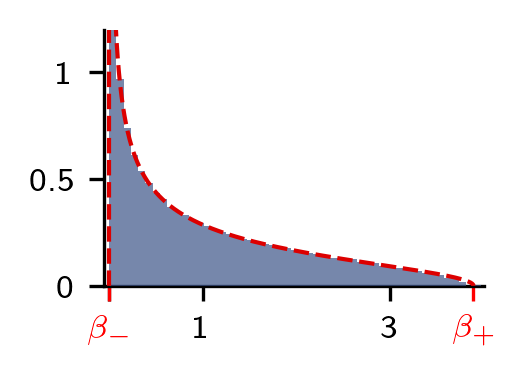

In [165]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adata['CD4T1_1_2'],bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,3])
ax.set_xticklabels([None,1,3])
ax.set_xlim([-0.05,4])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adata['CD4T1_1_2'].shape)/np.max(adata['CD4T1_1_2'].shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/hi_c.svg')

In [ ]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adata['CD4T1_1_2'])
svd_result = SVD(backend='torch',n_components=-1).fit(adata['CD4T1_1_2'].X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv)
median_ratio = actual_median/theoretical_median

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([6])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adata['CD4T1_1_2'].shape)/np.max(adata['CD4T1_1_2'].shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/hi_c.svg')

# Methylomics

In [170]:
from bipca.experiments.datasets.datasets import RufZamojski2021

In [171]:
adatas = RufZamojski2021(base_data_directory = "/banach2/jyc/data/BiPCA/").get_filtered_data()

Calculating retrieving filtered data...
  Calculating reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellMethylomics/RufZamojski2021/filtered/mc.h5ad...
    Unable to retrieve filtered data from disk.
  Calculated reading filtered data from /banach2/jyc/data/BiPCA/datasets/SingleCellMethylomics/RufZamojski2021/filtered/mc.h5ad in 0.01 seconds.
  Calculating retrieving raw data...
    Calculating acquiring unfiltered data...
    Calculated acquiring unfiltered data in 0.02 seconds.
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellMethylomics/RufZamojski2021/unfiltered/mc.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellMethylomics/RufZamojski2021/unfiltered/mc.h5ad in 94.57 seconds.
    Calculating reading unfiltered data from /banach2/jyc/data/BiPCA/datasets/SingleCellMethylomics/RufZamojski2021/unfiltered/cov.h5ad...
    Calculated reading unfiltered data from /banach2/jyc/data/BiPC

/bipca/python/bipca/experiments/datasets/datasets.py:2494: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotations.var['subsample'] = annotations.var['subsample'].replace({True: 2, False: 0})
/bipca/python/bipca/experiments/datasets/datasets.py:2503: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotations.obs['subsample'] = annotations.obs['subsample'].replace({True: 2, False: 0})
/bipca/python/bipca/experiments/datasets/datasets.py:2494: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a f

    Calculated filtering AnnData in 164.18 seconds.


/bipca/python/bipca/experiments/datasets/datasets.py:2494: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotations.var['subsample'] = annotations.var['subsample'].replace({True: 2, False: 0})
/bipca/python/bipca/experiments/datasets/datasets.py:2503: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotations.obs['subsample'] = annotations.obs['subsample'].replace({True: 2, False: 0})


  Calculated filtering mc in 164.90 seconds.
  Calculating filtering cov...
    Calculating filtering AnnData...


/bipca/python/bipca/experiments/datasets/datasets.py:2494: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotations.var['subsample'] = annotations.var['subsample'].replace({True: 2, False: 0})
/bipca/python/bipca/experiments/datasets/datasets.py:2503: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotations.obs['subsample'] = annotations.obs['subsample'].replace({True: 2, False: 0})
/bipca/python/bipca/experiments/datasets/datasets.py:2494: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a f

    Calculated filtering AnnData in 156.58 seconds.


/bipca/python/bipca/experiments/datasets/datasets.py:2494: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotations.var['subsample'] = annotations.var['subsample'].replace({True: 2, False: 0})
/bipca/python/bipca/experiments/datasets/datasets.py:2503: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annotations.obs['subsample'] = annotations.obs['subsample'].replace({True: 2, False: 0})


  Calculated filtering cov in 157.31 seconds.
Calculated retrieving filtered data in 512.26 seconds.


In [172]:
adatas

{'mc': AnnData object with n_obs × n_vars = 2756 × 13656
     obs: 'CellInputReadPairs', 'MappingRate', 'FinalmCReads', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Plate', 'Col384', 'Row384', 'CellTypeAnno', 'total_bins', 'subsample'
     var: 'chrom', 'end', 'start', 'total_obs', 'subsample',
 'cov': AnnData object with n_obs × n_vars = 2756 × 13656
     obs: 'CellInputReadPairs', 'MappingRate', 'FinalmCReads', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Plate', 'Col384', 'Row384', 'CellTypeAnno', 'total_bins', 'subsample'
     var: 'chrom', 'end', 'start', 'total_obs', 'subsample'}

In [174]:
torch.set_num_threads(72)
with threadpool_limits(limits=72):
    op = bipca.BiPCA(n_components=-1,seed=42)
    if issparse(adatas['mc'].X):
        adatas['mc'].X = adatas['mc'].X.toarray()
    Z = op.fit_transform(adatas['mc'].X)
    op.write_to_adata(adatas['mc'])
    op.get_plotting_spectrum()

Calculating BiPCA fit...
  Calculating variance fit over entire input...
    Chebyshev approximation of KS reached 1.886535441841478e-08 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in double_scalars
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=1.500370718725481, c=0.6537681991536384, KS=0.016095114883421746
    Approximating the mean of all submatrices
    Approximation ratio is 1.886535441841478e-08 with 65 coefficients
    b=1.500379708356676, c=0.6537721162755364
  Calculated variance fit over entire input in 194.20 seconds.
  Calculating Sinkhorn biscaling with dense torch backend...
    Sinkhorn converged early after 10 iterations.
  Calculated Sinkhorn biscaling with dense torch backend in 0.72 seconds.
  Calculating dense Biscaling transform...
  Calculated dense Biscaling transform in 0.05 seconds.
  Calculating rank k=2756 dense exact singular value decomposition using __compute_torch_svd....
  Calculated rank k=2756 dense exact singular value decomposition using __compute_torch_svd. in 3.26 seconds.
  Calculating Shrinker fit...
    Calculating MP Parameter estimate...
      Estimated noise variance computed from the 50th percentile is 1.000
      Scaled Marcenko-Pastur rank is 36
Calculated BiPCA f

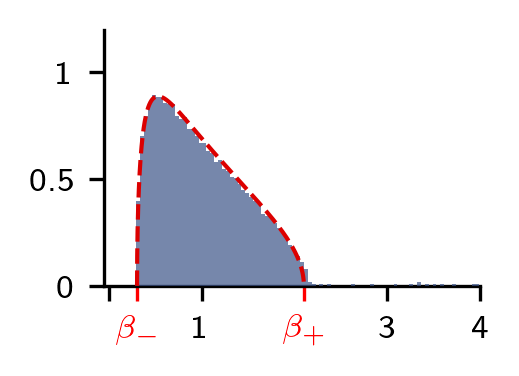

In [175]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adatas['mc'],bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,3,4])
ax.set_xticklabels([None,1,3,4])
ax.set_xlim([-0.05,4])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adatas['mc'].shape)/np.max(adatas['mc'].shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/methylomics_mcg.svg')

In [190]:
( plotting_spectrum,
        isquadratic,
        rank,
        M,
        N,
        gamma,
        b,
        c,
        bhat,
        chat,
        bhat_var,
        chat_var,
        kst,
        theoretical_median,
        cutoff,
        presvs,
        postsvs,
    ) = unpack_bipcaobj(adatas['mc'])
svd_result = SVD(backend='torch',n_components=-1).fit(adatas['mc'].X).svd
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv) # sv[sv < cutoff]
median_ratio = actual_median/theoretical_median

Calculating rank k=2756 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=2756 dense exact singular value decomposition using __compute_torch_svd. in 50.36 seconds.


KeyboardInterrupt: 

In [191]:
sv = (np.array(svd_result[1])**2)/len(svd_result[1])
actual_median = np.median(sv) # sv[sv < cutoff]
median_ratio = actual_median/theoretical_median

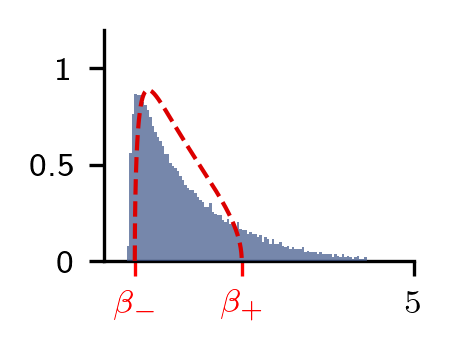

In [194]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
ax = MP_histogram(svs=sv/median_ratio,bins=100,gamma=gamma,ax=ax,loss_fun=None,median=False,
            hist_color=hist_color, pdf_color=pdf_color)

fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([5])

#ax.set_xlim([-0.05,3])
#ax.set_xticklabels([None,1,2,None,4])
ax.set_title('')


ax.grid(False)
#ax.artists.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,.5,1])
#fig.tight_layout()
MP = bipca.math.MarcenkoPastur(np.min(adatas['mc'].shape)/np.max(adatas['mc'].shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_unnorm/methylomics_mcg.svg')

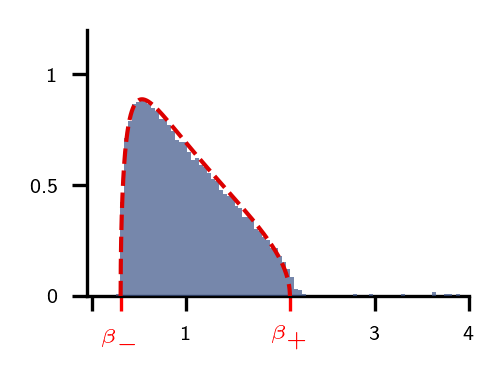

In [123]:
fig,ax=plt.subplots(1,1,figsize=(1,1),dpi=300)
MP_histograms_from_bipca(adatas['cov'],bins=100,axes=ax,both=False,full_text=False,legend=False,hist_color=hist_color, pdf_color=pdf_color,median=False)
fig.set_size_inches(1/.75,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0,1,3,4])
ax.set_xticklabels([None,1,3,4])
ax.set_xlim([-0.05,4])
ax.set_ylim([0,1.2])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1])
ax.set_title('')

ax.grid(False)
ax.artists[0].remove()
ax.set_xlabel('')
ax.set_ylabel('')
MP = bipca.math.MarcenkoPastur(np.min(adatas['cov'].shape)/np.max(adatas['cov'].shape))
bipca.plotting.add_colored_tick(ax,[MP.a,MP.b], [r'$\beta_-$',r'$\beta_+$'],dim='x')
fig.savefig('MP_demos/methylomics_cov.svg')